# Data Processing

First, we set up the necessities for running the Xception experiments:
 - Mounting Google Drive path and setting up the paths for the root directory, Xception results folder, train and test data folders.
 - Importing necessary python libraries for plotting, data processing, and model building and evaluationg.
 - Importing the torch implemantation of the Xception model fetched from GitHub.
 - Setting up "device" variable for GPU usage enabling.
 - Setting up the image data transfrom pipeline as recommended for Xception - resizing to 333x333 and center cropping to 299 with 0.5 mean and STD normalization throughout all channels. No rotation and and flipping has been performed in these experiments in an attempt to not add this kind of noise to the train data as the test data has less to no nise of this kind.
 - Setting up the data loader including weight balanced sampler for the train loader and batch size that fits the utilized GPU (T4) and Xception model parameters and gradients.
 - Defining the results plotting function as before.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils import class_weight
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

%matplotlib inline

In [ ]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "תואר שני מדעי הנתונים HIT/שנה א'/סמסטר ב'/למידה עמוקה/פרויקט קורס/"
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
GOOGLE_DRIVE_PATH_XCEPTION = os.path.join(GOOGLE_DRIVE_PATH, "xception_results")

sys.path.append(GOOGLE_DRIVE_PATH)
CLASSES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
from xception import xception

In [ ]:
GOOGLE_DRIVE_PATH_TRAIN = os.path.join(GOOGLE_DRIVE_PATH, 'alzheimers_dataset', 'train')
print(GOOGLE_DRIVE_PATH_TRAIN)
print(os.listdir(GOOGLE_DRIVE_PATH_TRAIN))
os.chdir(GOOGLE_DRIVE_PATH_TRAIN)

/content/drive/My Drive/תואר שני מדעי הנתונים HIT/שנה א'/סמסטר ב'/למידה עמוקה/פרויקט קורס/alzheimers_dataset/train
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
GOOGLE_DRIVE_PATH_TEST = os.path.join(GOOGLE_DRIVE_PATH, 'alzheimers_dataset', 'test')
print(GOOGLE_DRIVE_PATH_TEST)
print(os.listdir(GOOGLE_DRIVE_PATH_TEST))
os.chdir(GOOGLE_DRIVE_PATH_TEST)

/content/drive/My Drive/תואר שני מדעי הנתונים HIT/שנה א'/סמסטר ב'/למידה עמוקה/פרויקט קורס/alzheimers_dataset/test
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
GOOGLE_DRIVE_PATH_EXAMPLES = os.path.join(GOOGLE_DRIVE_PATH, 'alzheimers_dataset', 'examples')
print(GOOGLE_DRIVE_PATH_EXAMPLES)
print(os.listdir(GOOGLE_DRIVE_PATH_EXAMPLES))
os.chdir(GOOGLE_DRIVE_PATH_EXAMPLES)

/content/drive/My Drive/תואר שני מדעי הנתונים HIT/שנה א'/סמסטר ב'/למידה עמוקה/פרויקט קורס/alzheimers_dataset/examples
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented', 'pre_xception_fe_train_labels.pkl', 'pre_xception_fe_train_features.pkl']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
transform = T.Compose([
    T.Resize(333),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(GOOGLE_DRIVE_PATH_TRAIN, transform=transform)
test_dataset = ImageFolder(GOOGLE_DRIVE_PATH_TEST, transform=transform)

dataset_size = len(train_dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

Computing inverse class weights for inputting as samplers weights.

In [ ]:
train_indices = train_dataset.indices
train_labels = [train_dataset.dataset.targets[i] for i in train_indices]
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)

print(class_weights)

tensor([ 1.7445, 24.9756,  0.5025,  0.7161], device='cuda:0')


In [ ]:
samples_weights = class_weights[train_labels]
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weights, len(samples_weights))

batch_size = 48
# Tried using no equal weight sampler which resulted mostly common classes classification
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def plot_results(true_labels, predicted_labels):
  print(classification_report(true_labels, predicted_labels, target_names=CLASSES))
  confusion_mat = confusion_matrix(true_labels, predicted_labels)
  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion_mat, annot=True, cmap="viridis", fmt="d", xticklabels=CLASSES, yticklabels=CLASSES)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

Plotting examples of the loaded transformed image data.

In [ ]:
def examples_imshow():
    examples_folder = ImageFolder(GOOGLE_DRIVE_PATH_EXAMPLES, transform=transform)
    examples_loader = DataLoader(examples_folder, batch_size=batch_size)
    dataiter = iter(examples_loader)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(figsize=(10, 4), ncols=len(labels))
    for i in range(len(labels)):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))
        ax.title.set_text(CLASSES[labels[i]])
    plt.show()

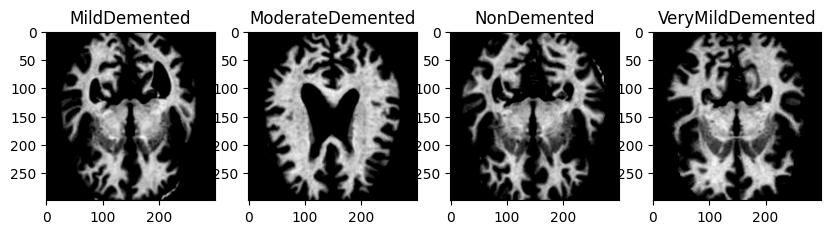

In [ ]:
examples_imshow()

# Pre-trained Xception model

Loading the pre-trained Xception model that was trained on ImageNet dataset and changing it's classification layer to a 4 class classifier, currently without further finetuning.
The Advantages of using a re-trained Xception model are:
 - Transfer Learning - Pre-training on the ImageNet dataset enables the Xception model to learn a rich set of hierarchical features that are generalizable across various visual tasks. Pre-trained models like Xception have already learned to recognize a wide range of objects and features from the diverse ImageNet dataset. This generalization enables the model to identify common patterns and structures in the MRI images that may be indicative of Alzheimer's disease. By leveraging the pre-trained knowledge, the Xception model can generalize well to unseen MRI data, potentially improving the classification performance. This is particularly useful when the target dataset (MRI images of Alzheimer's) is limited, as it allows the model to benefit from the large-scale ImageNet dataset.
 - Feature Extraction - The Xception model, being a deep convolutional neural network (CNN), is capable of extracting intricate and high-level features from the input MRI images. It captures both low-level details (such as edges and textures) and higher-level semantic information (such as shapes and structures) that can be relevant for Alzheimer's classification in our dataset.
 - Computational Efficiency - Xception is designed to be computationally efficient while maintaining a high level of accuracy. It employs depthwise separable convolutions, which significantly reduces the number of parameters compared to traditional convolutions. This architecture allows the model to process MRI images efficiently, making it feasible to apply on resource-constrained devices or in real-time applications. Though Xception's efficiency, training a deep CNN from scratch by yourself on a large-scale dataset like ImageNet still can be computationally expensive and time-consuming.

Loading the pre-trained weights:

In [ ]:
pretrained_model_path = os.path.join(GOOGLE_DRIVE_PATH, "xception-43020ad28.pth")
pretrained_model_state_dict = torch.load(pretrained_model_path)
xception_model = xception()
xception_model.load_state_dict(pretrained_model_state_dict)

<All keys matched successfully>

In [ ]:
num_classes = len(test_loader.dataset.classes)
classes = {CLASSES[i]: i for i in range(num_classes)}
print(f"Classes are: {classes}")

Classes are: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


Changing output dimension to number of classes in our dataset (4), and printing the models full structure with the changed head layer at the end:

In [ ]:
xception_model.fc = nn.Linear(2048, num_classes)
xception_model = xception_model.to(device)
xception_model

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

Predicting classes on the test set without further finetuning and plotting the results as base results for further finetuning attempts.

In [ ]:
xception_model.eval()

total_correct = 0
total_samples = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = xception_model(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"pre_xception_preds_labels.pkl"), 'wb') as f:
    pickle.dump(predicted_labels, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"pre_xception_true_labels.pkl"), 'wb') as f:
    pickle.dump(true_labels, f)

100%|██████████| 27/27 [08:33<00:00, 19.02s/it]


                  precision    recall  f1-score   support

    MildDemented       0.21      0.07      0.11       179
ModerateDemented       0.01      0.08      0.02        12
     NonDemented       0.63      0.16      0.25       640
VeryMildDemented       0.36      0.79      0.50       448

        accuracy                           0.37      1279
       macro avg       0.30      0.28      0.22      1279
    weighted avg       0.47      0.37      0.32      1279



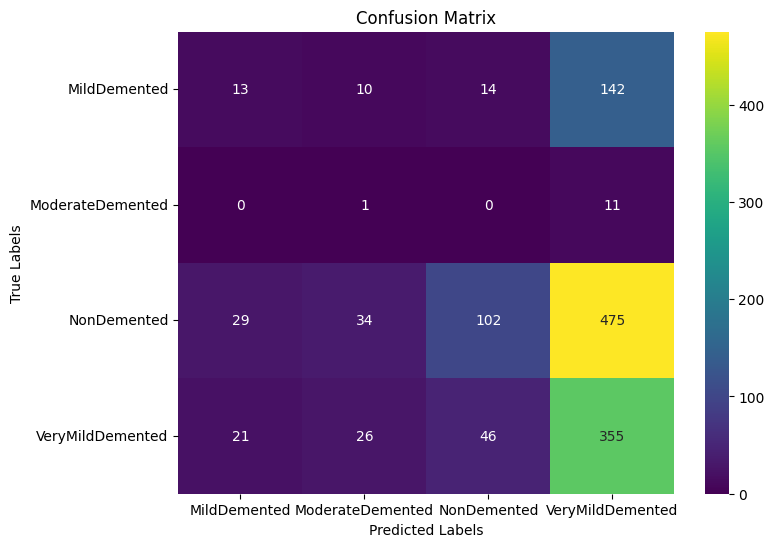

In [ ]:
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"pre_xception_preds_labels.pkl"), 'rb') as f:
    predicted_labels = pickle.load(f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"pre_xception_true_labels.pkl"), 'rb') as f:
    true_labels = pickle.load(f)

plot_results(true_labels, predicted_labels)

The classification report provides evaluation metrics for the classification model's performance on each class and overall.

In the case of the evaluated model results, it's performance is as follows:
 - Precision - precision is the ratio of true positives to the sum of true positives and false positives. It measures the accuracy of positive predictions. In this case, the precision for the classes "MildDemented", "ModerateDemented", "NonDemented", and "VeryMildDemented" are 0.21, 0.01, 0.63, and 0.36, respectively. These values indicate that the model has relatively low precision for most classes, except for "NonDemented" where it achieves a higher precision.
 - Recall - recall is the ratio of true positives to the sum of true positives and false negatives. It measures the ability of the model to identify positive instances correctly. The recall values for the classes "MildDemented," "ModerateDemented," "NonDemented," and "VeryMildDemented" are 0.07, 0.08, 0.16, and 0.79, respectively. These values indicate that the model performs better in terms of recall for the "VeryMildDemented" class compared to the other classes
 - F1-score: The F1-score is the harmonic mean of precision and recall. It provides a single metric that combines both precision and recall. The F1-scores for the classes "MildDemented", "ModerateDemented", "NonDemented", and "VeryMildDemented" are 0.11, 0.02, 0.25, and 0.50, respectively. These scores indicate the overall low performance of the model in terms of both precision and recall for each class.
 - Support - support represents the number of samples in each class. The support values for the classes "MildDemented," "ModerateDemented," "NonDemented," and "VeryMildDemented" are 179, 12, 640, and 448, respectively. It gives an idea of the distribution of samples among the different classes.
 - Accuracy - accuracy is the overall percentage of correctly classified samples. In this case, the accuracy is 0.37, indicating that the model achieves a moderate level of accuracy on the given dataset.
 - Macro Avg - the macro average is the unweighted average of the precision, recall, and F1-score for all the classes. In this case, the macro average precision, recall, and F1-score are 0.30, 0.28, and 0.22, respectively. It provides an overall performance measure that is not biased by class imbalance.
 - Weighted Avg - the weighted average is the weighted average of the precision, recall, and F1-score, weighted by the number of samples in each class. In this case, the weighted average precision, recall, and F1-score are 0.47, 0.37, and 0.32, respectively. It gives more importance to the classes with higher support.

Overall, the classification report of the model suggests that the model's performance is relatively low, with lower precision, recall, and F1-scores for most classes. It indicates the need for further optimization or improvement of the model to achieve better results, such as further finetuning for knowledge transfering.

# Pre-traind Xception model and use SVM as the classifier

Using Xception feature extraction as input to an SVM multi-class classifier offers a powerful approach for image classification tasks. The Xception model, pre-trained on a large-scale dataset like ImageNet, can extract rich and discriminative features from input images. By utilizing these extracted features as input to an SVM multi-class classifier, we can leverage the model's ability to capture both low-level details and high-level semantic information. The SVM classifier, known for its effectiveness in handling multi-class problems, can then utilize these features to learn decision boundaries that separate different classes effectively. This combined approach harnesses the strengths of both models, potentially leading to improved classification performance and accurate predictions for a wide range of image classes.
To perform the feature extraction using Xception, we pass the input MRI images through the pre-trained Xception model and extract the tensor values of the last layer before the fully connected classifier layer. These vectors, which capture the learned features, can be considered as the representative features for each input image. We can then use these extracted features as input to the SVM multi-class classifier for training and classification tasks.

In order to extract the tensor values we change the last FC layer to an identity layer for minimum code changes.

In [ ]:
pretrained_model_path = os.path.join(GOOGLE_DRIVE_PATH, "xception-43020ad28.pth")
fe_model_state_dict = torch.load(pretrained_model_path)
xception_model = xception()
xception_model.load_state_dict(fe_model_state_dict)
xception_model.fc = nn.Identity()
xception_model = xception_model.to(device)

In [ ]:
list(xception_model.children())[-2:]

[BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Identity()]

Extracting train and test set features:

In [ ]:
xception_model.eval()

train_features = []
train_labels = []

with torch.no_grad():
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        features = xception_model(images).cpu().numpy()
        train_features.append(features)
        train_labels.append(labels.numpy())

train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels)

with open("/content/pre_xception_fe_train_features.pkl", 'wb') as f:
    pickle.dump(train_features, f)
with open("/content/pre_xception_fe_train_labels.pkl", 'wb') as f:
    pickle.dump(train_labels, f)

100%|██████████| 86/86 [22:51<00:00, 15.95s/it]


In [ ]:
xception_model.eval()

test_features = []
test_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        features = xception_model(images).cpu().numpy()
        test_features.append(features)
        test_labels.append(labels.numpy())

test_features = np.concatenate(test_features)
test_labels = np.concatenate(test_labels)

with open("/content/pre_xception_fe_test_features.pkl", 'wb') as f:
    pickle.dump(test_features, f)
with open("/content/pre_xception_fe_test_labels.pkl", 'wb') as f:
    pickle.dump(test_labels, f)

100%|██████████| 27/27 [06:56<00:00, 15.44s/it]


In [ ]:
with open("/content/pre_xception_fe_train_features.pkl", 'rb') as f:
    train_features = pickle.load(f)
with open("/content/pre_xception_fe_train_labels.pkl", 'rb') as f:
    train_labels = pickle.load(f)

Training the SVM classifier:

In [ ]:
svm_classifier = SVC(verbose=1)
svm_classifier.fit(train_features, train_labels)

[LibSVM]

SVC(verbose=1)

In [ ]:
svm_classifier_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, "pre_xception_fe_svm_model.pkl")
with open(svm_classifier_path, 'wb') as f:
    pickle.dump(svm_classifier, f)

Evaluating the SVM classifier on the test data:

100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


                  precision    recall  f1-score   support

    MildDemented       0.34      0.18      0.23       179
ModerateDemented       0.56      0.42      0.48        12
     NonDemented       0.72      0.65      0.69       640
VeryMildDemented       0.46      0.62      0.53       448

        accuracy                           0.57      1279
       macro avg       0.52      0.47      0.48      1279
    weighted avg       0.58      0.57      0.57      1279



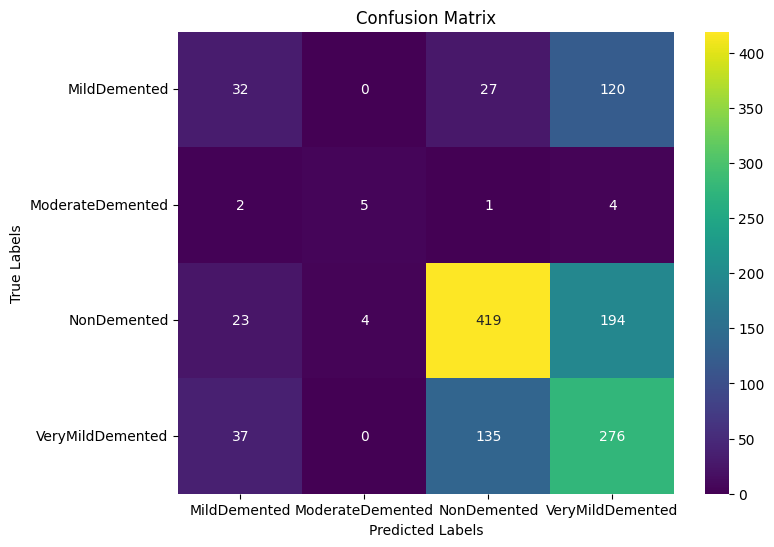

In [ ]:
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        features = xception_model(images).cpu().numpy()
        preds = svm_classifier.predict(features)
        predicted_labels.extend(preds)
        true_labels.extend(labels.numpy())

predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

plot_results(true_labels, predicted_labels)

The results present the evaluation metrics for an SVM classifier model's performance on each class and overall:
 - Precision - the precision values for the classes "MildDemented", "ModerateDemented", "NonDemented", and "VeryMildDemented" are 0.34, 0.56, 0.72, and 0.46, respectively. Compared to the previous model, there are improvements in precision for most classes, indicating better accuracy in positive predictions.
 - Recall - the recall values for the classes "MildDemented", "ModerateDemented", "NonDemented", and "VeryMildDemented" are 0.18, 0.42, 0.65, and 0.62, respectively. The recall has generally increased across most classes, indicating improved ability to correctly identify positive instances
 - F1-score - the F1-scores for the classes "MildDemented", "ModerateDemented", "NonDemented", and "VeryMildDemented" are 0.23, 0.48, 0.69, and 0.53, respectively. Similar to precision and recall, there are overall improvements in the F1-scores for most classes compared to the previous model
 - Accuracy - The accuracy of the SVM classifier model is reported as 0.57, representing an improvement compared to the previous model.
 - Macro Avg - the macro average precision, recall, and F1-score are 0.52, 0.47, and 0.48, respectively. These values indicate an overall improvement compared to the previous model, suggesting enhanced performance in terms of precision, recall, and F1-score across all classes.
 - Weighted Avg-  the weighted average precision, recall, and F1-score are 0.58, 0.57, and 0.57, respectively. These values indicate an improvement compared to the previous model, suggesting enhanced performance when considering class imbalances.

Comparing to the previous model's performance, the SVM classifier model demonstrates better precision, recall, and F1-scores for most classes. The overall accuracy and macro average metrics also indicate improved performance. These improvements suggest that the SVM classifier, when combined with Xception feature extraction, can provide enhanced classification results for Alzheimer's disease in MRI images.
Considering the SVM was utilized with default hyperparameters, we can assume that the SVM performance can be optimized even more.

# Pre-traind Xception and fine tunning parameters and layers:

We initialize an Xception model with ImageNet pre-trained weights.
Next, we adjust the FC layer to have 4 output neurons, aligning with the number of classes in our Alzheimer's disease classification task. This modification enables the model to adapt its final layer for accurate predictions specific to the 4 different classes related to Alzheimer's disease severity. With the updated FC layer, the Xception model becomes tailored to our target classification problem, enhancing its performance in classifying Alzheimer's disease in MRI images.

In [ ]:
xception_model = xception()
xception_model.load_state_dict(pretrained_model_state_dict)
for param in xception_model.parameters():
  param.requires_grad = False

xception_model.fc = nn.Linear(2048, 4)
xception_model = xception_model.to(device)
list(xception_model.children())[-1]

Linear(in_features=2048, out_features=4, bias=True)

First, we use a learning rate of 1e-5 as was used for the ImageNet dataset pre-training, with weight decay regularization hyperparameter of 0.1.
For all Xception model training experiments we utilized the Adam optimizer and Cross Entropy loss.
We ran a the model for a max of 100 epochs, displaying train and validation loss and plotting the loss history chart in each epoch end.

The first experiment utilized a data loader without a weighted sampler.

Epoch 1/100 | Training Loss: 1.3736 | Validation Loss: 1.4003


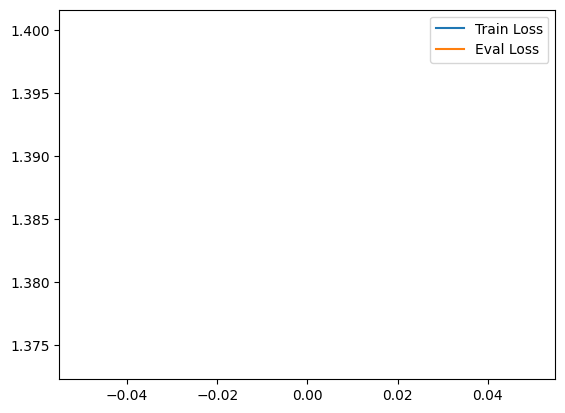

Epoch 2/100 | Training Loss: 1.3632 | Validation Loss: 1.4041


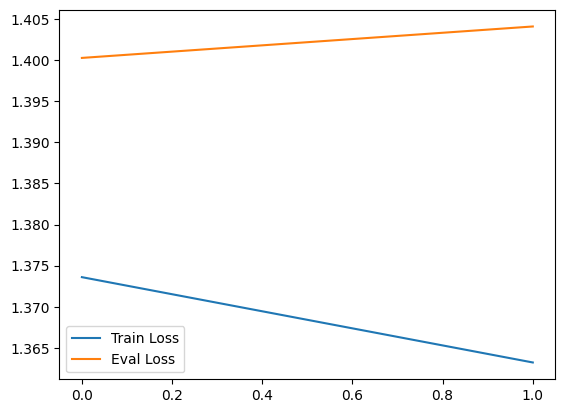

Epoch 3/100 | Training Loss: 1.3553 | Validation Loss: 1.4051


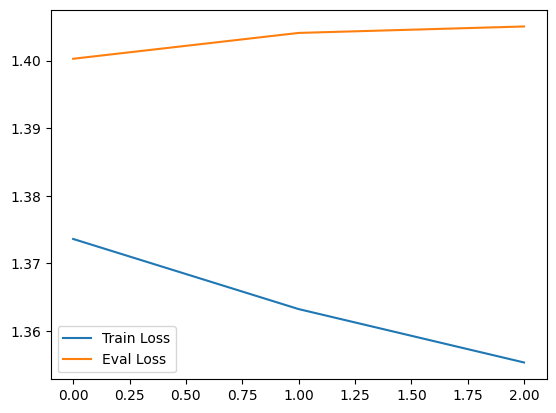

Epoch 4/100 | Training Loss: 1.3471 | Validation Loss: 1.4086


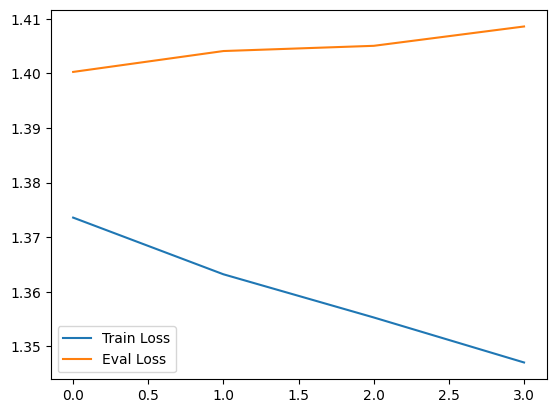

Epoch 5/100 | Training Loss: 1.3459 | Validation Loss: 1.4086


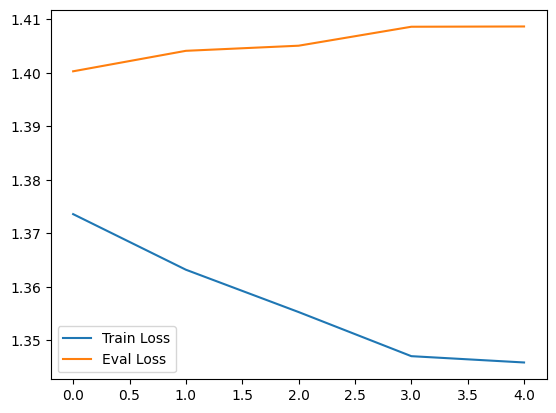

Epoch 6/100 | Training Loss: 1.3437 | Validation Loss: 1.4047


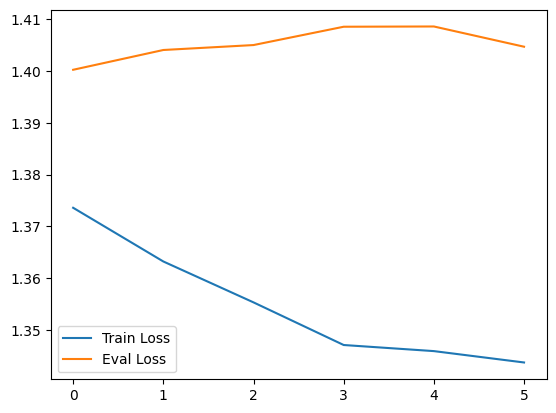

Epoch 7/100 | Training Loss: 1.3396 | Validation Loss: 1.4041


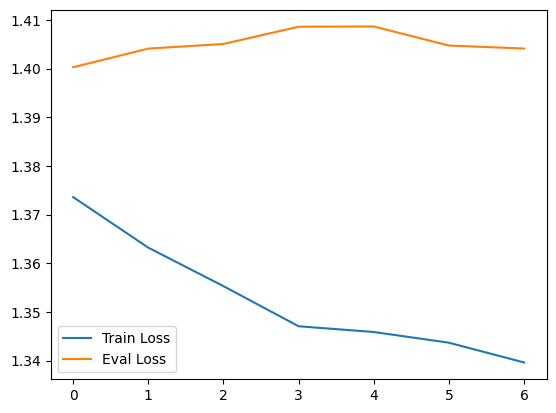

Epoch 8/100 | Training Loss: 1.3370 | Validation Loss: 1.4008


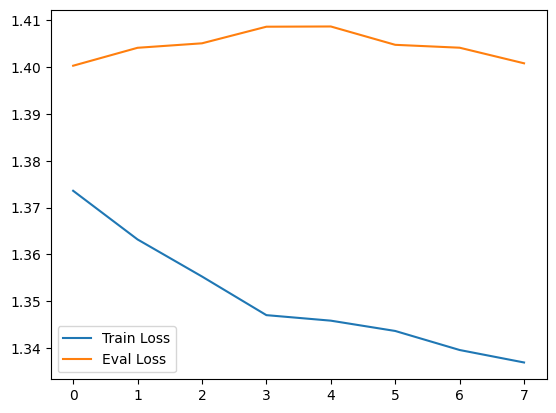

Epoch 9/100 | Training Loss: 1.3327 | Validation Loss: 1.3996


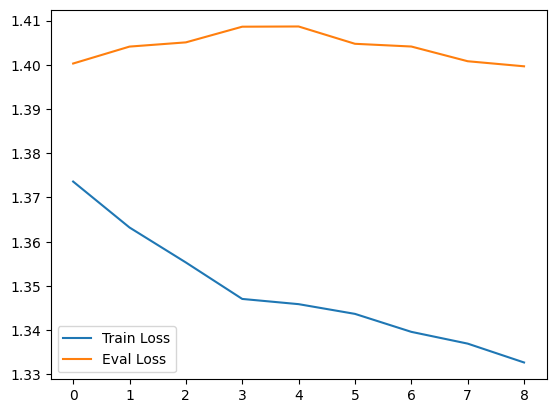

Epoch 10/100 | Training Loss: 1.3277 | Validation Loss: 1.4005


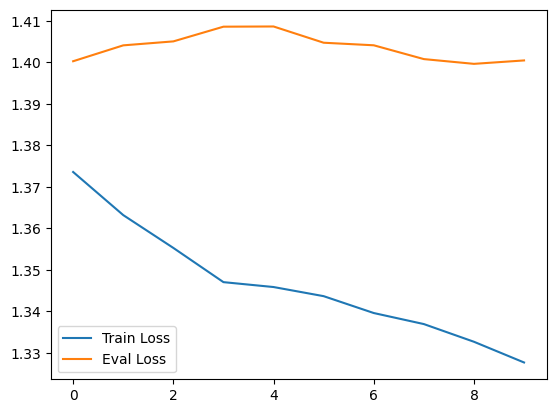

Epoch 11/100 | Training Loss: 1.3234 | Validation Loss: 1.3955


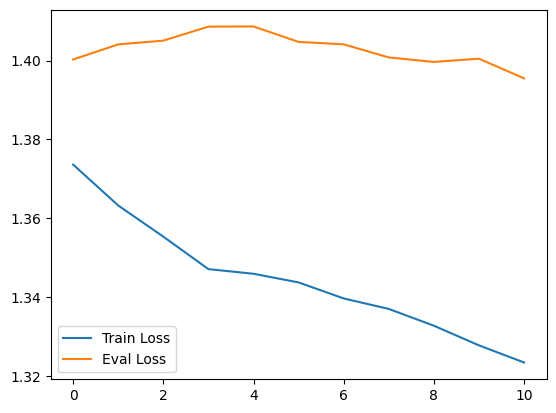

Epoch 12/100 | Training Loss: 1.3219 | Validation Loss: 1.3926


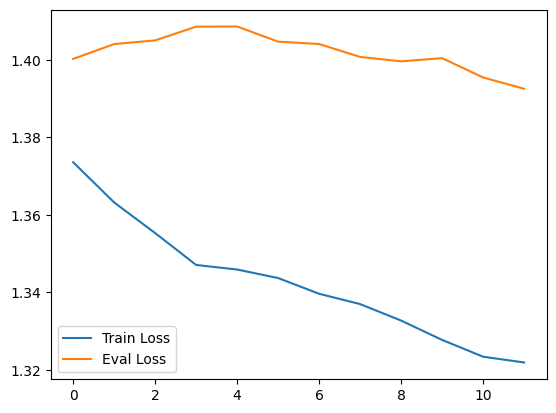

Epoch 13/100 | Training Loss: 1.3207 | Validation Loss: 1.3905


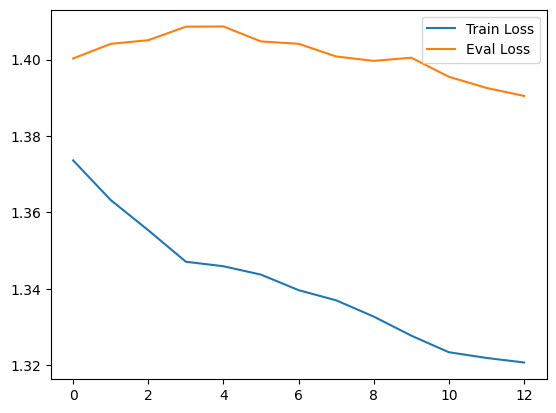

Epoch 14/100 | Training Loss: 1.3181 | Validation Loss: 1.3872


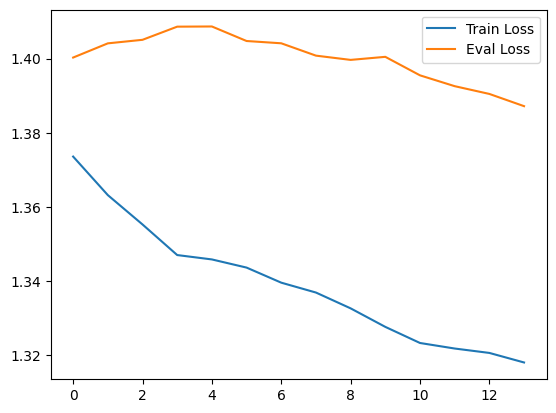

Epoch 15/100 | Training Loss: 1.3076 | Validation Loss: 1.3881


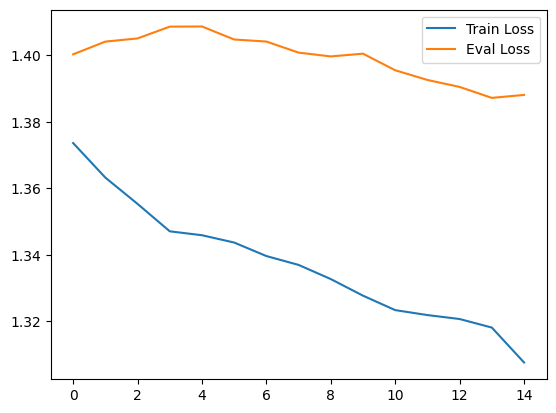

Epoch 16/100 | Training Loss: 1.3011 | Validation Loss: 1.3875


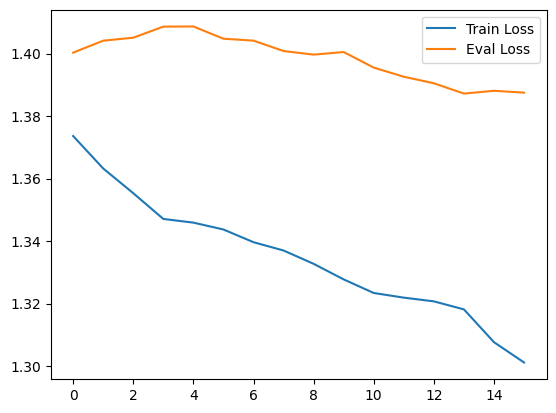

Epoch 17/100 | Training Loss: 1.3114 | Validation Loss: 1.3806


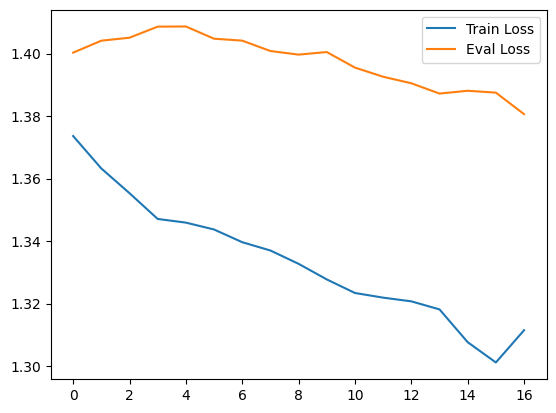

Epoch 18/100 | Training Loss: 1.3074 | Validation Loss: 1.3798


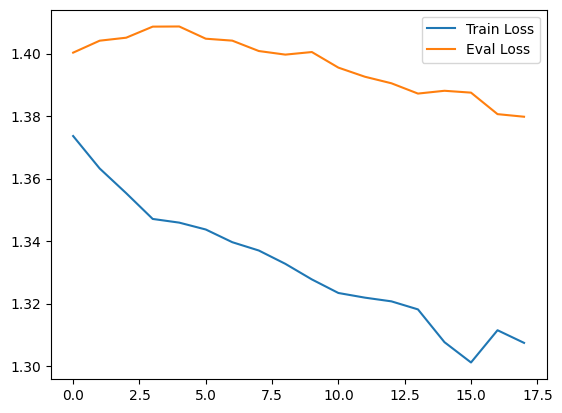

Epoch 19/100 | Training Loss: 1.2998 | Validation Loss: 1.3787


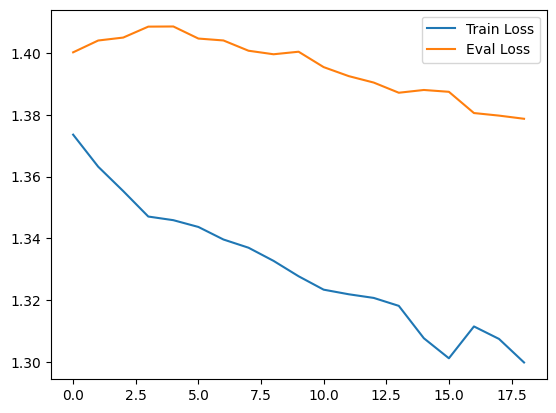

Epoch 20/100 | Training Loss: 1.2968 | Validation Loss: 1.3734


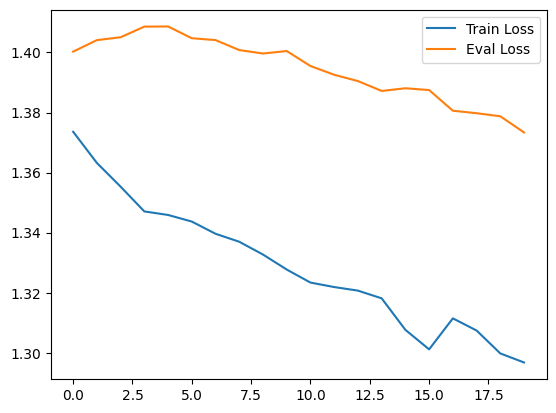

Epoch 21/100 | Training Loss: 1.2967 | Validation Loss: 1.3696


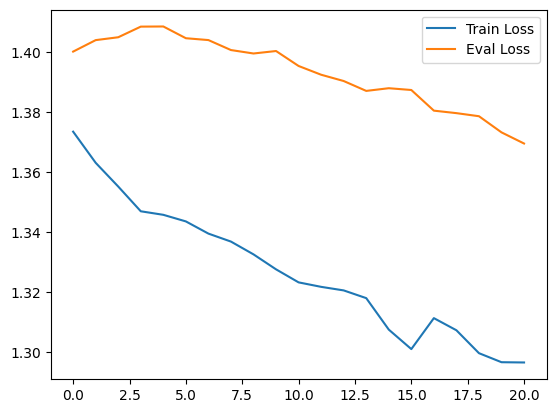

Epoch 22/100 | Training Loss: 1.2947 | Validation Loss: 1.3676


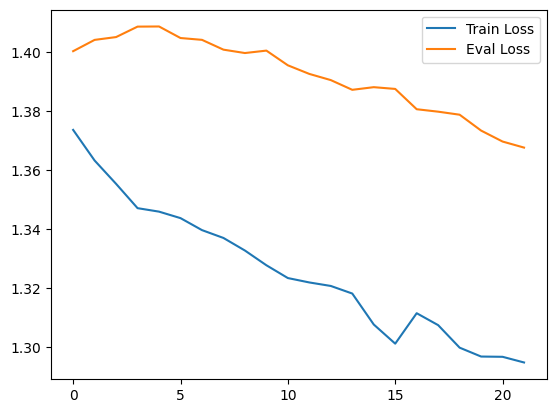

Epoch 23/100 | Training Loss: 1.2896 | Validation Loss: 1.3658


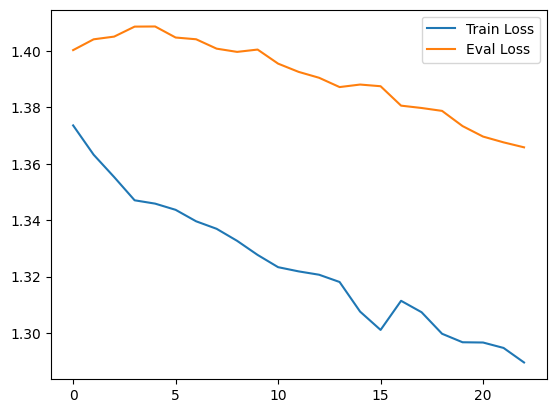

Epoch 24/100 | Training Loss: 1.2848 | Validation Loss: 1.3642


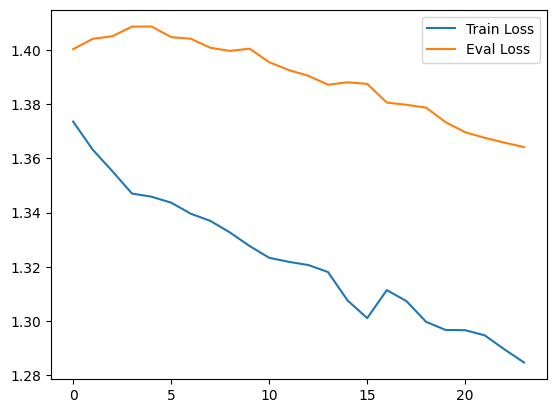

Epoch 25/100 | Training Loss: 1.2804 | Validation Loss: 1.3629


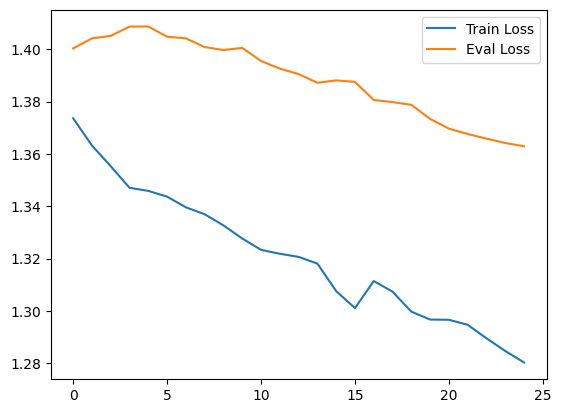

Epoch 26/100 | Training Loss: 1.2796 | Validation Loss: 1.3611


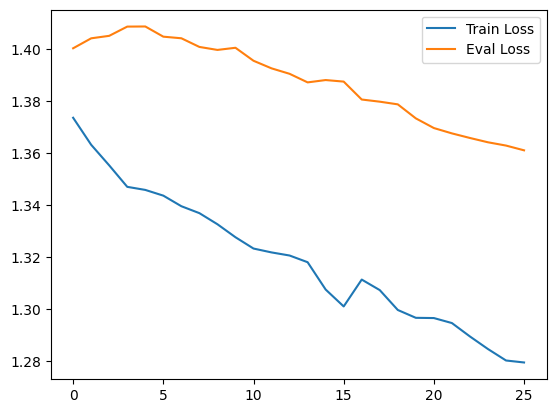

Epoch 27/100 | Training Loss: 1.2808 | Validation Loss: 1.3575


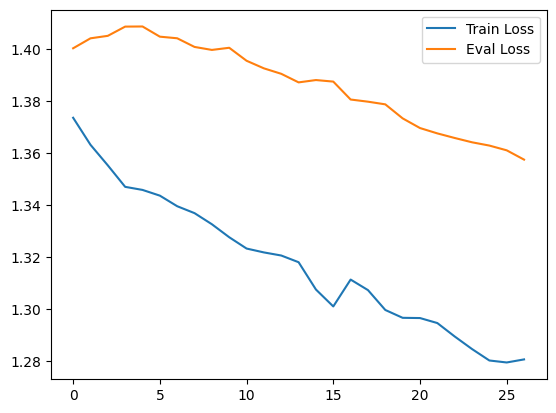

Epoch 28/100 | Training Loss: 1.2777 | Validation Loss: 1.3565


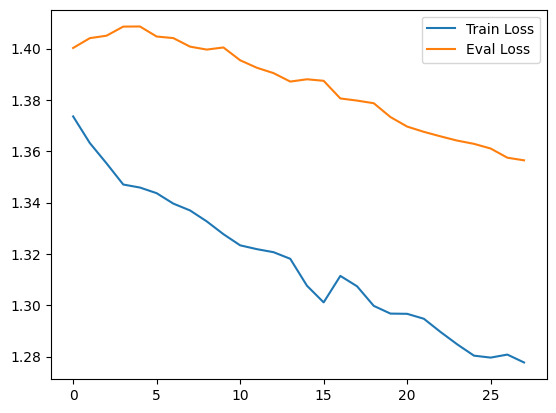

Epoch 29/100 | Training Loss: 1.2744 | Validation Loss: 1.3506


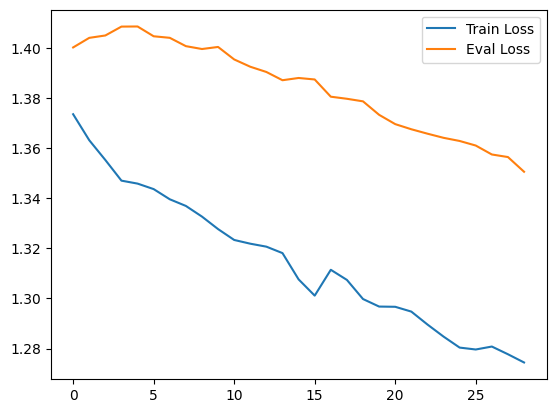

Epoch 30/100 | Training Loss: 1.2701 | Validation Loss: 1.3507


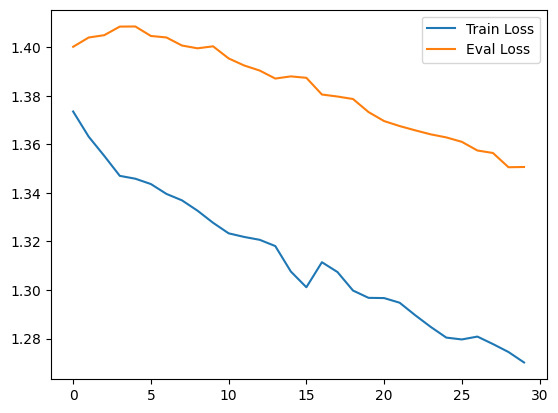

Epoch 31/100 | Training Loss: 1.2705 | Validation Loss: 1.3482


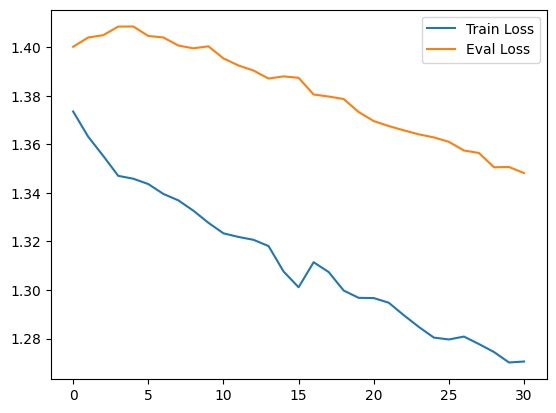

Epoch 32/100 | Training Loss: 1.2708 | Validation Loss: 1.3451


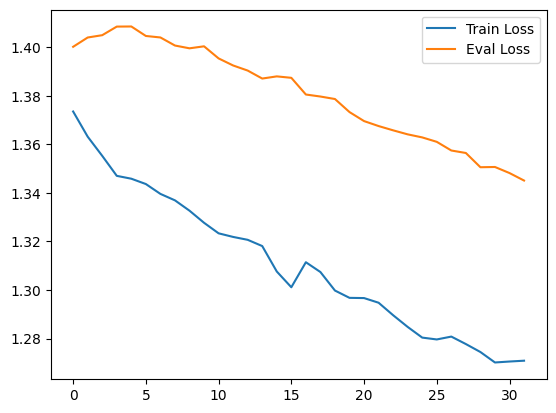

Epoch 33/100 | Training Loss: 1.2680 | Validation Loss: 1.3423


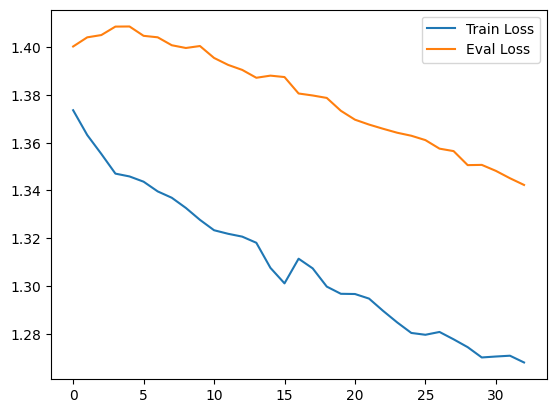

Epoch 34/100 | Training Loss: 1.2637 | Validation Loss: 1.3393


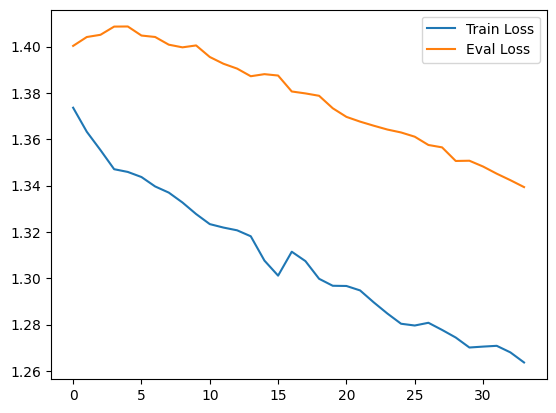

Epoch 35/100 | Training Loss: 1.2631 | Validation Loss: 1.3341


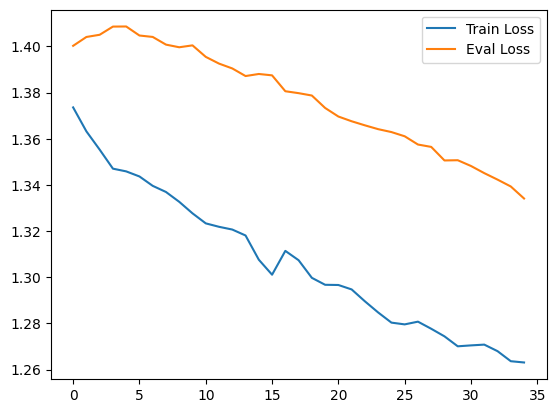

Epoch 36/100 | Training Loss: 1.2598 | Validation Loss: 1.3332


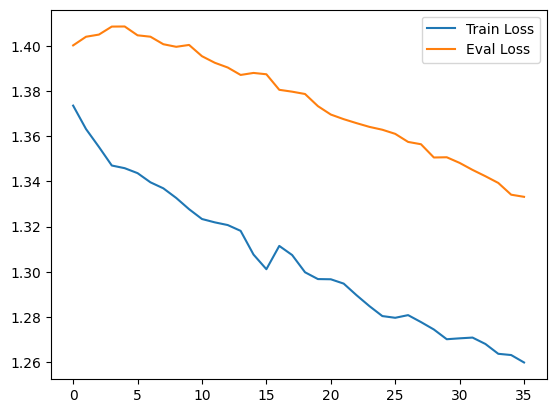

Epoch 37/100 | Training Loss: 1.2573 | Validation Loss: 1.3316


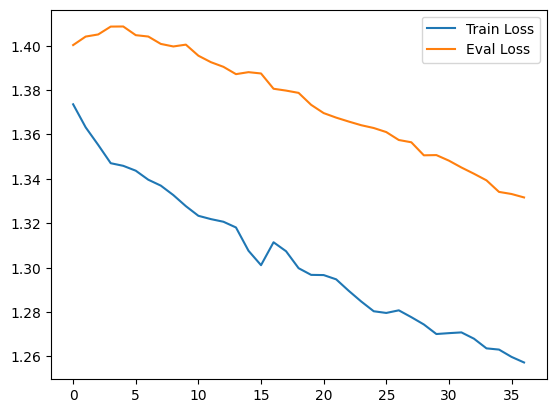

Epoch 38/100 | Training Loss: 1.2557 | Validation Loss: 1.3298


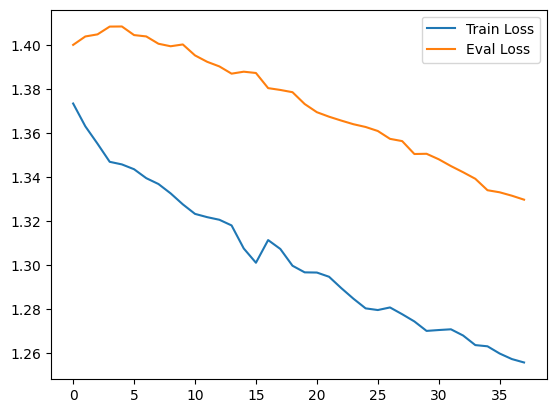

Epoch 39/100 | Training Loss: 1.2530 | Validation Loss: 1.3246


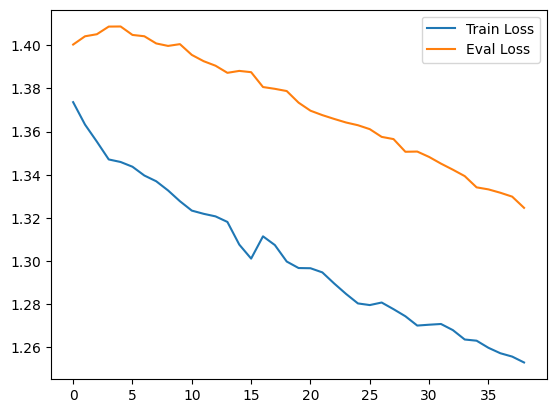

Epoch 40/100 | Training Loss: 1.2511 | Validation Loss: 1.3233


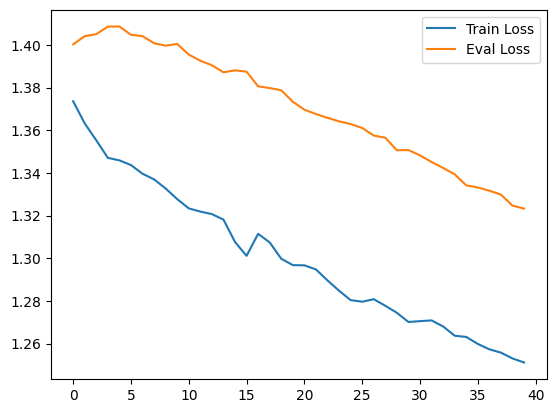

Epoch 41/100 | Training Loss: 1.2415 | Validation Loss: 1.3270


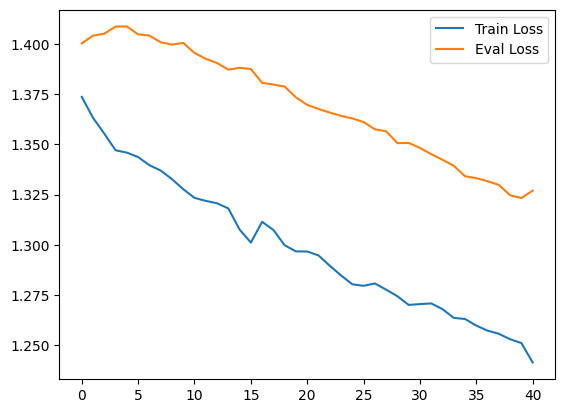

Epoch 42/100 | Training Loss: 1.2472 | Validation Loss: 1.3220


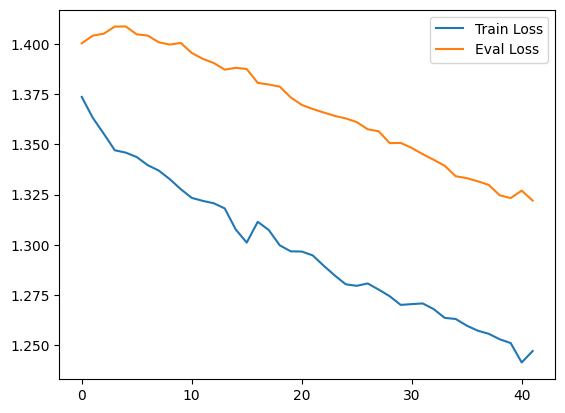

Epoch 43/100 | Training Loss: 1.2448 | Validation Loss: 1.3212


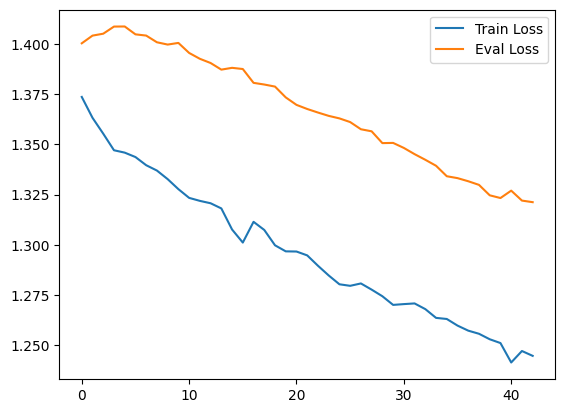

Epoch 44/100 | Training Loss: 1.2437 | Validation Loss: 1.3169


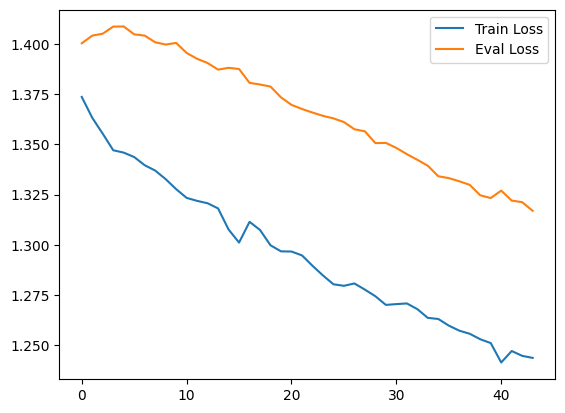

Epoch 45/100 | Training Loss: 1.2439 | Validation Loss: 1.3123


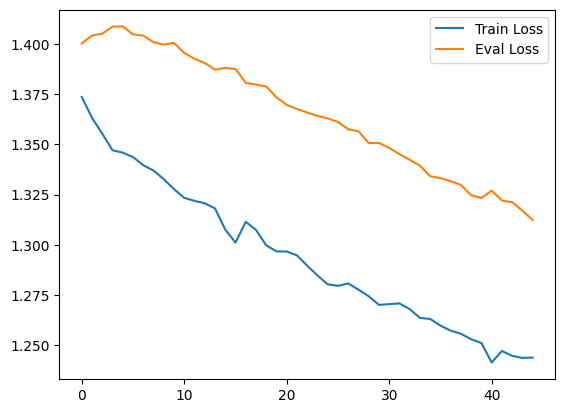

Epoch 46/100 | Training Loss: 1.2396 | Validation Loss: 1.3101


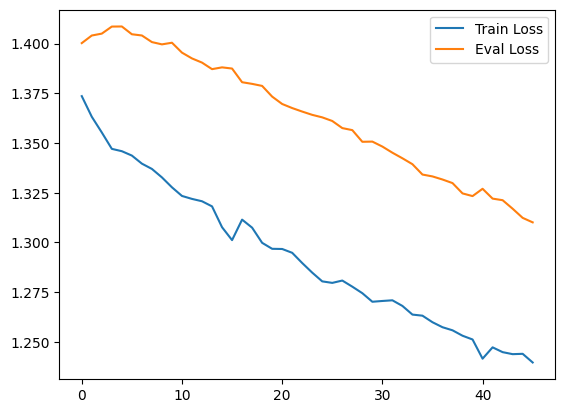

Epoch 47/100 | Training Loss: 1.2380 | Validation Loss: 1.3092


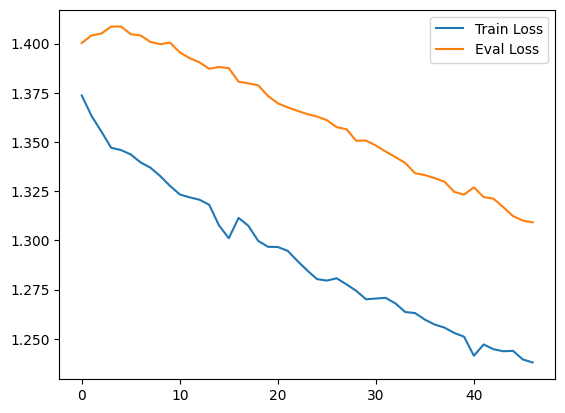

Epoch 48/100 | Training Loss: 1.2309 | Validation Loss: 1.3076


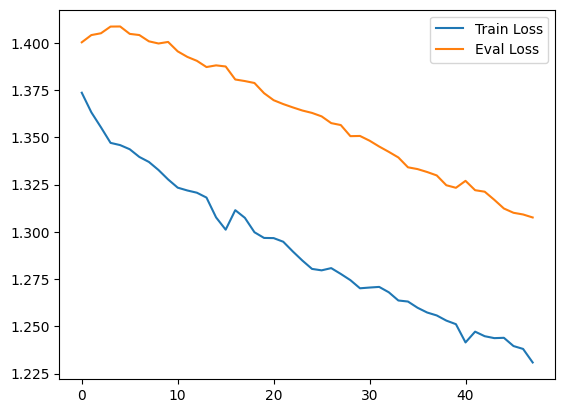

Epoch 49/100 | Training Loss: 1.2332 | Validation Loss: 1.3116


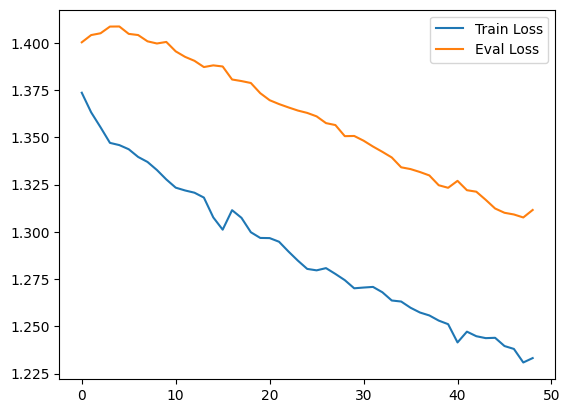

Epoch 50/100 | Training Loss: 1.2328 | Validation Loss: 1.3079


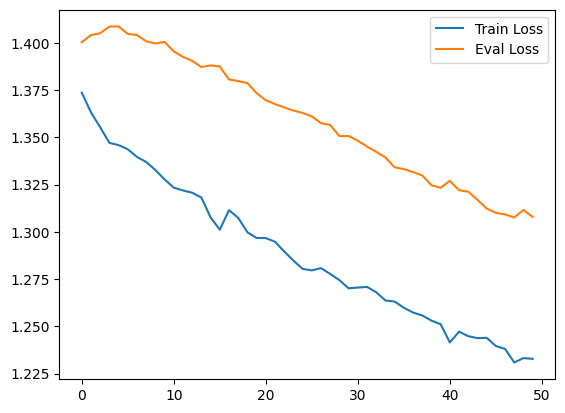

Epoch 51/100 | Training Loss: 1.2282 | Validation Loss: 1.3064


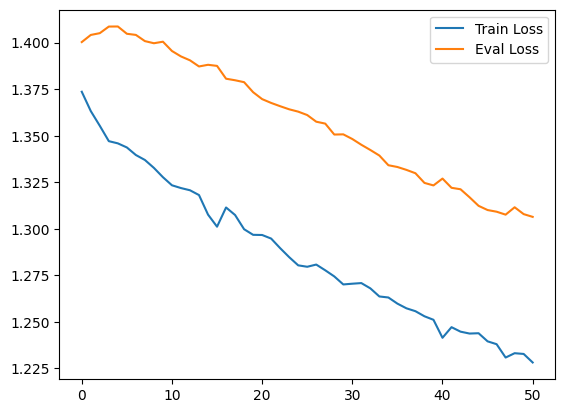

Epoch 52/100 | Training Loss: 1.2261 | Validation Loss: 1.3069


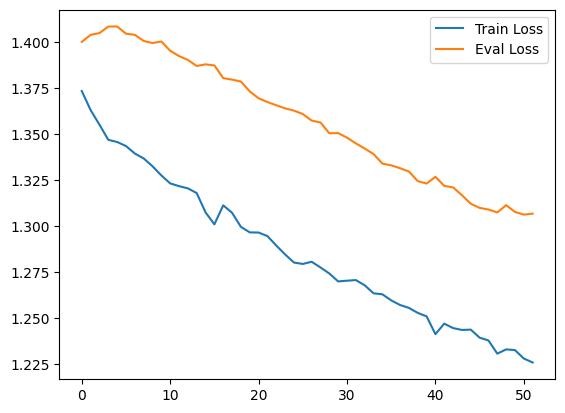

Epoch 53/100 | Training Loss: 1.2276 | Validation Loss: 1.3017


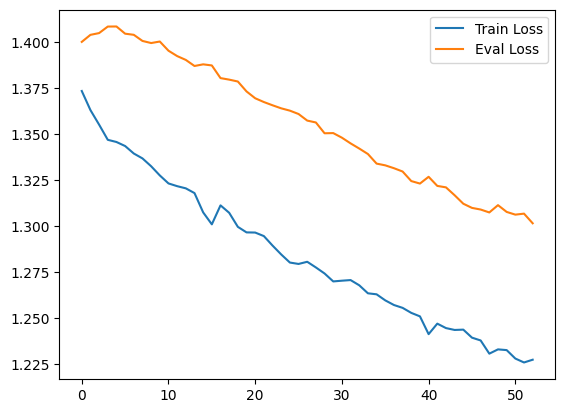

Epoch 54/100 | Training Loss: 1.2214 | Validation Loss: 1.3039


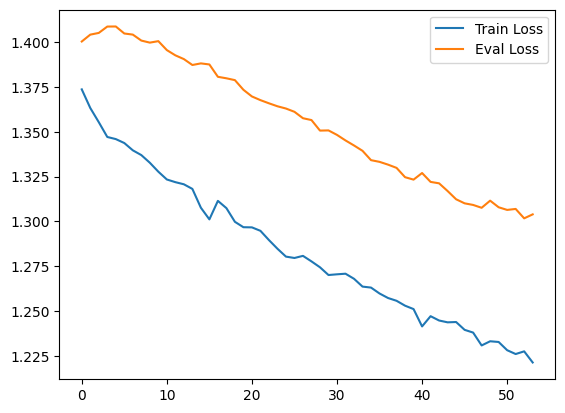

Epoch 55/100 | Training Loss: 1.2250 | Validation Loss: 1.2989


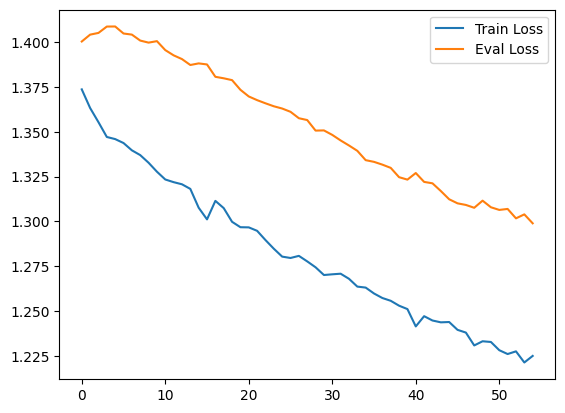

Epoch 56/100 | Training Loss: 1.2214 | Validation Loss: 1.2950


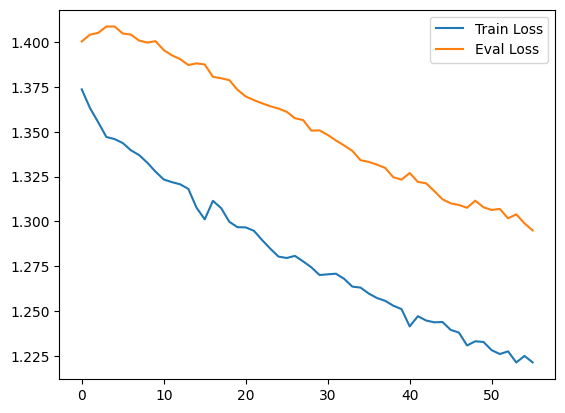

Epoch 57/100 | Training Loss: 1.2203 | Validation Loss: 1.2937


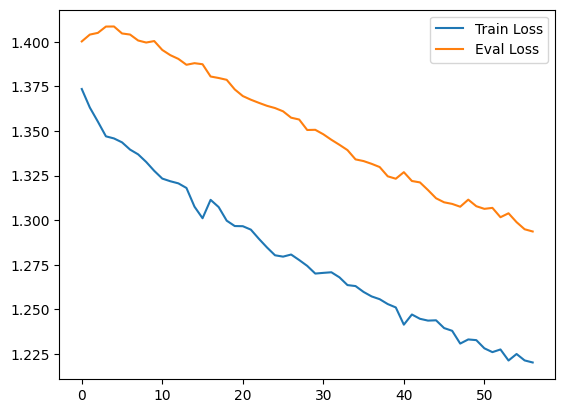

Epoch 58/100 | Training Loss: 1.2167 | Validation Loss: 1.2952


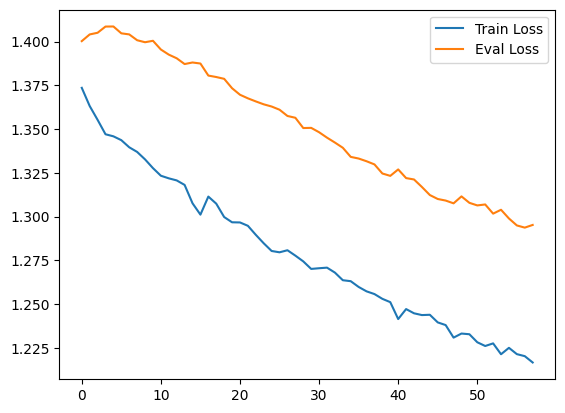

Epoch 59/100 | Training Loss: 1.2111 | Validation Loss: 1.2936


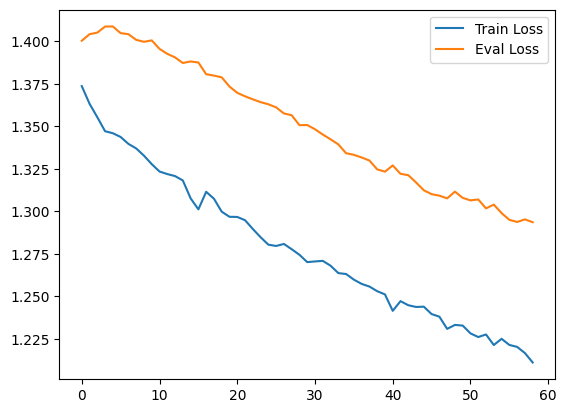

Epoch 60/100 | Training Loss: 1.2203 | Validation Loss: 1.2902


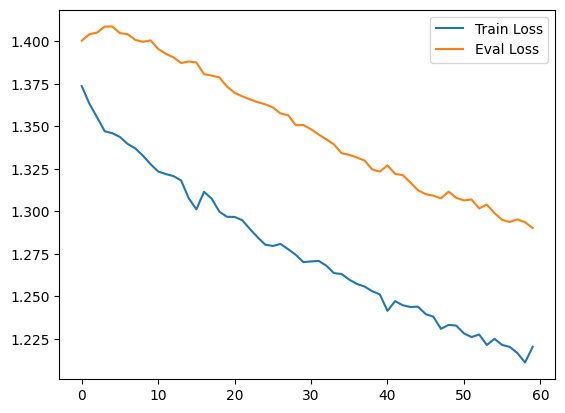

Epoch 61/100 | Training Loss: 1.2147 | Validation Loss: 1.2894


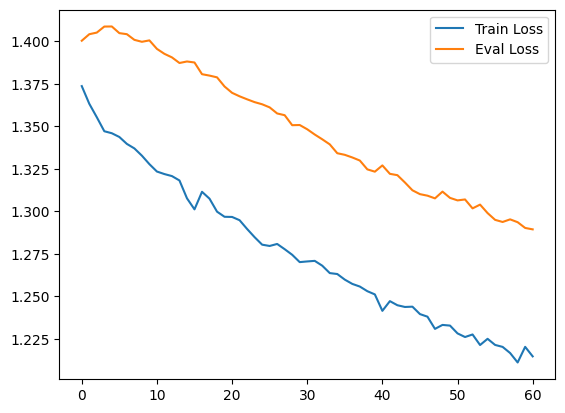

Epoch 62/100 | Training Loss: 1.2137 | Validation Loss: 1.2851


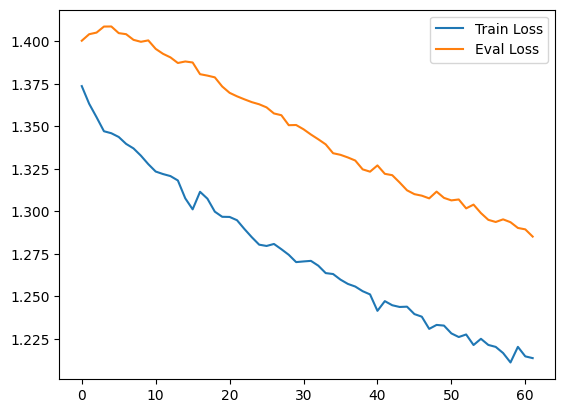

Epoch 63/100 | Training Loss: 1.2084 | Validation Loss: 1.2868


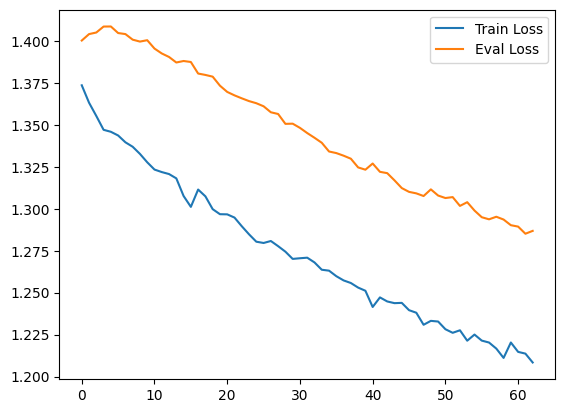

Epoch 64/100 | Training Loss: 1.2122 | Validation Loss: 1.2832


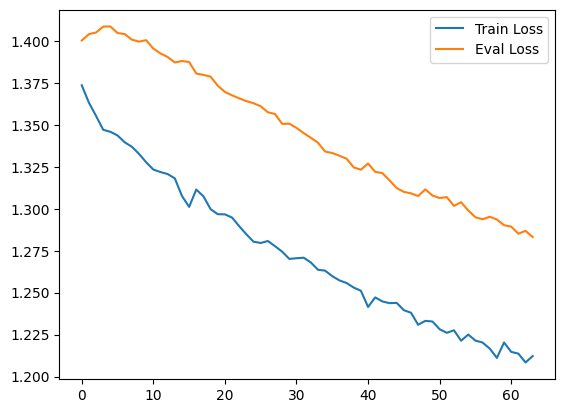

Epoch 65/100 | Training Loss: 1.2089 | Validation Loss: 1.2833


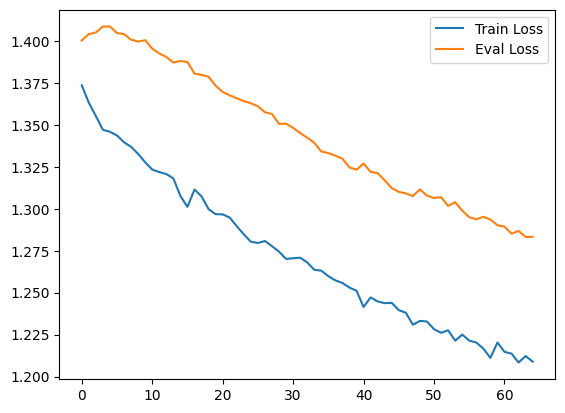

Epoch 66/100 | Training Loss: 1.2057 | Validation Loss: 1.2787


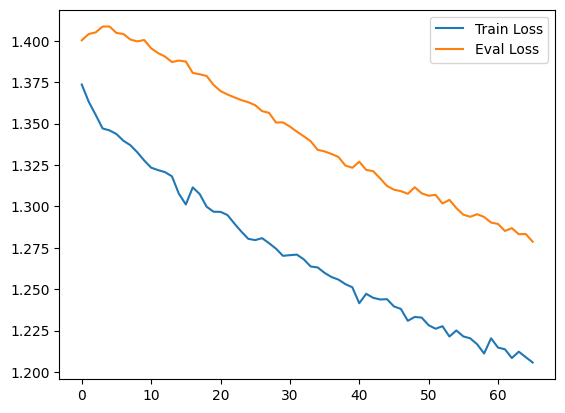

Epoch 67/100 | Training Loss: 1.2020 | Validation Loss: 1.2787


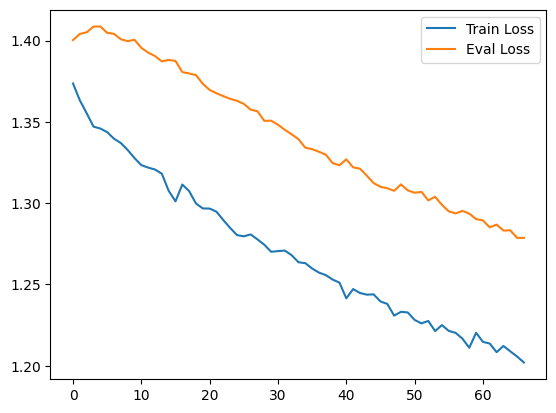

Epoch 68/100 | Training Loss: 1.2020 | Validation Loss: 1.2776


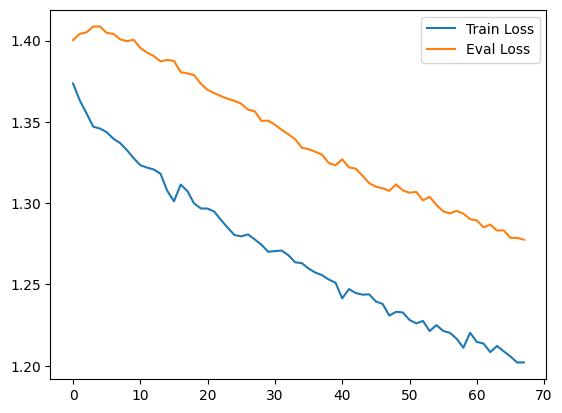

Epoch 69/100 | Training Loss: 1.2020 | Validation Loss: 1.2755


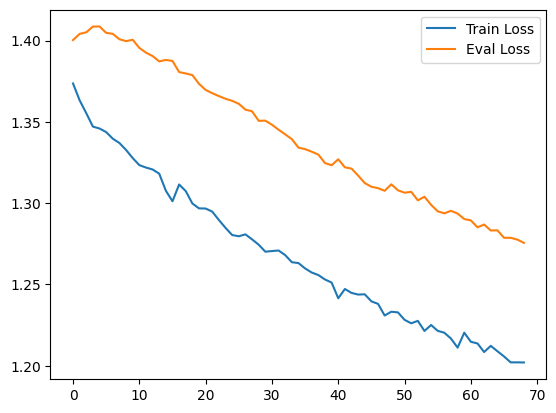

Epoch 70/100 | Training Loss: 1.2035 | Validation Loss: 1.2721


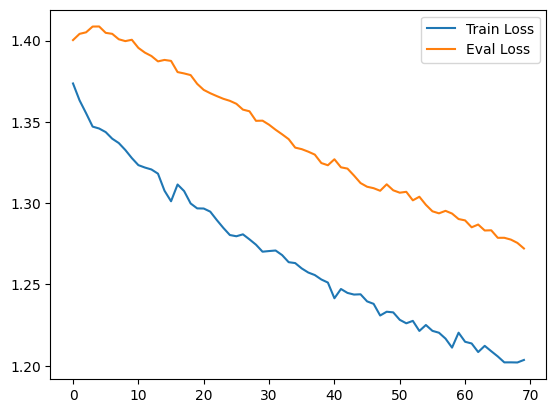

Epoch 71/100 | Training Loss: 1.1963 | Validation Loss: 1.2739


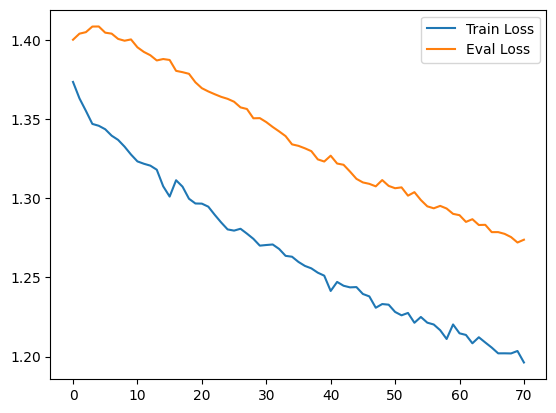

Epoch 72/100 | Training Loss: 1.1929 | Validation Loss: 1.2760


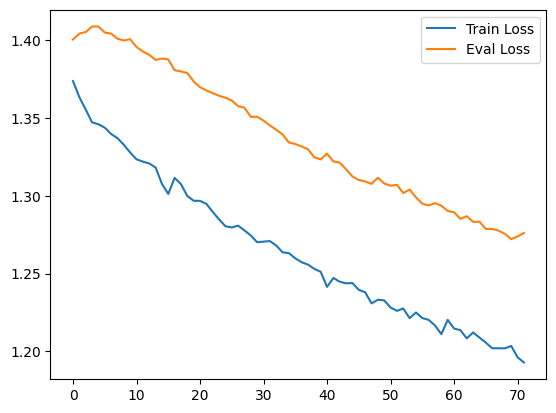

Epoch 73/100 | Training Loss: 1.1918 | Validation Loss: 1.2787


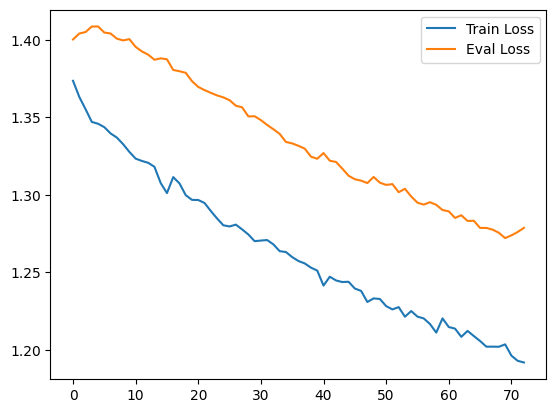

Epoch 74/100 | Training Loss: 1.1940 | Validation Loss: 1.2709


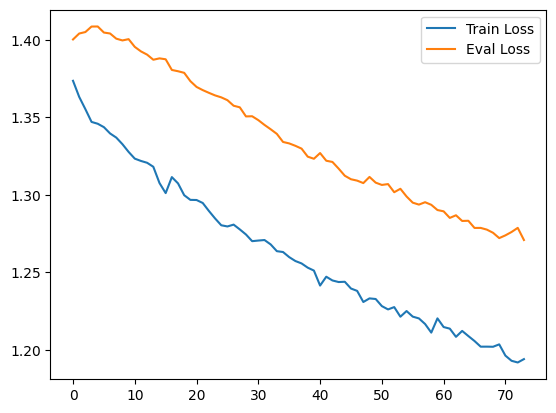

Epoch 75/100 | Training Loss: 1.1901 | Validation Loss: 1.2723


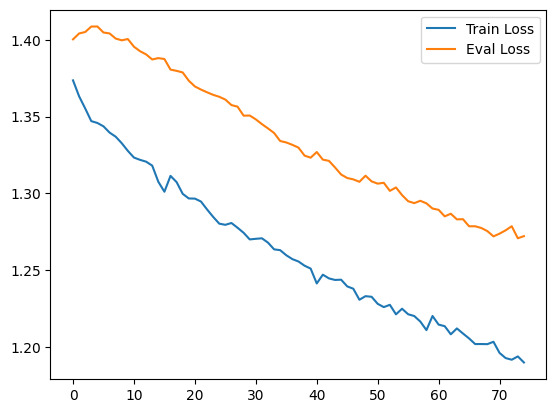

Epoch 76/100 | Training Loss: 1.1926 | Validation Loss: 1.2704


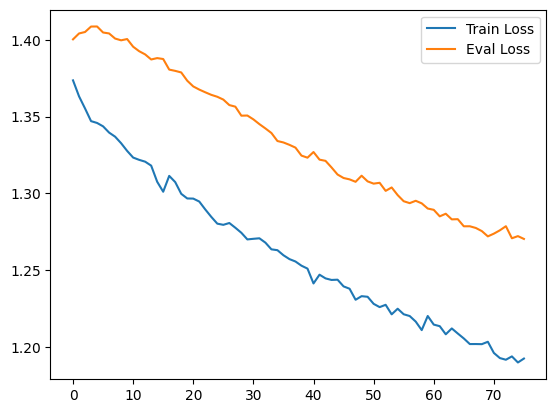

Epoch 77/100 | Training Loss: 1.1908 | Validation Loss: 1.2695


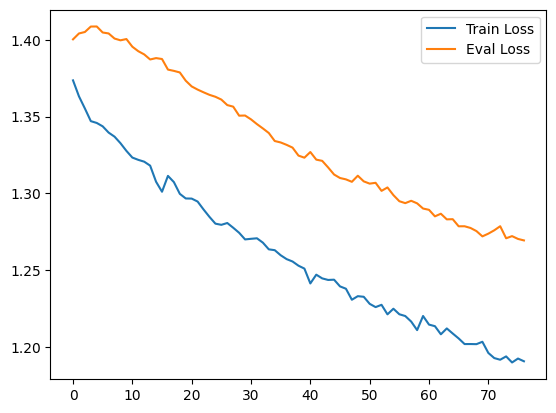

Epoch 78/100 | Training Loss: 1.1921 | Validation Loss: 1.2694


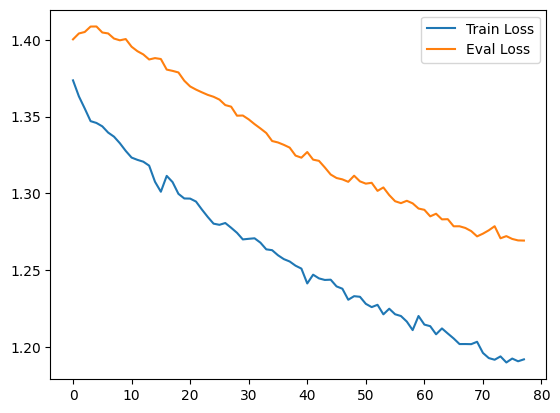

Epoch 79/100 | Training Loss: 1.1869 | Validation Loss: 1.2657


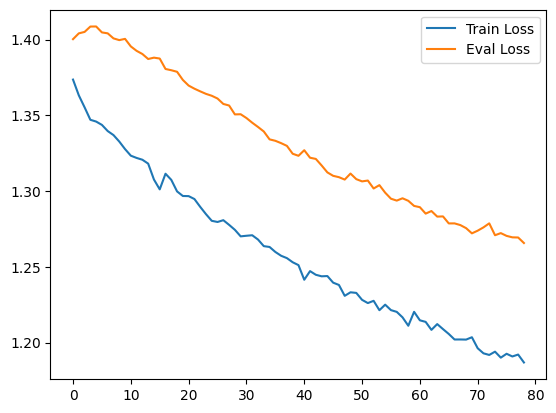

Epoch 80/100 | Training Loss: 1.1871 | Validation Loss: 1.2628


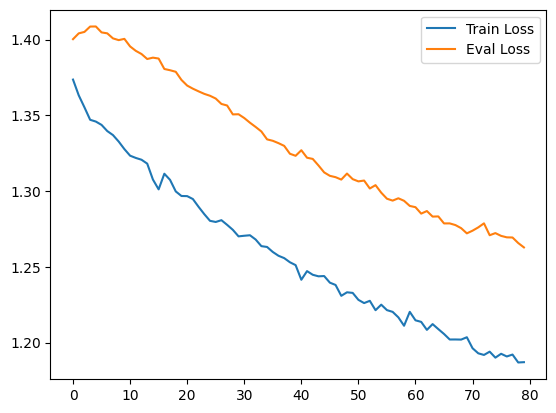

Epoch 81/100 | Training Loss: 1.1829 | Validation Loss: 1.2621


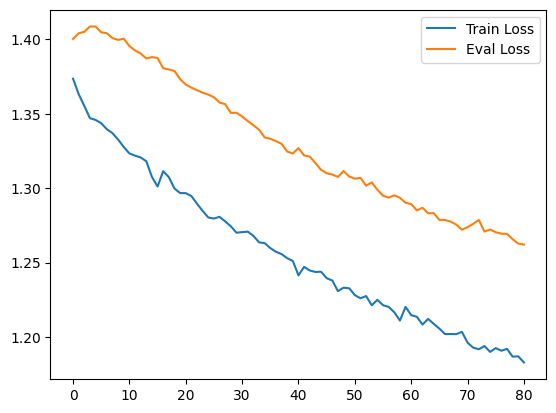

Epoch 82/100 | Training Loss: 1.1794 | Validation Loss: 1.2607


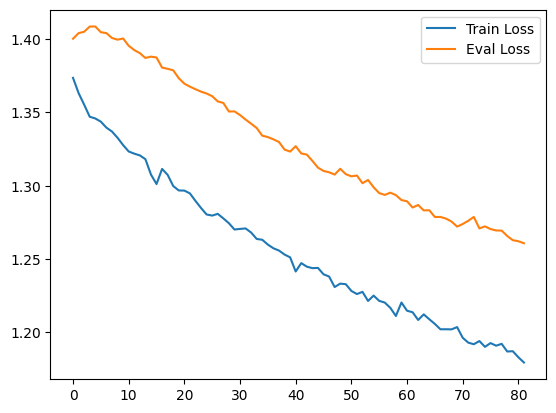

Epoch 83/100 | Training Loss: 1.1785 | Validation Loss: 1.2647


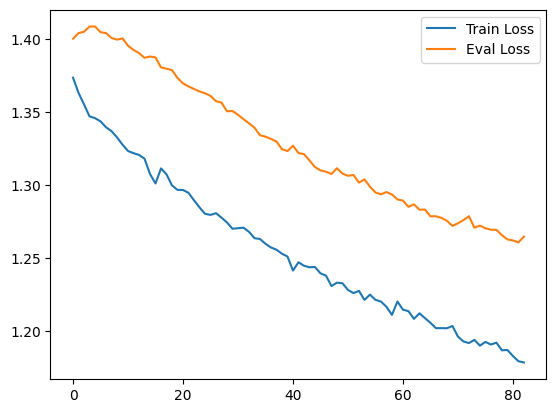

Epoch 84/100 | Training Loss: 1.1812 | Validation Loss: 1.2636


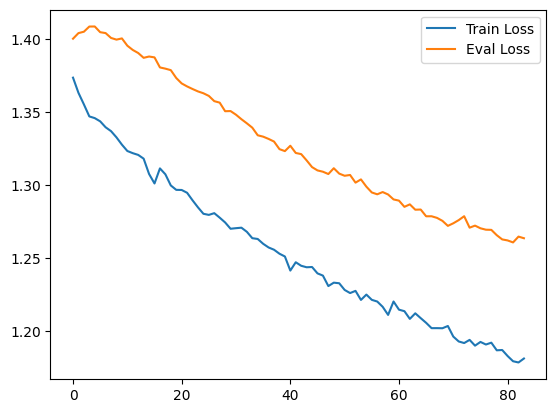

Epoch 85/100 | Training Loss: 1.1778 | Validation Loss: 1.2589


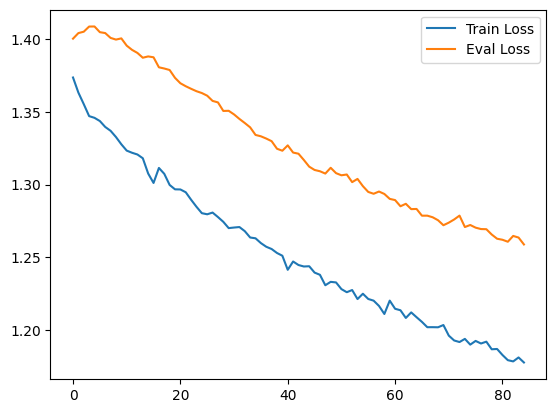

Epoch 86/100 | Training Loss: 1.1746 | Validation Loss: 1.2604


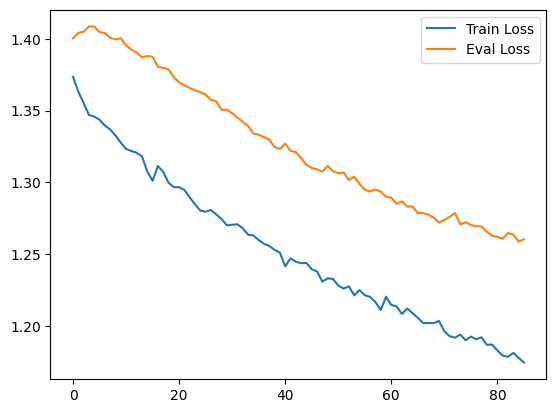

Epoch 87/100 | Training Loss: 1.1752 | Validation Loss: 1.2609


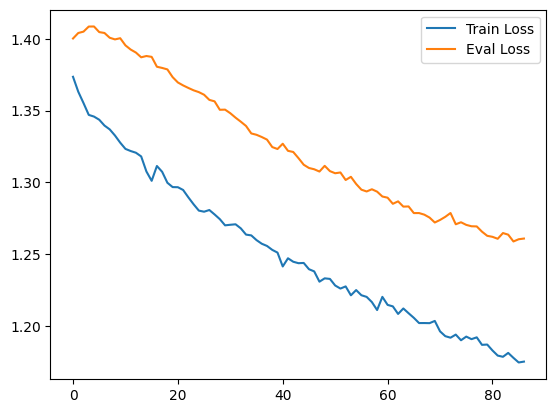

Epoch 88/100 | Training Loss: 1.1718 | Validation Loss: 1.2602


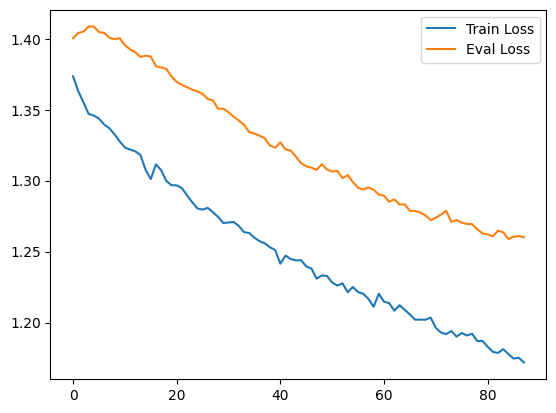

Epoch 89/100 | Training Loss: 1.1822 | Validation Loss: 1.2562


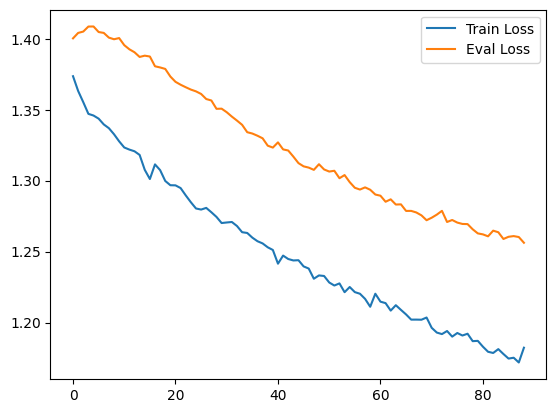

Epoch 90/100 | Training Loss: 1.1740 | Validation Loss: 1.2551


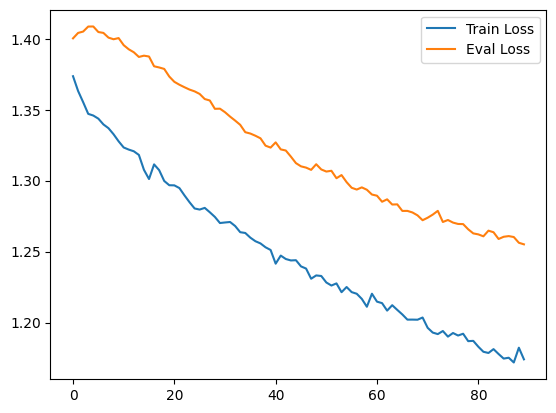

Epoch 91/100 | Training Loss: 1.1722 | Validation Loss: 1.2523


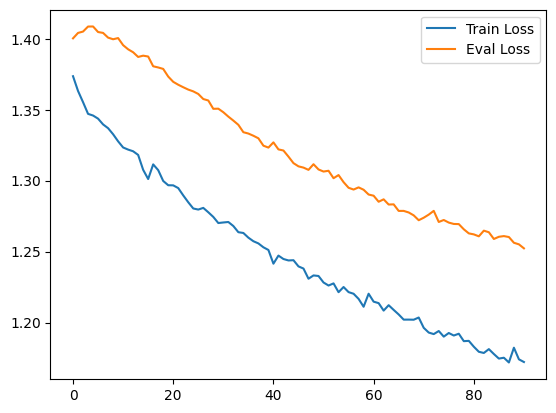

Epoch 92/100 | Training Loss: 1.1707 | Validation Loss: 1.2500


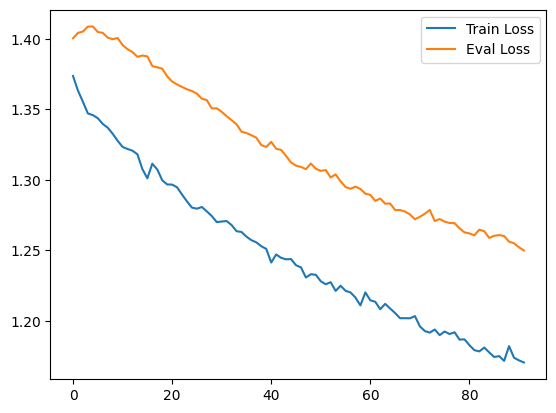

Epoch 93/100 | Training Loss: 1.1698 | Validation Loss: 1.2491


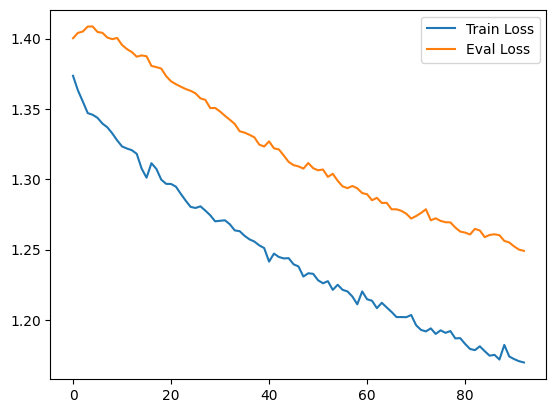

Epoch 94/100 | Training Loss: 1.1662 | Validation Loss: 1.2498


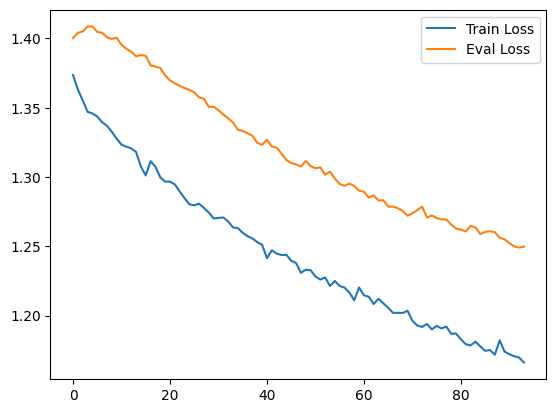

Epoch 95/100 | Training Loss: 1.1677 | Validation Loss: 1.2501


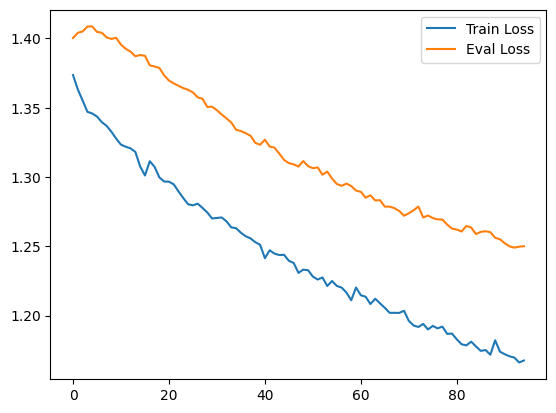

Epoch 96/100 | Training Loss: 1.1681 | Validation Loss: 1.2456


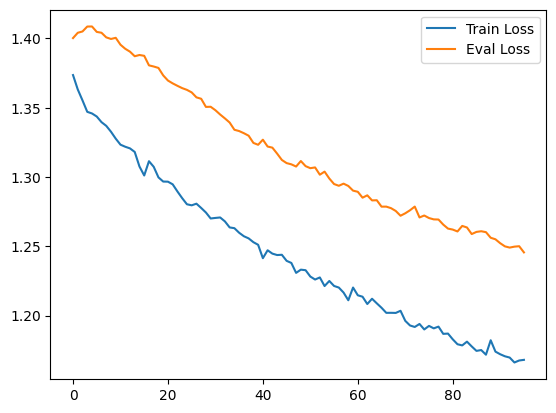

Epoch 97/100 | Training Loss: 1.1684 | Validation Loss: 1.2459


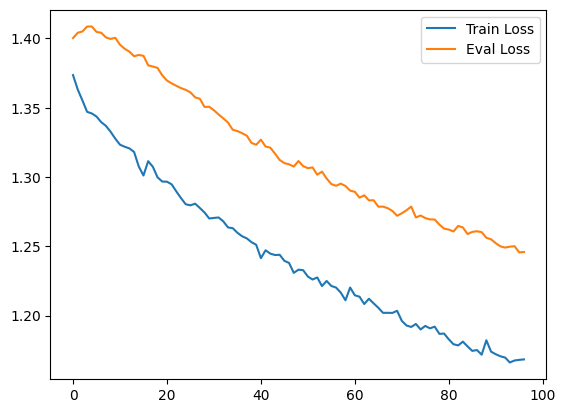

Epoch 98/100 | Training Loss: 1.1651 | Validation Loss: 1.2437


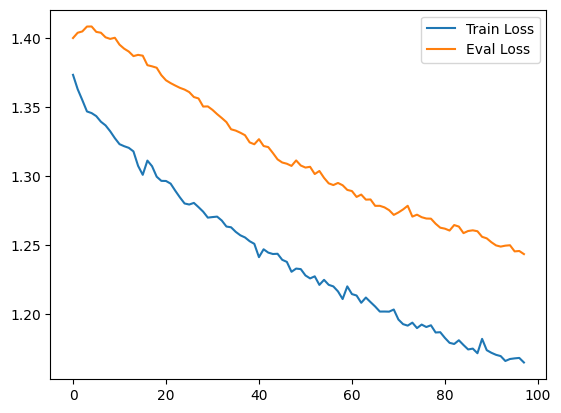

Epoch 99/100 | Training Loss: 1.1656 | Validation Loss: 1.2422


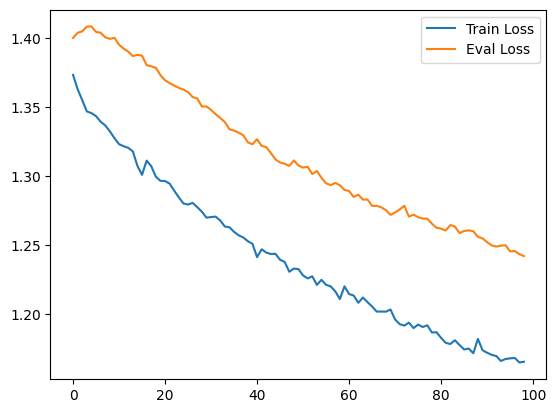

Epoch 100/100 | Training Loss: 1.1630 | Validation Loss: 1.2414


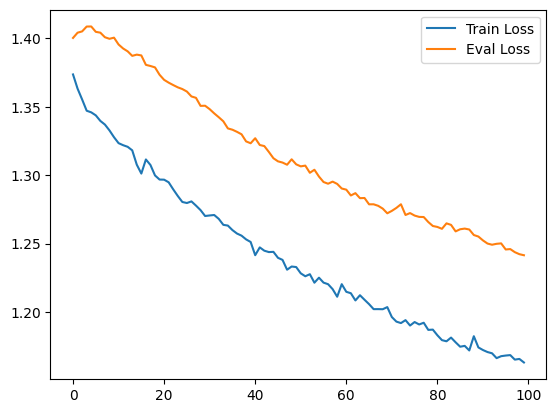

In [ ]:
num_epochs = 100

train_losses = []
valid_losses = []
all_predictions = []
all_labels = []

lr = 0.00001
wd = 0.1
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(xception_model.parameters(), lr=lr, weight_decay=wd)

for epoch in range(num_epochs):
    xception_model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Train Batch: ", leave=bool(epoch == num_epochs)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = xception_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    xception_model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Batch: ", leave=bool(epoch == num_epochs)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = xception_model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    pd.DataFrame({"Train Loss": train_losses, "Eval Loss": valid_losses}, index=list(range(len(train_losses)))).plot()
    plt.show()
    # display.display(plt.gcf())
    # display.clear_output(wait=True)

with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_xception_lr_{lr}_wd_{wd}_train_losses.pkl"), 'wb') as f:
    pickle.dump(train_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_xception_lr_{lr}_wd_{wd}_valid_losses.pkl"), 'wb') as f:
    pickle.dump(valid_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_xception_lr_{lr}_wd_{wd}_predictions.pkl"), 'wb') as f:
    pickle.dump(all_predictions, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_xception_lr_{lr}_wd_{wd}_labels.pkl"), 'wb') as f:
    pickle.dump(all_labels, f)

transfer_learning_xception_model_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_xception_lr_{lr}_wd_{wd}.pt")
torch.save(xception_model.state_dict(), transfer_learning_xception_model_path)

In [ ]:
xception_model.eval()

total_correct = 0
total_samples = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = xception_model(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

100%|██████████| 27/27 [12:44<00:00, 28.30s/it]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.33      0.25      0.28       179
           1       0.00      0.00      0.00        12
           2       0.64      0.70      0.67       640
           3       0.47      0.46      0.46       448

    accuracy                           0.55      1279
   macro avg       0.36      0.35      0.35      1279
weighted avg       0.53      0.55      0.54      1279



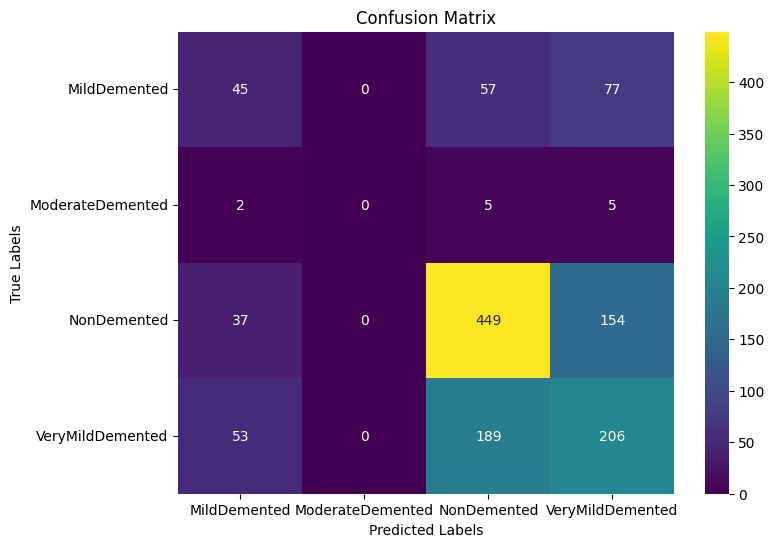

In [ ]:
print(classification_report(true_labels, predicted_labels))

confusion_mat = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap="viridis", fmt="d",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Comparing the classification report of the 4-class FC layer first fine-tuning experiment to the SVM classifier results:
 - Precision - the precision values for most classes in the 4-class FC layer experiment are slightly lower compared to the SVM classifier. The precision for the "ModerateDemented" class is 0 in the 4-class FC layer experiment, while the SVM classifier has a higher precision of 0.56 for that not common class.
 - Recall - the recall values for most classes in the 4-class FC layer experiment are similar or slightly lower compared to the SVM classifier. The recall for the "ModerateDemented" class is 0.00 in the 4-class FC layer experiment, while the SVM classifier has a higher recall of 0.42 for that class.
 - F1-score - the F1-scores for most classes in the 4-class FC layer experiment are similar or slightly lower compared to the SVM classifier. The F1-score for the "ModerateDemented" class is 0.00 in the 4-class FC layer experiment, while the SVM classifier has an F1-score of 0.48 for that class.- Accuracy - the accuracy of the 4-class FC layer first fine-tuning experiment is slightly lower at 0.55 compared to the SVM classifier accuracy of 0.57.
 - Macro Avg - the macro average precision, recall, and F1-score for the 4-class FC layer experiment are 0.36, 0.35, and 0.35, respectively. This indicates that the SVM classifier performs better on average across all classes compared to the 4-class FC layer experiment.
 - Weighted Avg - the weighted average precision, recall, and F1-score for the 4-class FC layer experiment are 0.53, 0.55, and 0.54, respectively. This suggests that the SVM classifier achieves better overall weighted performance, taking into account class imbalances, compared to the 4-class FC layer experiment.

In summary, when considering the macro and weighted averages, the SVM classifier outperforms the 4-class FC layer first fine-tuning experiment. The SVM classifier demonstrates better average precision, recall, and F1-score across all classes and achieves superior overall weighted performance. However, both models may still require further optimization and fine-tuning to improve their classification performance for Alzheimer's disease.

In the next experiment we use the same hyper parameters but we utilized the data loader with the weighted sampler.

In [ ]:
xception_model = xception()
xception_model.load_state_dict(pretrained_model_state_dict)

xception_model.fc = nn.Linear(2048, 4)
xception_model = xception_model.to(device)
list(xception_model.children())[-1]

Linear(in_features=2048, out_features=4, bias=True)

Epoch 1/100 | Training Loss: 1.3924 | Validation Loss: 1.3881


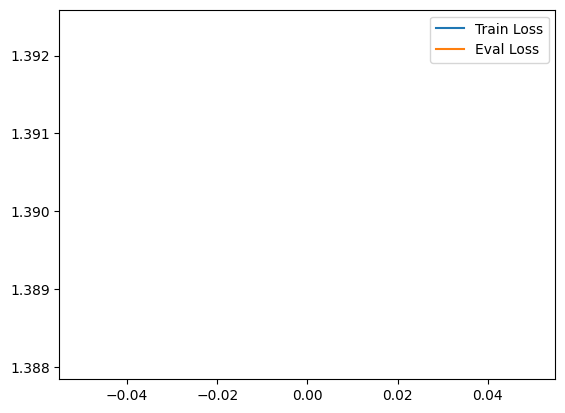

Epoch 2/100 | Training Loss: 1.3773 | Validation Loss: 1.3766


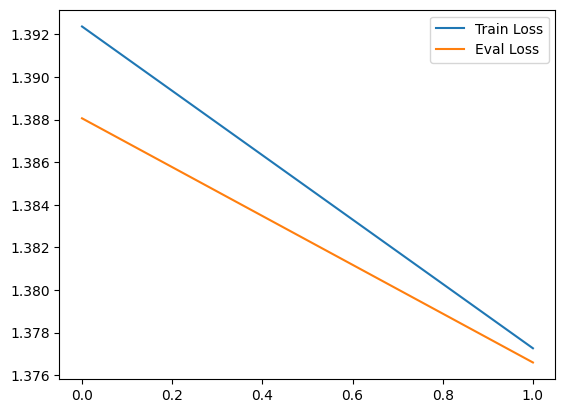

Epoch 3/100 | Training Loss: 1.3600 | Validation Loss: 1.3612


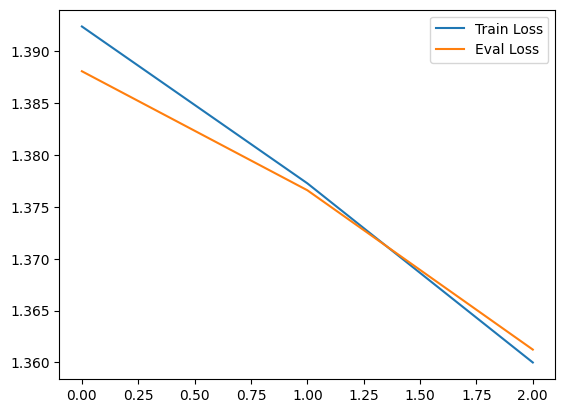

Epoch 4/100 | Training Loss: 1.3435 | Validation Loss: 1.3443


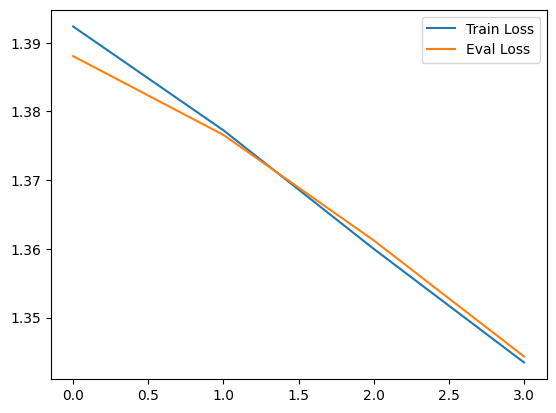

Epoch 5/100 | Training Loss: 1.3175 | Validation Loss: 1.3243


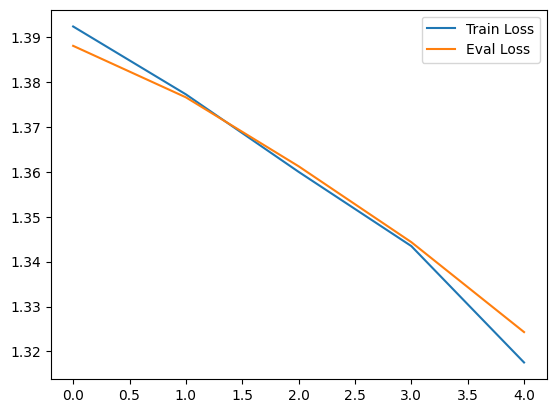

Epoch 6/100 | Training Loss: 1.2905 | Validation Loss: 1.3050


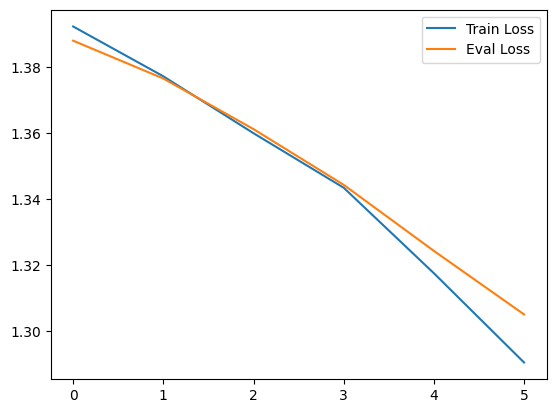

Epoch 7/100 | Training Loss: 1.2547 | Validation Loss: 1.2815


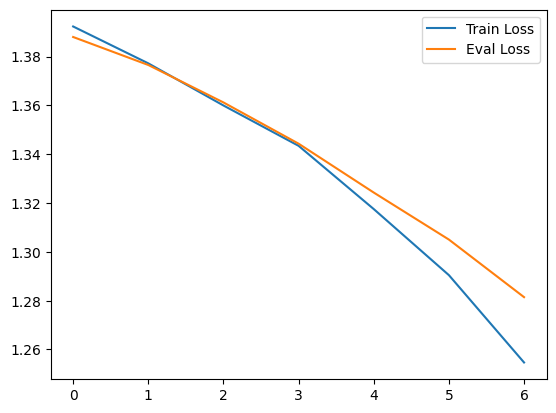

Epoch 8/100 | Training Loss: 1.2114 | Validation Loss: 1.2531


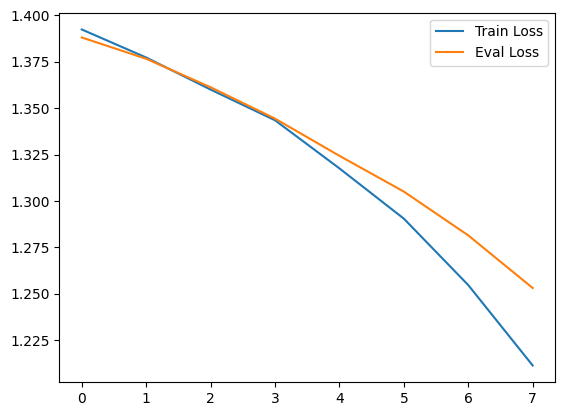

Epoch 9/100 | Training Loss: 1.1622 | Validation Loss: 1.2227


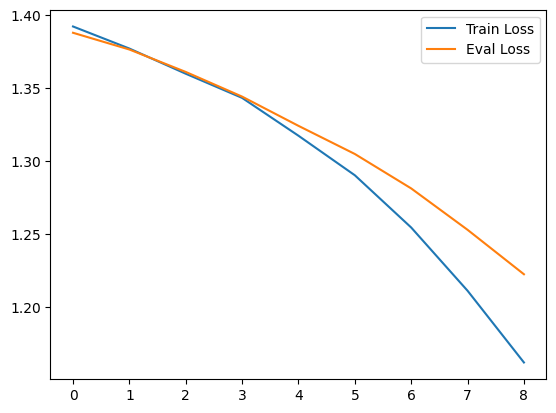

Epoch 10/100 | Training Loss: 1.0958 | Validation Loss: 1.1869


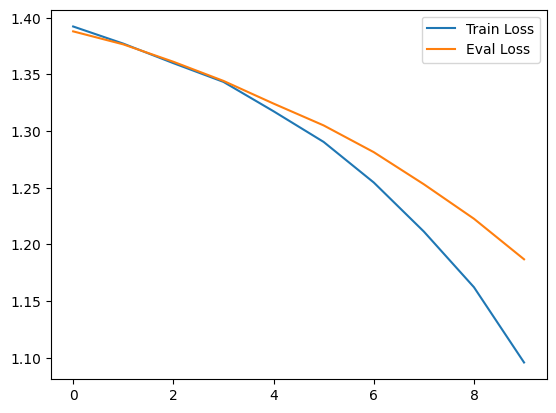

Epoch 11/100 | Training Loss: 1.0340 | Validation Loss: 1.1495


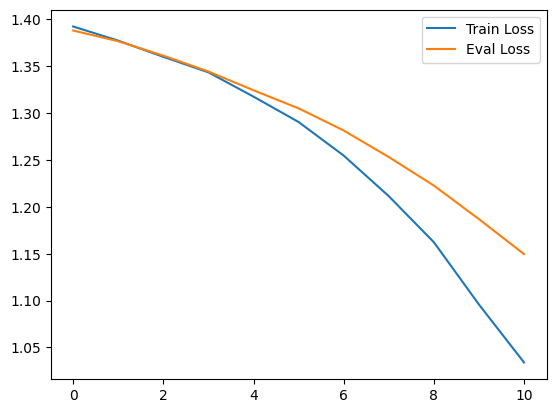

Epoch 12/100 | Training Loss: 0.9599 | Validation Loss: 1.1069


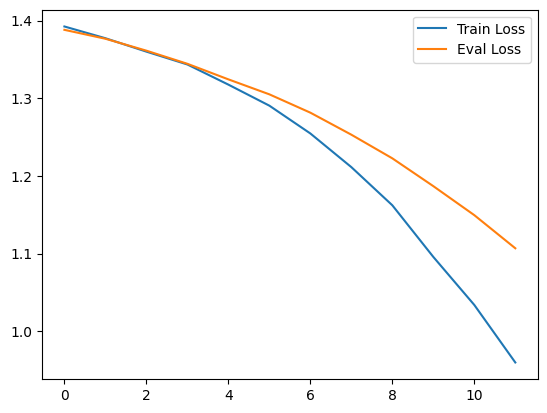

Epoch 13/100 | Training Loss: 0.8868 | Validation Loss: 1.0715


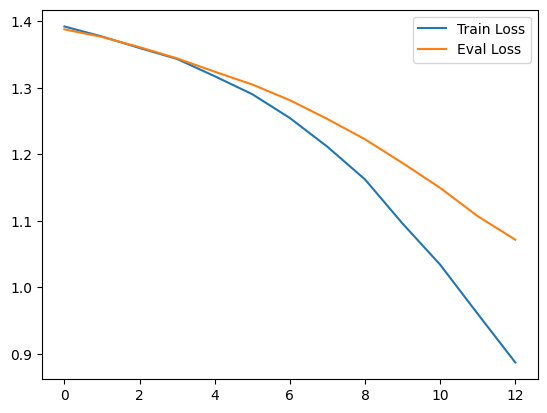

Epoch 14/100 | Training Loss: 0.8608 | Validation Loss: 1.0363


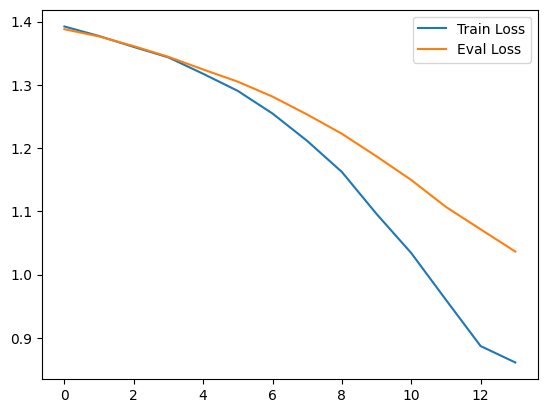

Epoch 15/100 | Training Loss: 0.8028 | Validation Loss: 1.0017


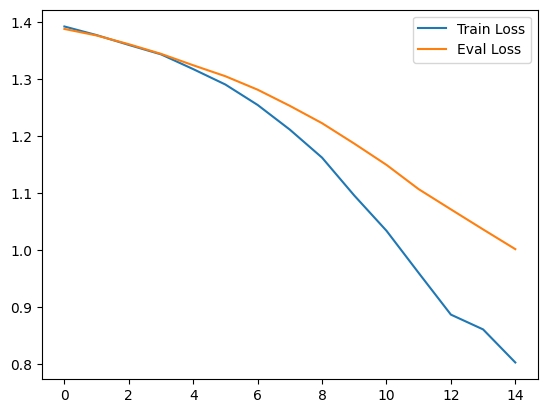

Epoch 16/100 | Training Loss: 0.7730 | Validation Loss: 0.9759


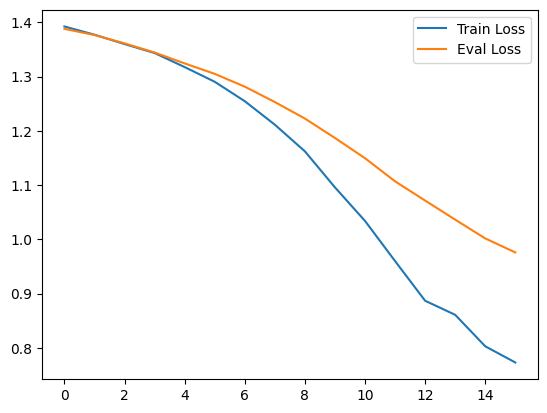

Epoch 17/100 | Training Loss: 0.7288 | Validation Loss: 0.9624


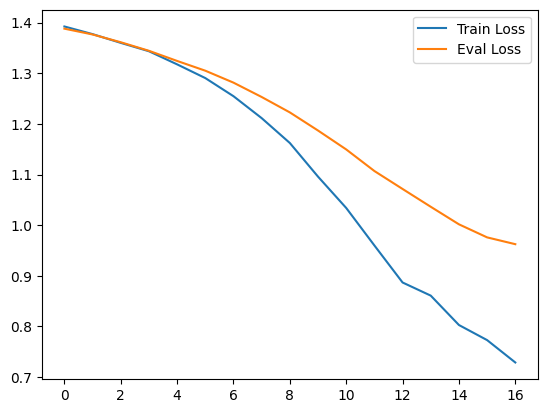

Epoch 18/100 | Training Loss: 0.7076 | Validation Loss: 0.9328


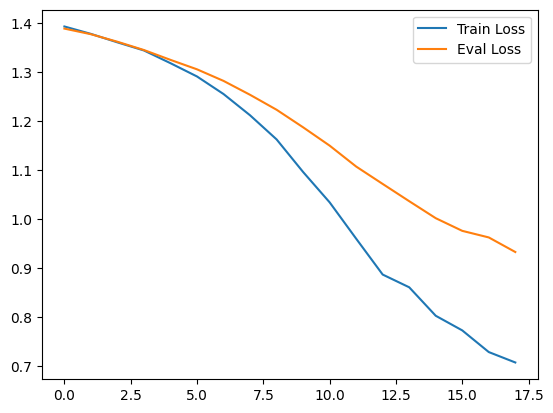

Epoch 19/100 | Training Loss: 0.6598 | Validation Loss: 0.9054


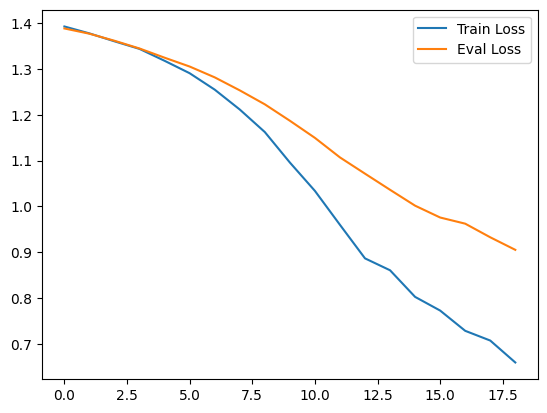

Epoch 20/100 | Training Loss: 0.6171 | Validation Loss: 0.8902


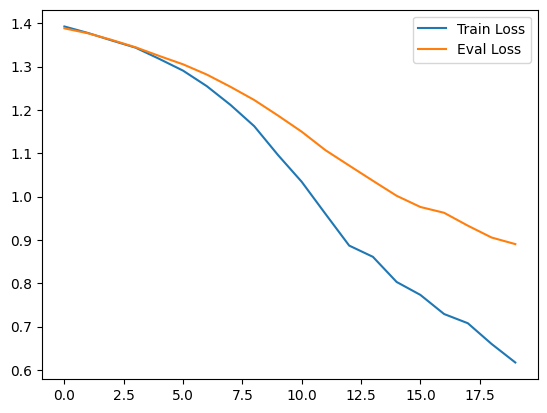

Epoch 21/100 | Training Loss: 0.5822 | Validation Loss: 0.8635


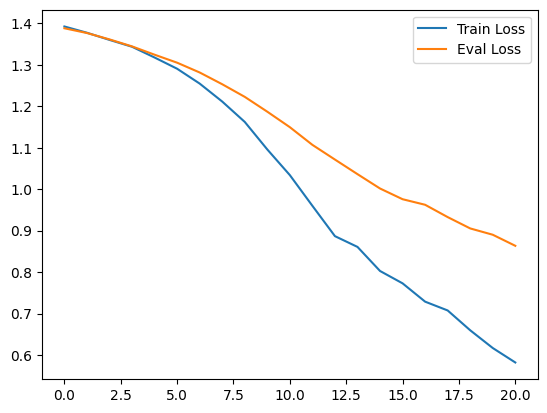

Epoch 22/100 | Training Loss: 0.5307 | Validation Loss: 0.8494


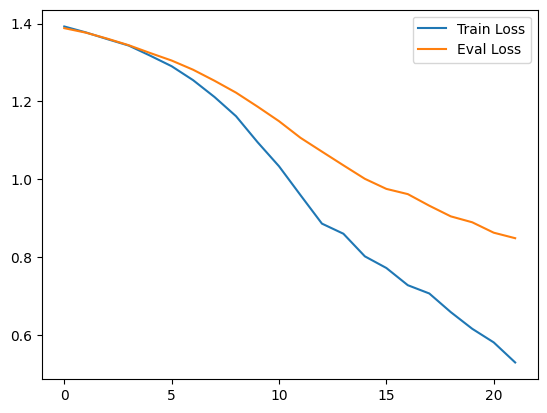

Epoch 23/100 | Training Loss: 0.4852 | Validation Loss: 0.8333


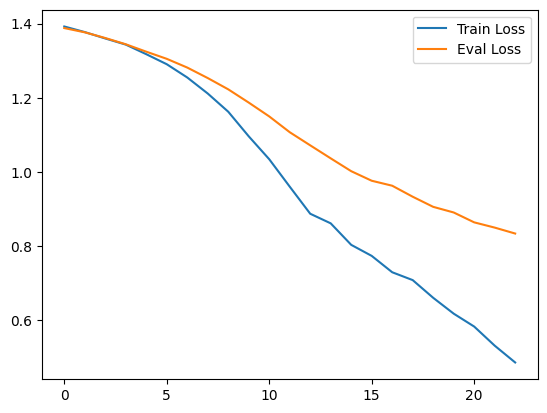

Epoch 24/100 | Training Loss: 0.4470 | Validation Loss: 0.8220


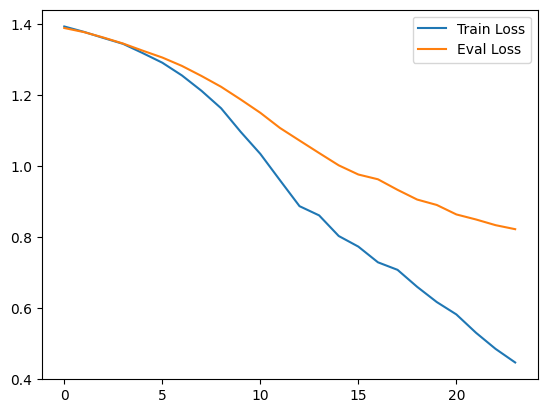

Epoch 25/100 | Training Loss: 0.4141 | Validation Loss: 0.8131


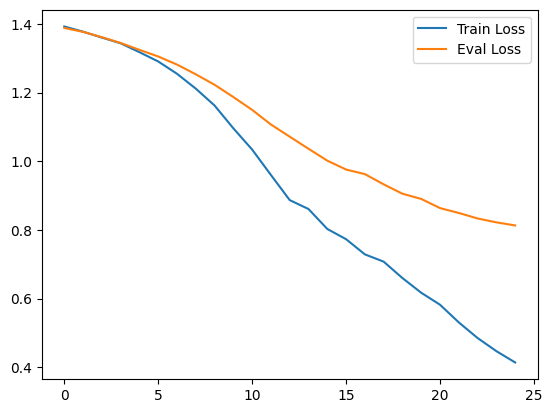

Epoch 26/100 | Training Loss: 0.3762 | Validation Loss: 0.7895


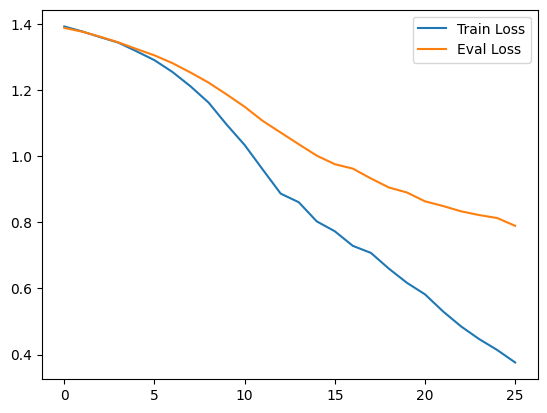

Epoch 27/100 | Training Loss: 0.3345 | Validation Loss: 0.7955


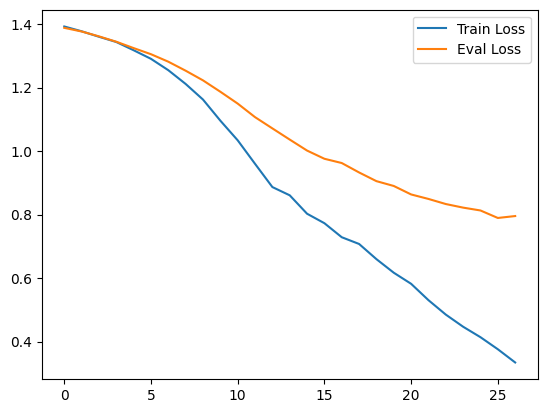

Epoch 28/100 | Training Loss: 0.3019 | Validation Loss: 0.7888


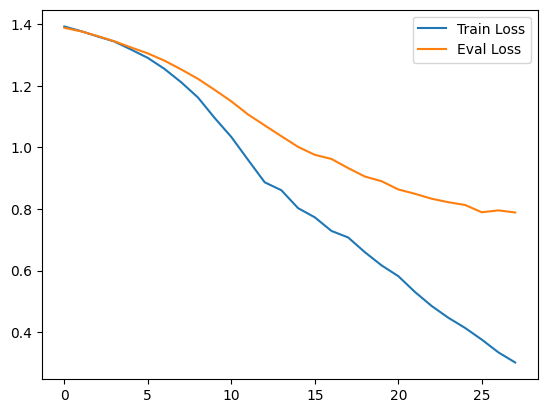

Epoch 29/100 | Training Loss: 0.2698 | Validation Loss: 0.8006


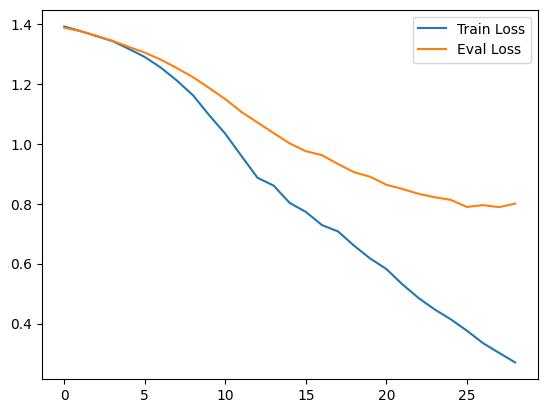

Epoch 30/100 | Training Loss: 0.2326 | Validation Loss: 0.7908


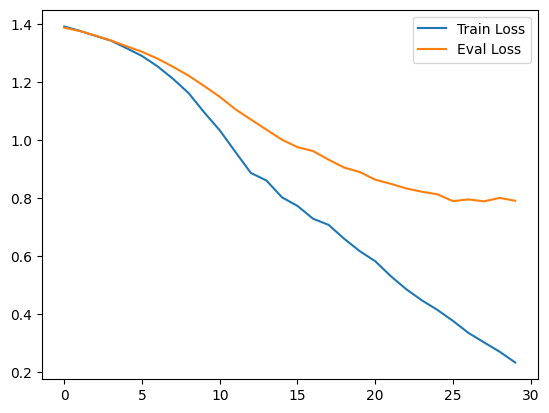

Epoch 31/100 | Training Loss: 0.1987 | Validation Loss: 0.7823


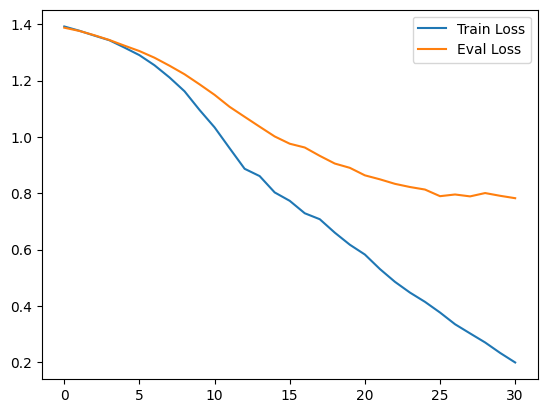

Epoch 32/100 | Training Loss: 0.1682 | Validation Loss: 0.7842


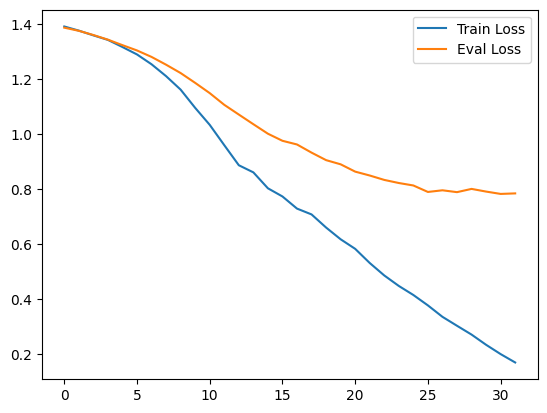

Epoch 33/100 | Training Loss: 0.1414 | Validation Loss: 0.8113


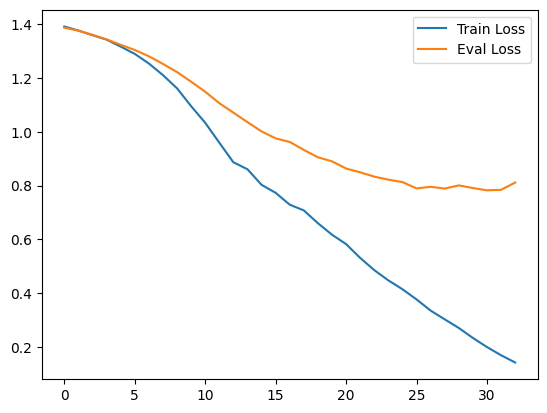

Epoch 34/100 | Training Loss: 0.1263 | Validation Loss: 0.8156


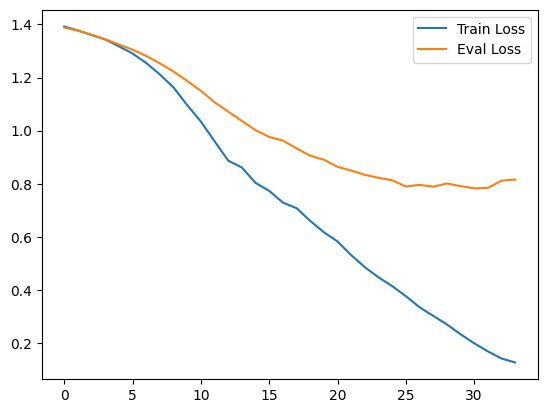

Epoch 35/100 | Training Loss: 0.1017 | Validation Loss: 0.8329


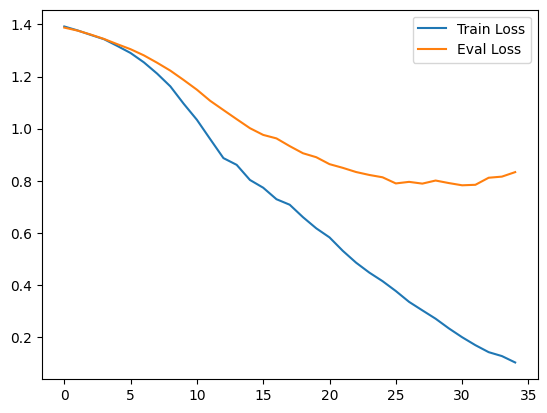

Epoch 36/100 | Training Loss: 0.0970 | Validation Loss: 0.8402


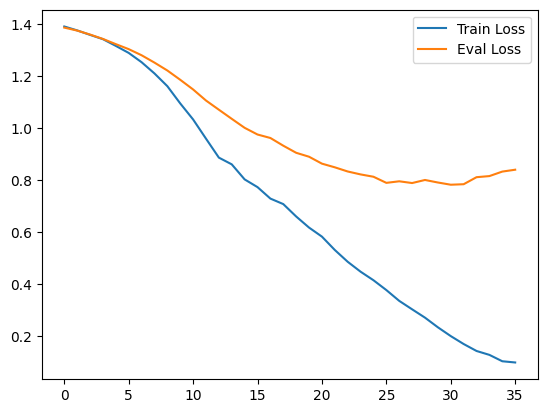

Epoch 37/100 | Training Loss: 0.0814 | Validation Loss: 0.8236


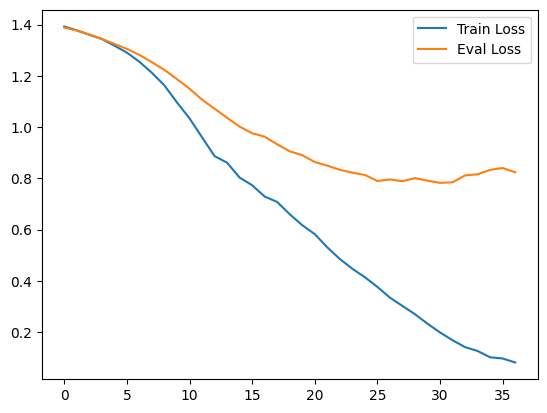

Epoch 38/100 | Training Loss: 0.0733 | Validation Loss: 0.8563


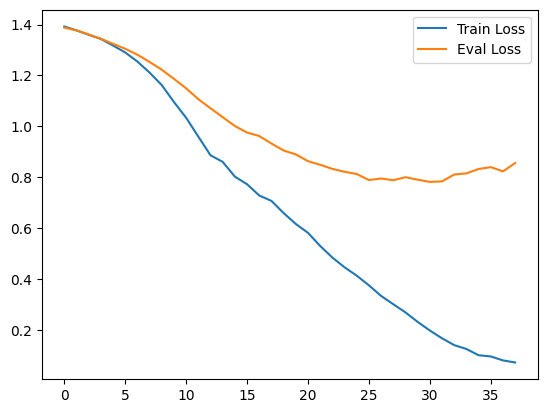

Epoch 39/100 | Training Loss: 0.0676 | Validation Loss: 0.8557


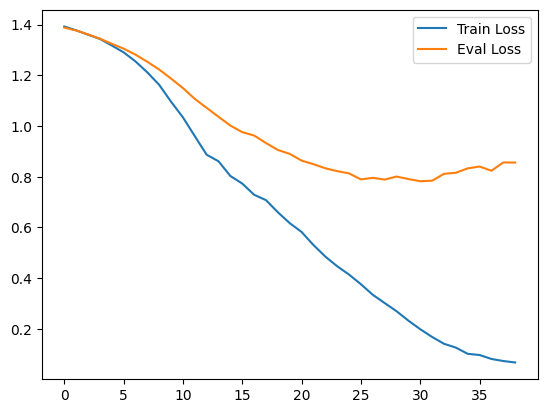

Epoch 40/100 | Training Loss: 0.0631 | Validation Loss: 0.8456


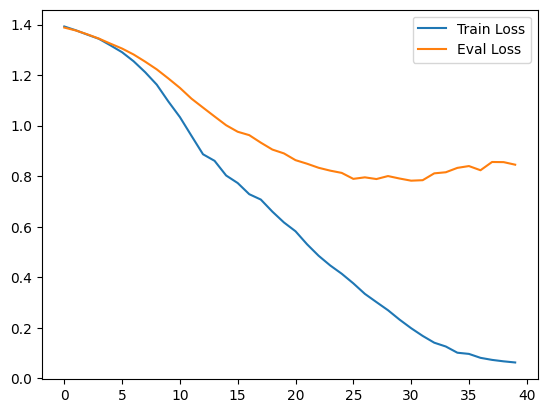

Epoch 41/100 | Training Loss: 0.0580 | Validation Loss: 0.8630


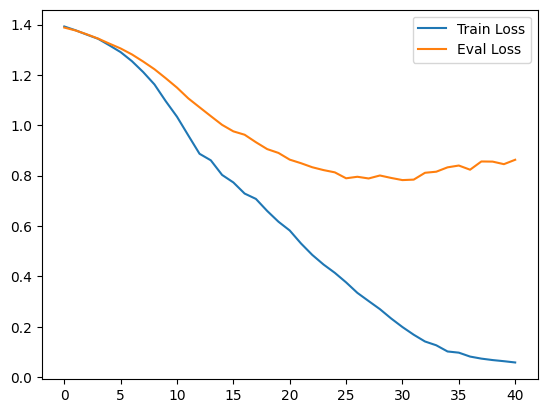

Epoch 42/100 | Training Loss: 0.0544 | Validation Loss: 0.8461


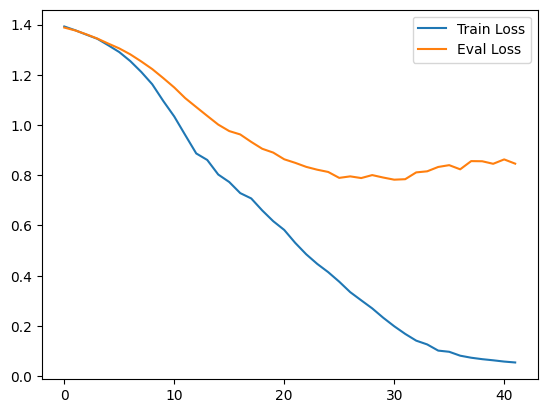

Epoch 43/100 | Training Loss: 0.0476 | Validation Loss: 0.8633


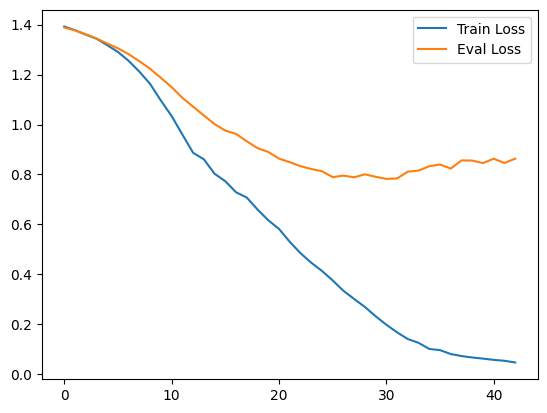

KeyboardInterrupt: ignored

In [ ]:
num_epochs = 100

train_losses = []
valid_losses = []
all_predictions = []
all_labels = []

lr = 0.00001
wd = 0.1
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(xception_model.parameters(), lr=lr, weight_decay=wd)

for epoch in range(num_epochs):
    xception_model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Train Batch: ", leave=bool(epoch == num_epochs)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = xception_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    xception_model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Batch: ", leave=bool(epoch == num_epochs)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = xception_model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    pd.DataFrame({"Train Loss": train_losses, "Eval Loss": valid_losses}, index=list(range(len(train_losses)))).plot()
    plt.show()
    # display.display(plt.gcf())
    # display.clear_output(wait=True)

with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_train_losses.pkl"), 'wb') as f:
    pickle.dump(train_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_valid_losses.pkl"), 'wb') as f:
    pickle.dump(valid_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_predictions.pkl"), 'wb') as f:
    pickle.dump(all_predictions, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_labels.pkl"), 'wb') as f:
    pickle.dump(all_labels, f)

transfer_learning_xception_model_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}.pt")
torch.save(xception_model.state_dict(), transfer_learning_xception_model_path)

We early stop the model training because we see the model is overfitting to the training data around the 25th epoch.
We used higher regularization for the next experiment by increasing the weight decay from 0.1 to 0.2.

In [ ]:
# with more regularization and weighted sampler
xception_model = xception()
xception_model.load_state_dict(pretrained_model_state_dict)

xception_model.fc = nn.Linear(2048, 4)
xception_model = xception_model.to(device)
list(xception_model.children())[-1]

Linear(in_features=2048, out_features=4, bias=True)

Epoch 1/20 | Training Loss: 1.3740 | Validation Loss: 1.4057


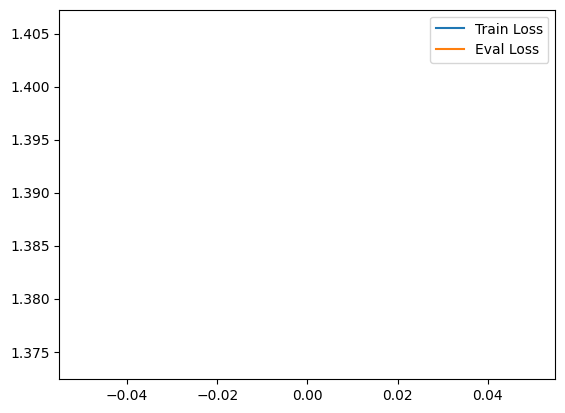

Epoch 2/20 | Training Loss: 1.3576 | Validation Loss: 1.3914


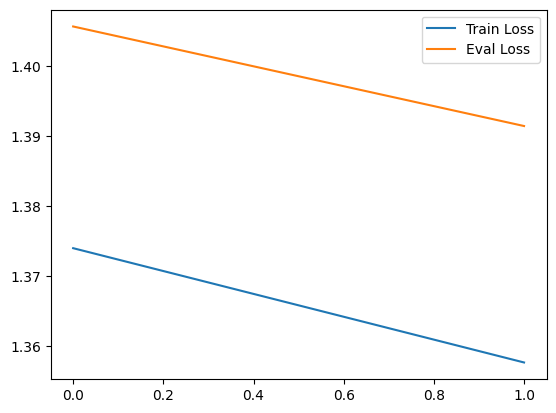

Epoch 3/20 | Training Loss: 1.3458 | Validation Loss: 1.3721


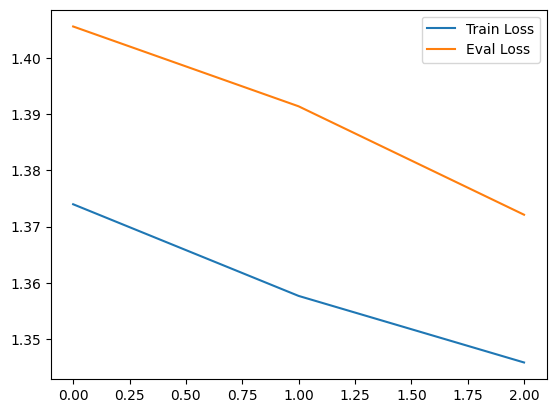

Epoch 4/20 | Training Loss: 1.3254 | Validation Loss: 1.3593


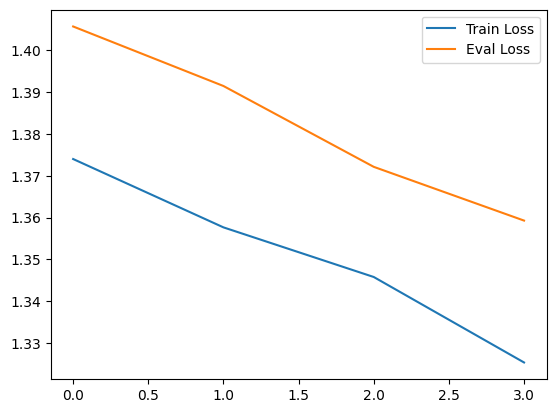

Epoch 5/20 | Training Loss: 1.3036 | Validation Loss: 1.3328


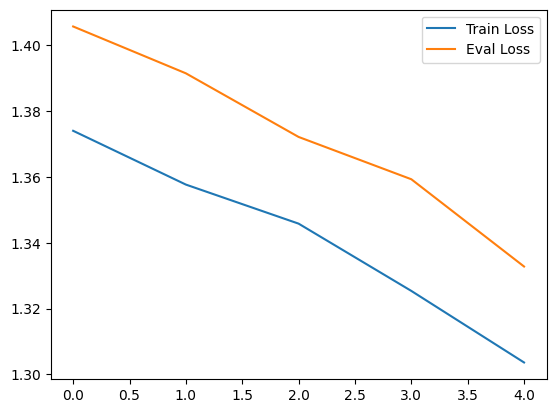

Epoch 6/20 | Training Loss: 1.2703 | Validation Loss: 1.3250


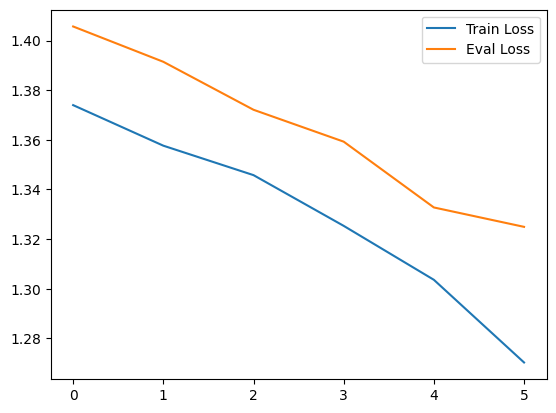

Epoch 7/20 | Training Loss: 1.2300 | Validation Loss: 1.2978


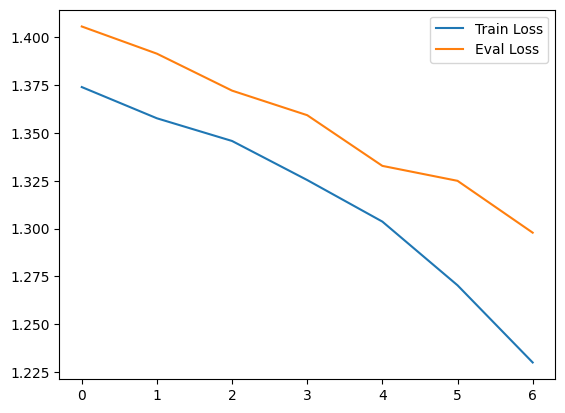

Epoch 8/20 | Training Loss: 1.1846 | Validation Loss: 1.2537


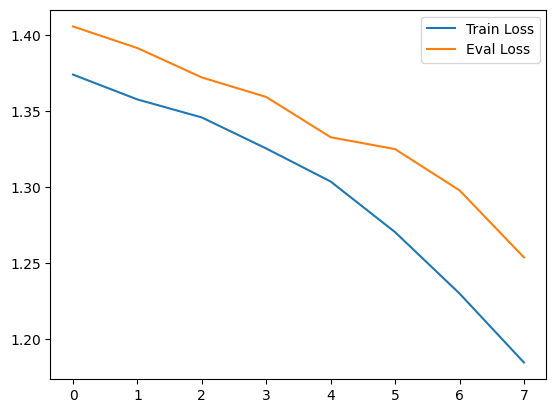

Epoch 9/20 | Training Loss: 1.1254 | Validation Loss: 1.2284


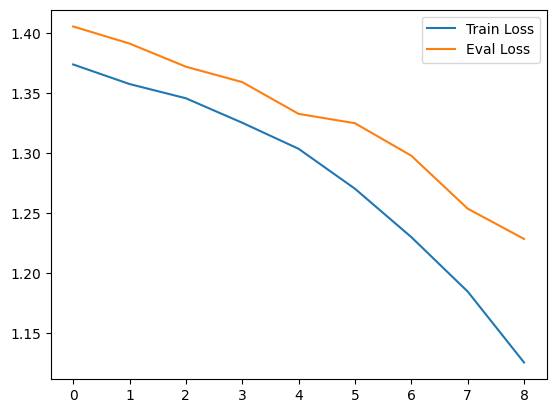

Epoch 10/20 | Training Loss: 1.0642 | Validation Loss: 1.1975


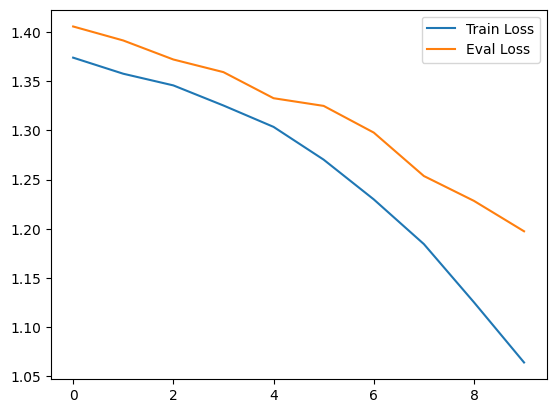

Epoch 11/20 | Training Loss: 1.0104 | Validation Loss: 1.1737


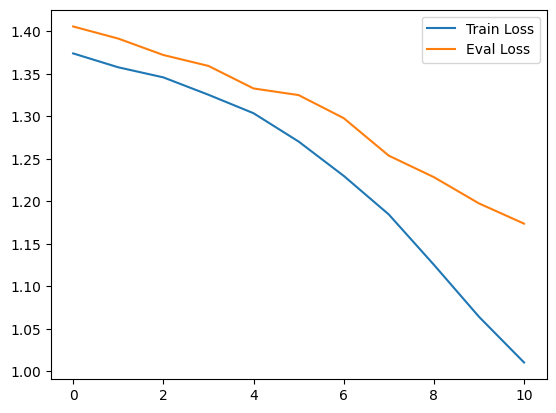

Epoch 12/20 | Training Loss: 0.9671 | Validation Loss: 1.1340


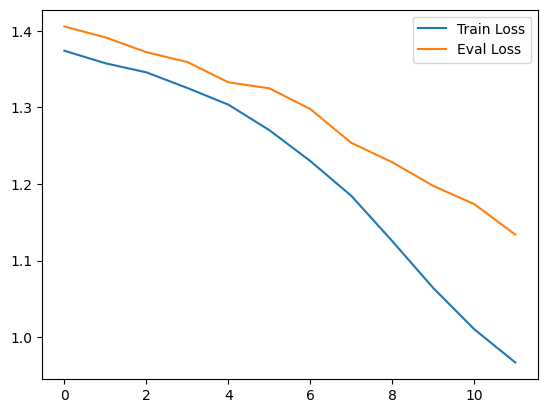

Epoch 13/20 | Training Loss: 0.9406 | Validation Loss: 1.1170


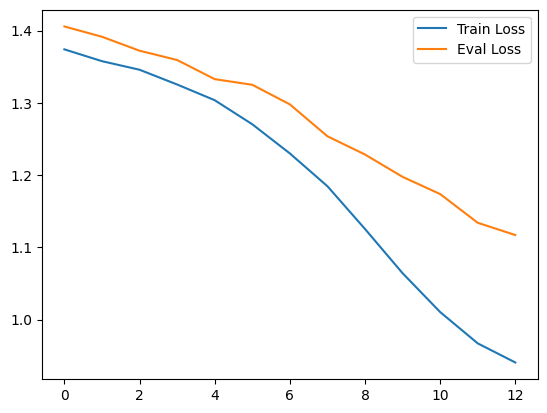

Epoch 14/20 | Training Loss: 0.9022 | Validation Loss: 1.0841


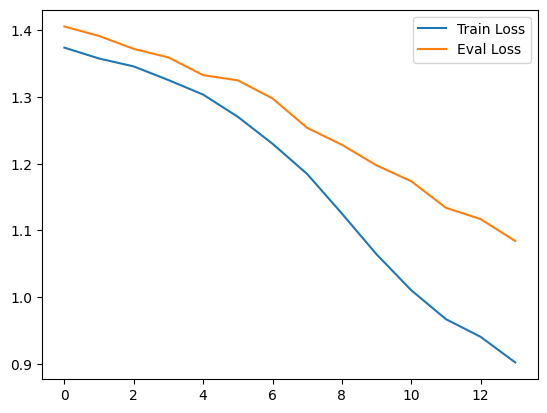

Epoch 15/20 | Training Loss: 0.8698 | Validation Loss: 1.0770


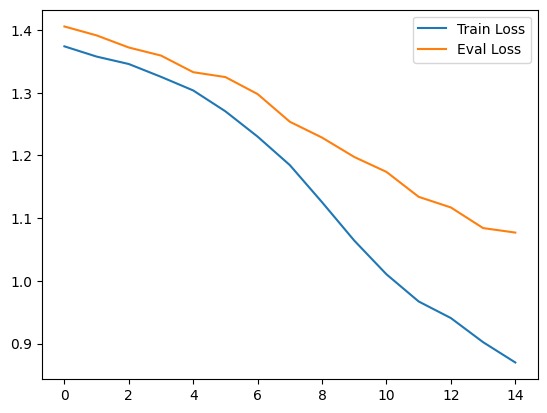

Epoch 16/20 | Training Loss: 0.8531 | Validation Loss: 1.0650


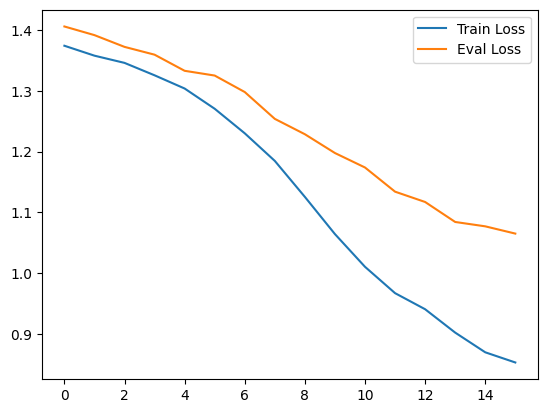

Epoch 17/20 | Training Loss: 0.8166 | Validation Loss: 1.0405


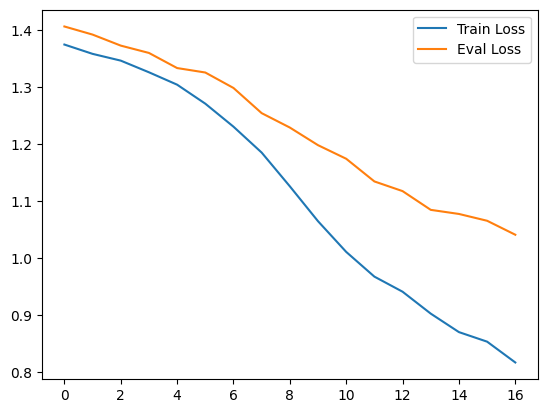

Epoch 18/20 | Training Loss: 0.7914 | Validation Loss: 1.0193


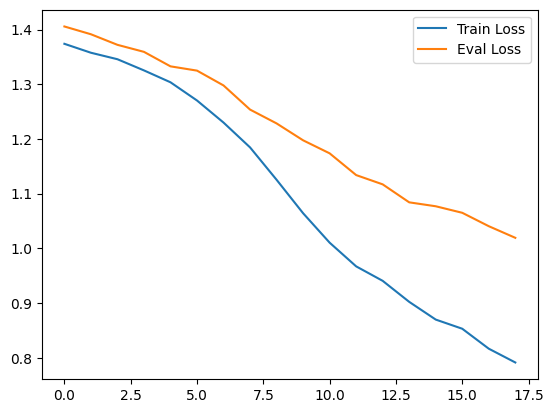

Epoch 19/20 | Training Loss: 0.7890 | Validation Loss: 1.0134


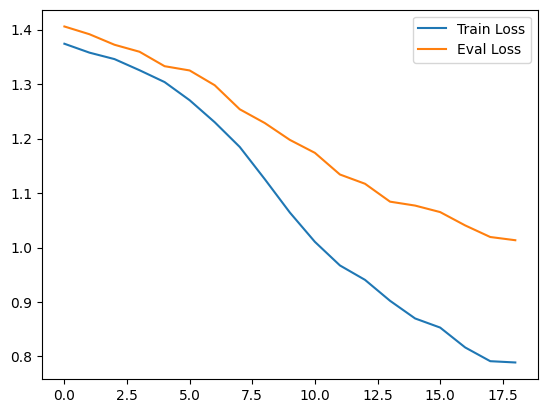

Epoch 20/20 | Training Loss: 0.7506 | Validation Loss: 1.0061


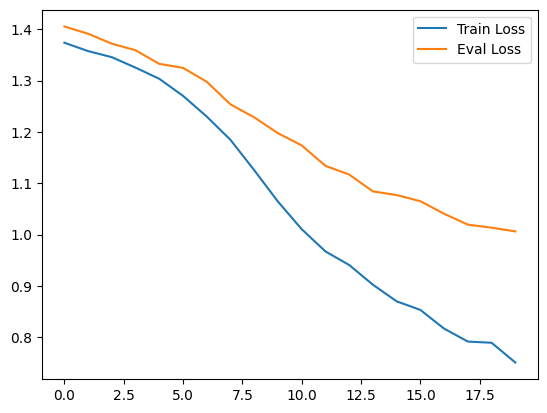

In [ ]:
num_epochs = 20

train_losses = []
valid_losses = []
all_predictions = []
all_labels = []

lr = 0.00001
wd = 0.2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xception_model.parameters(), lr=lr, weight_decay=wd)

for epoch in range(num_epochs):
    xception_model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Train Batch: ", leave=bool(epoch == num_epochs)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = xception_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    xception_model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Batch: ", leave=bool(epoch == num_epochs)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = xception_model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    pd.DataFrame({"Train Loss": train_losses, "Eval Loss": valid_losses}, index=list(range(len(train_losses)))).plot()
    plt.show()
    # display.display(plt.gcf())
    # display.clear_output(wait=True)

with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_train_losses.pkl"), 'wb') as f:
    pickle.dump(train_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_valid_losses.pkl"), 'wb') as f:
    pickle.dump(valid_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_predictions.pkl"), 'wb') as f:
    pickle.dump(all_predictions, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_labels.pkl"), 'wb') as f:
    pickle.dump(all_labels, f)

transfer_learning_xception_model_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}.pt")
torch.save(xception_model.state_dict(), transfer_learning_xception_model_path)

Running 20 more epochs.

Epoch 1/20 | Training Loss: 0.7510 | Validation Loss: 0.9749


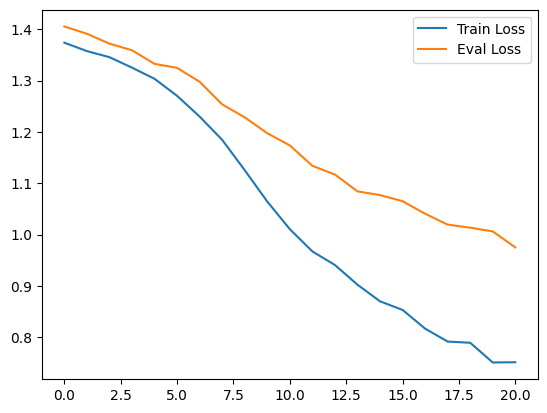

Epoch 2/20 | Training Loss: 0.7102 | Validation Loss: 0.9666


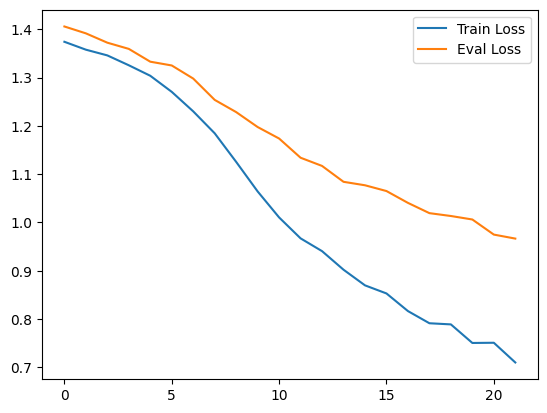

Epoch 3/20 | Training Loss: 0.6907 | Validation Loss: 0.9400


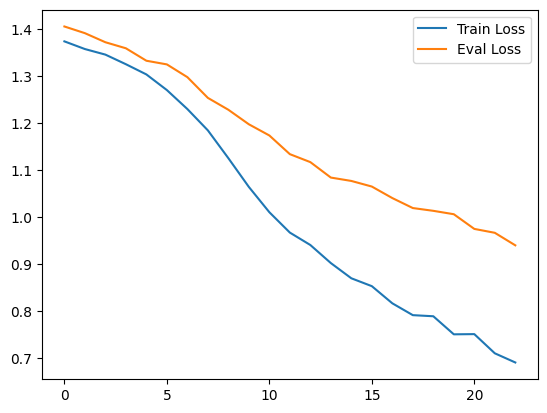

Epoch 4/20 | Training Loss: 0.6731 | Validation Loss: 0.9166


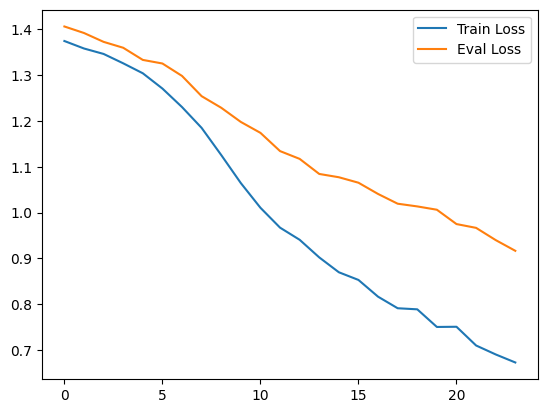

Epoch 5/20 | Training Loss: 0.6361 | Validation Loss: 0.9078


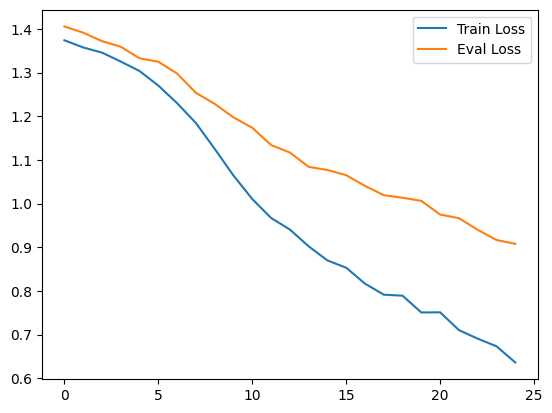

Epoch 6/20 | Training Loss: 0.6290 | Validation Loss: 0.8888


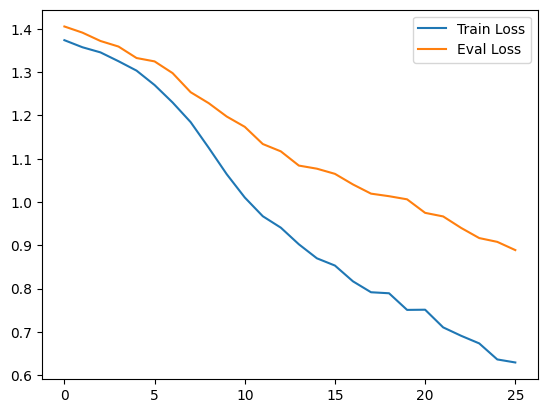

Epoch 7/20 | Training Loss: 0.5706 | Validation Loss: 0.8727


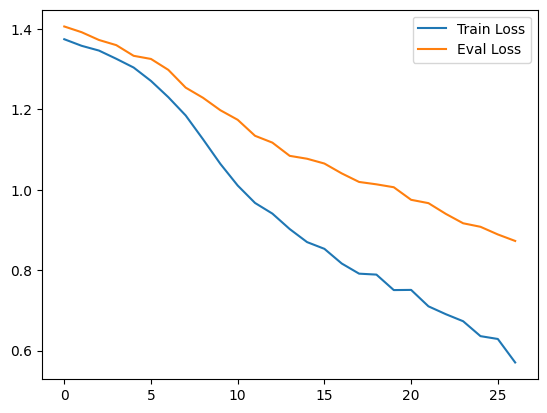

Epoch 8/20 | Training Loss: 0.5405 | Validation Loss: 0.8544


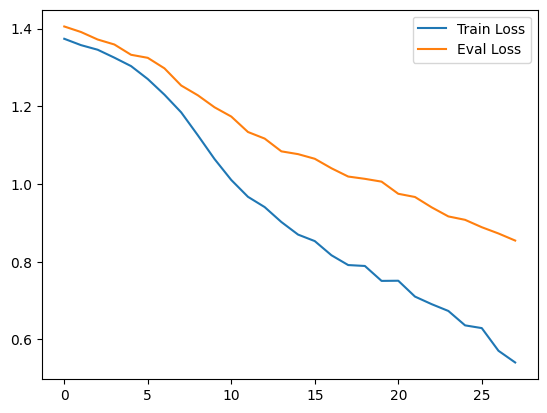

Epoch 9/20 | Training Loss: 0.5088 | Validation Loss: 0.8324


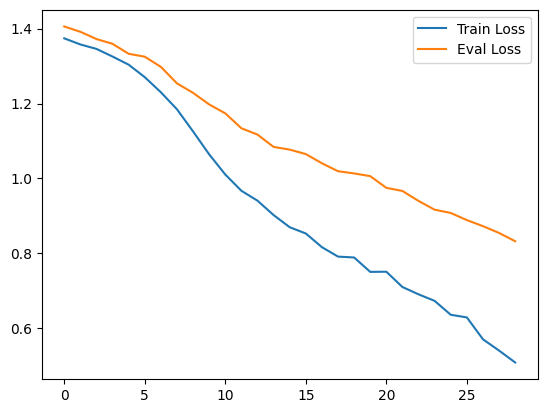

Epoch 10/20 | Training Loss: 0.4704 | Validation Loss: 0.8170


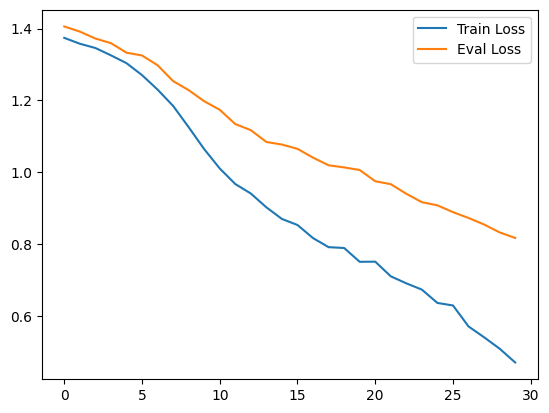

Epoch 11/20 | Training Loss: 0.4205 | Validation Loss: 0.7854


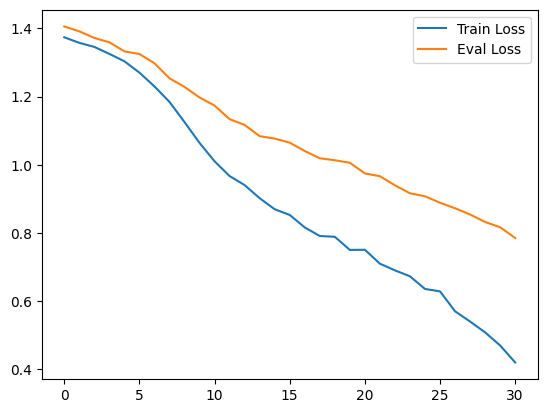

Epoch 12/20 | Training Loss: 0.3936 | Validation Loss: 0.7747


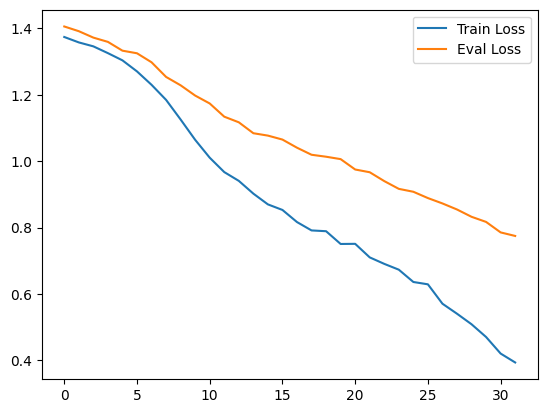

Epoch 13/20 | Training Loss: 0.3290 | Validation Loss: 0.7675


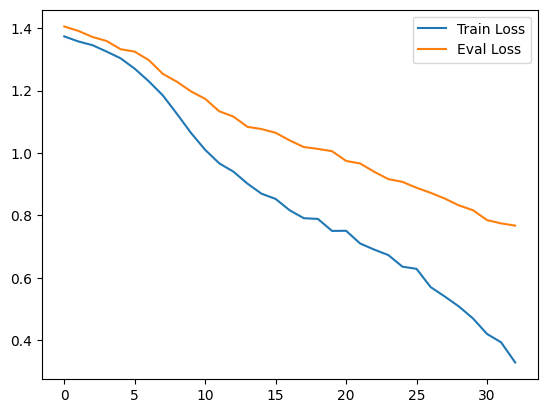

Epoch 14/20 | Training Loss: 0.2898 | Validation Loss: 0.7512


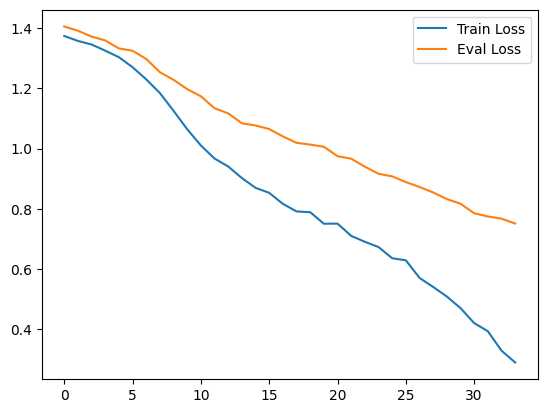

Epoch 15/20 | Training Loss: 0.2672 | Validation Loss: 0.7428


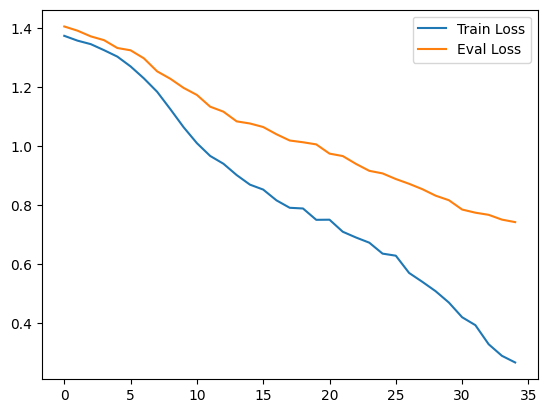

Epoch 16/20 | Training Loss: 0.2147 | Validation Loss: 0.7297


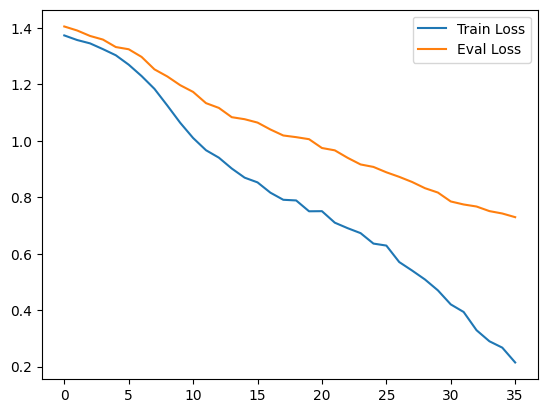

Epoch 17/20 | Training Loss: 0.1849 | Validation Loss: 0.7326


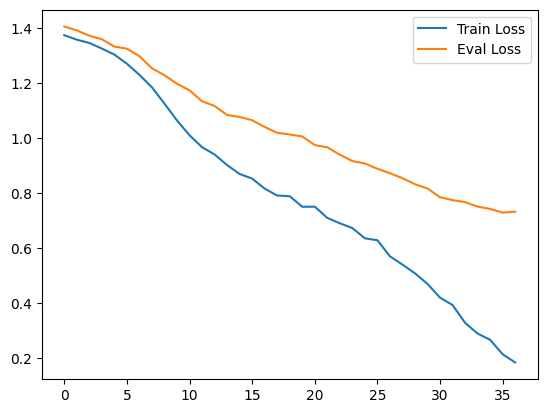

Epoch 18/20 | Training Loss: 0.1742 | Validation Loss: 0.7315


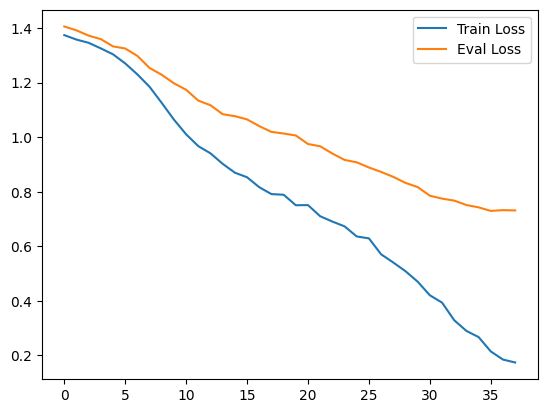

Epoch 19/20 | Training Loss: 0.1485 | Validation Loss: 0.7327


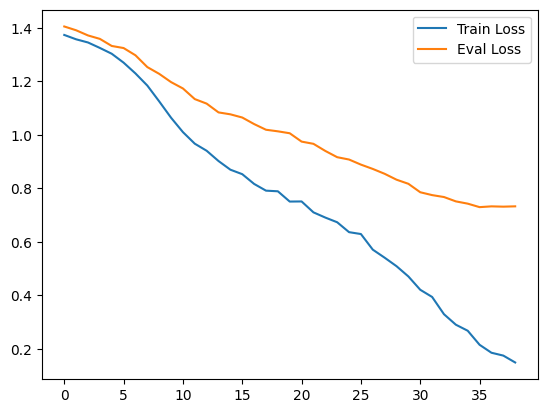

Epoch 20/20 | Training Loss: 0.1339 | Validation Loss: 0.7276


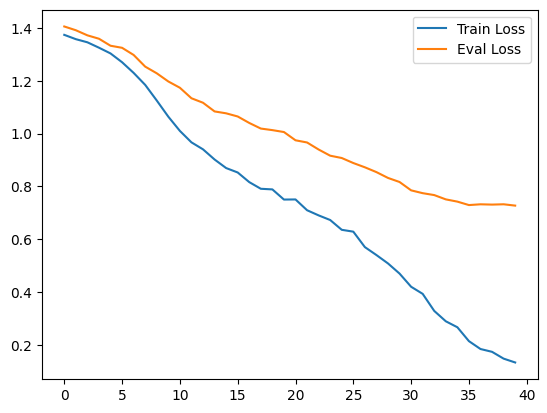

In [ ]:
num_epochs = 20


for epoch in range(num_epochs):
    xception_model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Train Batch: ", leave=bool(epoch == num_epochs)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = xception_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    xception_model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Batch: ", leave=bool(epoch == num_epochs)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = xception_model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    pd.DataFrame({"Train Loss": train_losses, "Eval Loss": valid_losses}, index=list(range(len(train_losses)))).plot()
    plt.show()

with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_train_losses.pkl"), 'wb') as f:
    pickle.dump(train_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_valid_losses.pkl"), 'wb') as f:
    pickle.dump(valid_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_predictions.pkl"), 'wb') as f:
    pickle.dump(all_predictions, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_labels.pkl"), 'wb') as f:
    pickle.dump(all_labels, f)

transfer_learning_xception_model_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_2.pt")
torch.save(xception_model.state_dict(), transfer_learning_xception_model_path)

In [ ]:
xception_model.eval()

total_correct = 0
total_samples = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = xception_model(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

100%|██████████| 27/27 [04:49<00:00, 10.74s/it]


                  precision    recall  f1-score   support

    MildDemented       0.44      0.12      0.19       179
ModerateDemented       1.00      0.08      0.15        12
     NonDemented       0.67      0.32      0.43       640
VeryMildDemented       0.38      0.78      0.51       448

        accuracy                           0.45      1279
       macro avg       0.62      0.33      0.32      1279
    weighted avg       0.54      0.45      0.42      1279



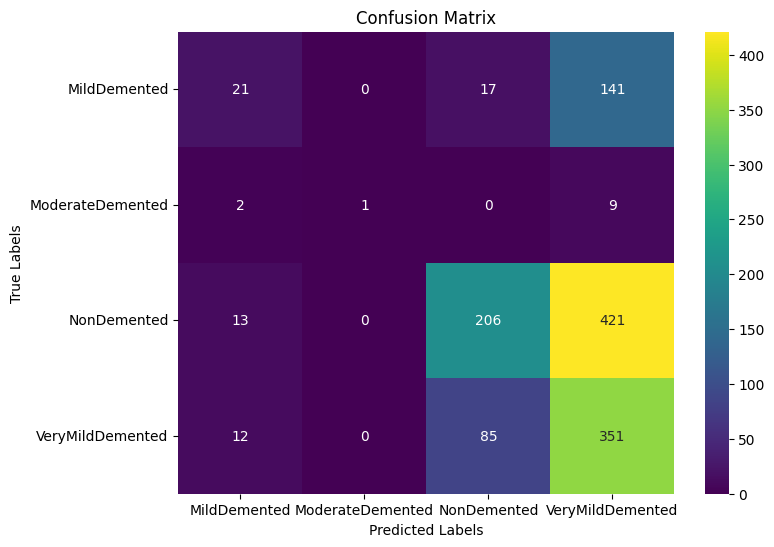

In [ ]:
plot_results(true_labels, predicted_labels)

 - Precision - in the third experiment, there were improvements in precision for most classes. The precision values for the "MildDemented," "ModerateDemented," "NonDemented," and "VeryMildDemented" classes were 0.44, 1.00, 0.67, and 0.38, respectively.
 - Recall - in the third experiment, there were mixed results. The recall for the "ModerateDemented" and "VeryMildDemented" classes improved, while the recall for the "ModerateDemented" class remained low at 0.08 and "VeryMildDemented" improved to 0.78 The recall for the "NonDemented" class decreased to 0.32 and for the "MildDemented" class to 0.12.
 - F1-Score - In the third experiment, there were slight improvements in the F1-scores for the "ModerateDemented" and "VeryMildDemented" classes to 0.15 and 0.51 respectively, while the "MildDemented" class decreased to 0.19 and the "NonDemented" class decreased to F1-score of 0.43.
 Overall, the third experiment showed improvements in precision for most classes compared to the first experiment. However, the recall and F1-scores varied across the classes, with the "ModerateDemented" class still performing poorly. The accuracy of the third experiment was slightly lower than that of the first experiment. Further fine-tuning and optimization are necessary to enhance the performance of the fine tuned model for Alzheimer's disease classification.

Next, we use more regularization and add another richness to the classifier by adding another FC hidden layer with ReLU activation function and a dropout layer with 0.2 dropout rate, while utilizing the same hyperparameters of learning rate and weight decay of same Adam optimizer and loss function.

In [ ]:
# with more regularization and weighted sampler + add another fc layer with relu & dropout
xception_model = xception()
xception_model.load_state_dict(pretrained_model_state_dict)

xception_model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 4)
)
# xception_model.fc = nn.Linear(2048, 4)
xception_model = xception_model.to(device)
list(xception_model.children())[-1]

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)

Epoch 1/20 | Training Loss: 1.3854 | Validation Loss: 1.3894


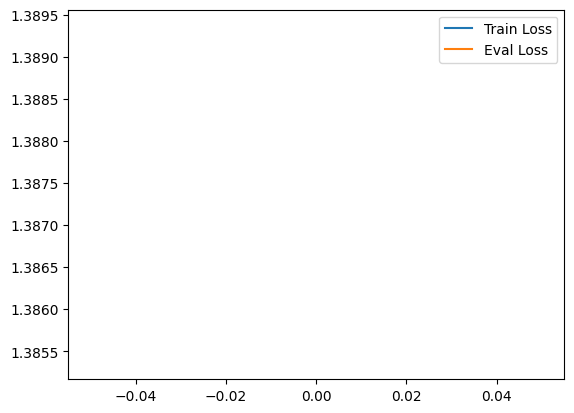

Epoch 2/20 | Training Loss: 1.3786 | Validation Loss: 1.3858


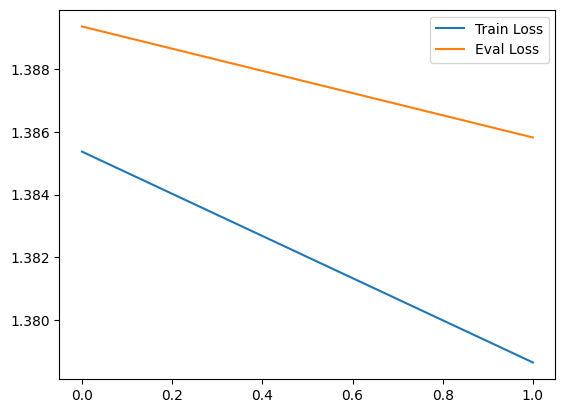

Epoch 3/20 | Training Loss: 1.3733 | Validation Loss: 1.3806


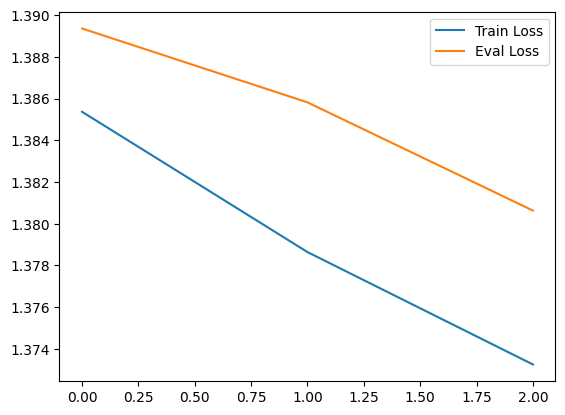

Epoch 4/20 | Training Loss: 1.3681 | Validation Loss: 1.3824


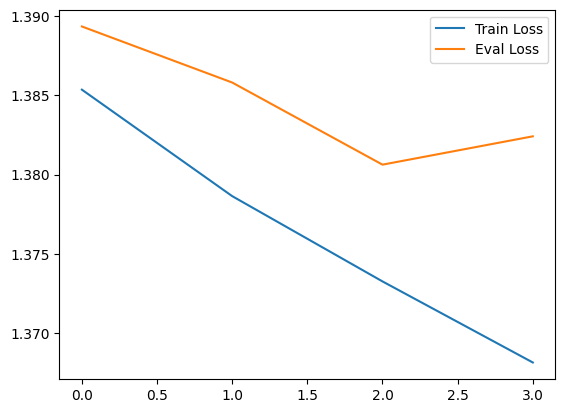

Epoch 5/20 | Training Loss: 1.3588 | Validation Loss: 1.3925


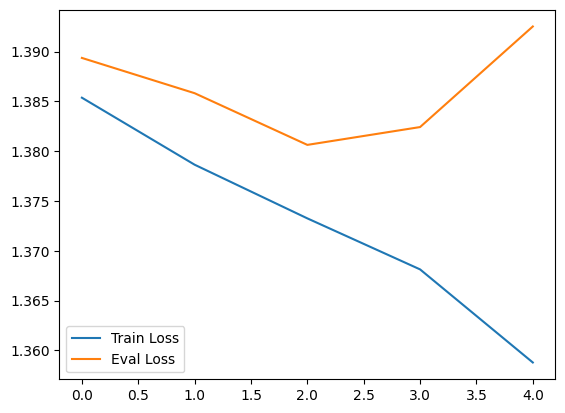

Epoch 6/20 | Training Loss: 1.3520 | Validation Loss: 1.3809


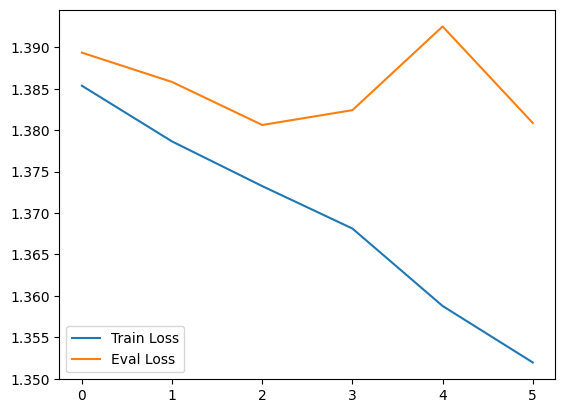

Epoch 7/20 | Training Loss: 1.3403 | Validation Loss: 1.3870


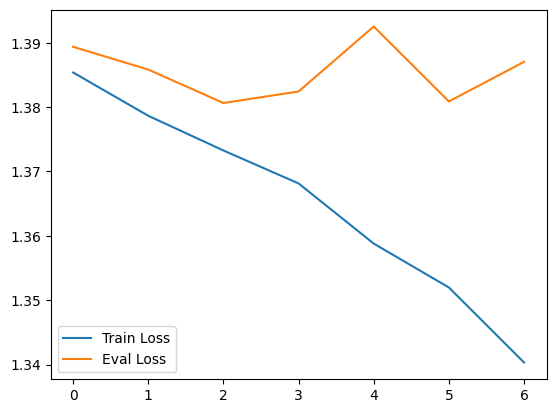

Epoch 8/20 | Training Loss: 1.3255 | Validation Loss: 1.3724


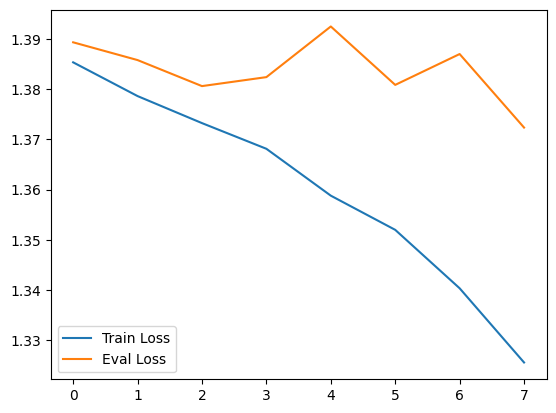

Epoch 9/20 | Training Loss: 1.3021 | Validation Loss: 1.3666


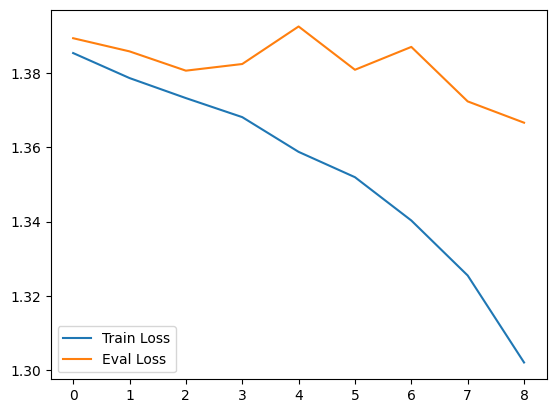

Epoch 10/20 | Training Loss: 1.2711 | Validation Loss: 1.3470


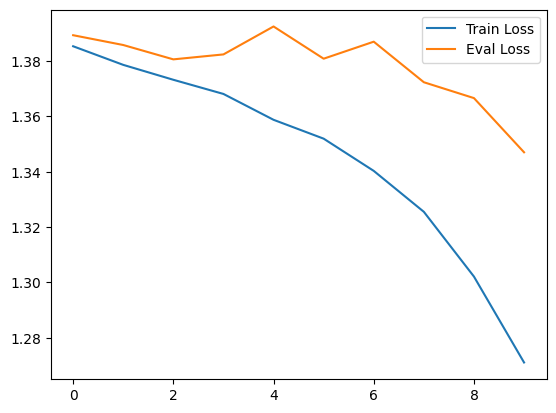

Epoch 11/20 | Training Loss: 1.2181 | Validation Loss: 1.3186


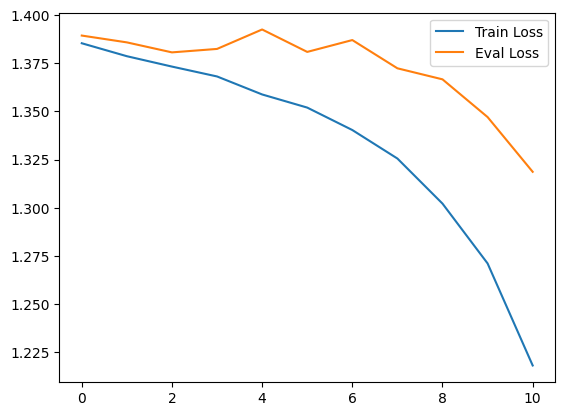

Epoch 12/20 | Training Loss: 1.1641 | Validation Loss: 1.2616


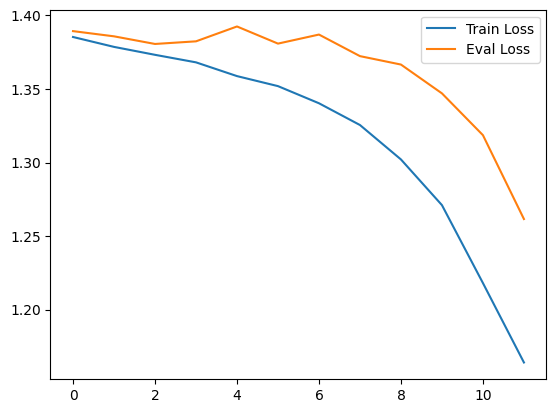

Epoch 13/20 | Training Loss: 1.0842 | Validation Loss: 1.2308


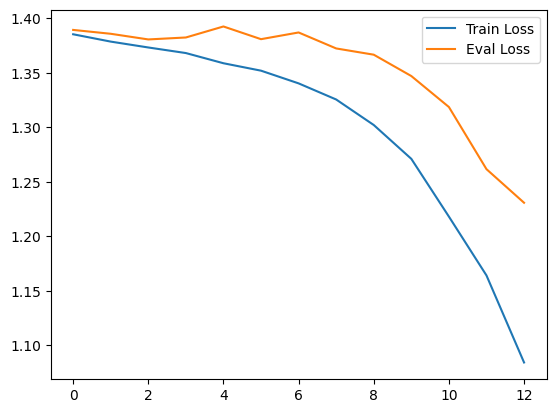

Epoch 14/20 | Training Loss: 1.0207 | Validation Loss: 1.2011


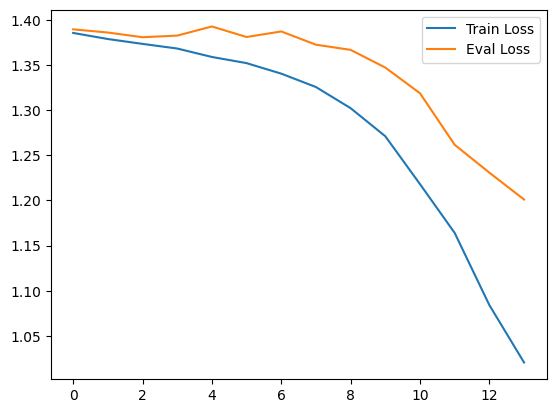

Epoch 15/20 | Training Loss: 0.9822 | Validation Loss: 1.1676


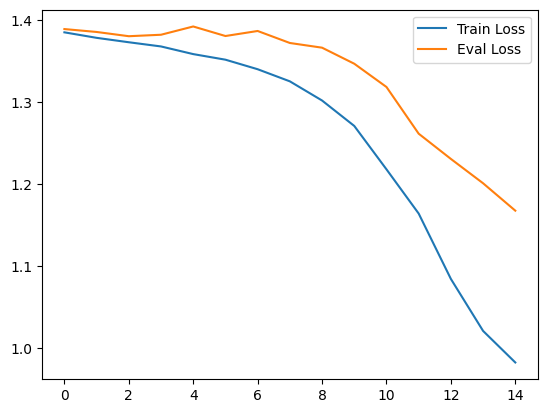

Epoch 16/20 | Training Loss: 0.9475 | Validation Loss: 1.1600


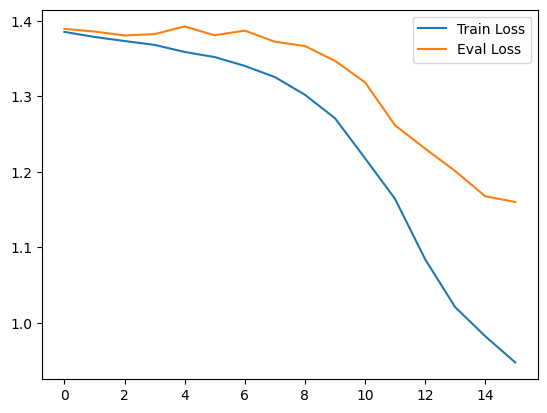

Epoch 17/20 | Training Loss: 0.9202 | Validation Loss: 1.1387


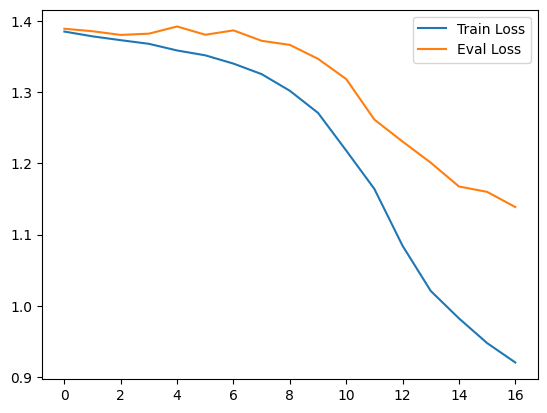

Epoch 18/20 | Training Loss: 0.8986 | Validation Loss: 1.1339


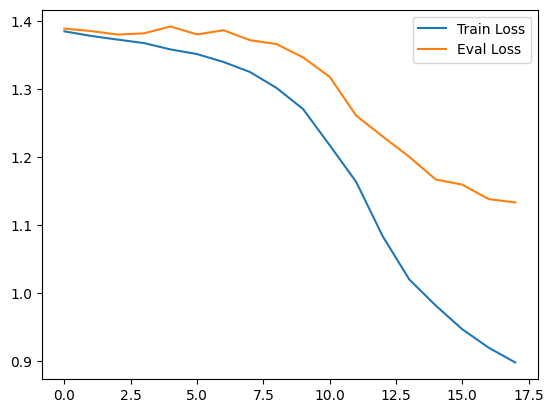

Epoch 19/20 | Training Loss: 0.8889 | Validation Loss: 1.1270


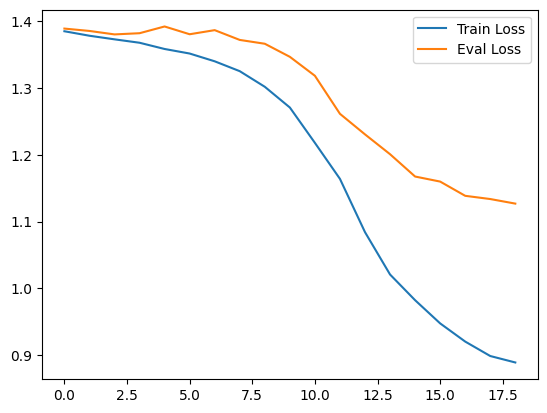

Epoch 20/20 | Training Loss: 0.8714 | Validation Loss: 1.1193


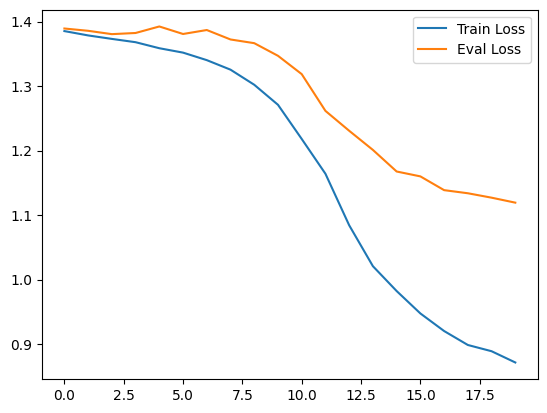

In [ ]:
num_epochs = 20

train_losses = []
valid_losses = []
all_predictions = []
all_labels = []

lr = 0.00001
wd = 0.2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xception_model.parameters(), lr=lr, weight_decay=wd)

for epoch in range(num_epochs):
    xception_model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Train Batch: ", leave=bool(epoch == num_epochs)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = xception_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    xception_model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Batch: ", leave=bool(epoch == num_epochs)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = xception_model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    pd.DataFrame({"Train Loss": train_losses, "Eval Loss": valid_losses}, index=list(range(len(train_losses)))).plot()
    plt.show()

with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_train_losses.pkl"), 'wb') as f:
    pickle.dump(train_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_valid_losses.pkl"), 'wb') as f:
    pickle.dump(valid_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_predictions.pkl"), 'wb') as f:
    pickle.dump(all_predictions, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_labels.pkl"), 'wb') as f:
    pickle.dump(all_labels, f)

transfer_learning_xception_model_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_fc_dr.pt")
torch.save(xception_model.state_dict(), transfer_learning_xception_model_path)

In [ ]:
xception_model.eval()

total_correct = 0
total_samples = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = xception_model(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

100%|██████████| 27/27 [07:25<00:00, 16.52s/it]


                  precision    recall  f1-score   support

    MildDemented       0.19      0.89      0.32       179
ModerateDemented       0.62      0.42      0.50        12
     NonDemented       0.80      0.47      0.59       640
VeryMildDemented       0.37      0.06      0.11       448

        accuracy                           0.39      1279
       macro avg       0.50      0.46      0.38      1279
    weighted avg       0.56      0.39      0.38      1279



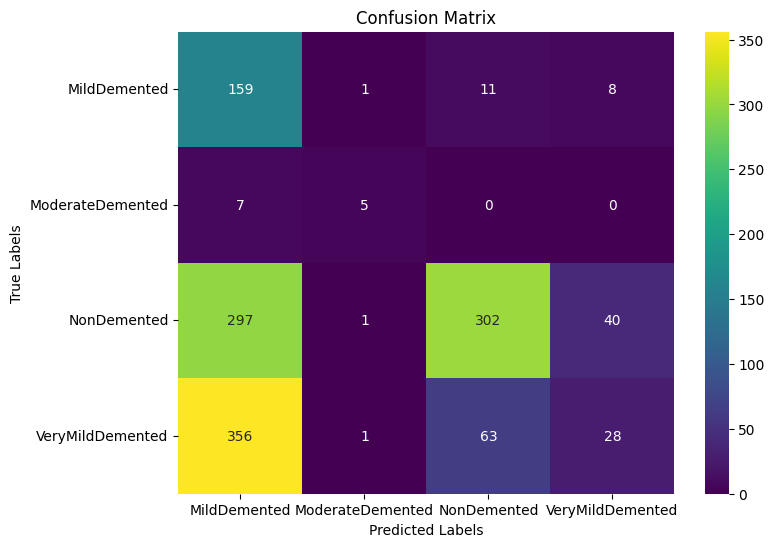

In [ ]:
plot_results(true_labels, predicted_labels)


By the training and validation loss chart we assume that the learning rate was set to low, because we expect faster convergence.
For the next experiment we set a higher learning rate of 1e-4.

In [ ]:
# with more regularization and weighted sampler + add another fc layer with relu & dropout + lower lr
xception_model = xception()
xception_model.load_state_dict(pretrained_model_state_dict)

xception_model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 4)
)
# xception_model.fc = nn.Linear(2048, 4)
xception_model = xception_model.to(device)
list(xception_model.children())[-1]

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)

Epoch 1/20 | Training Loss: 1.3553 | Validation Loss: 1.3238


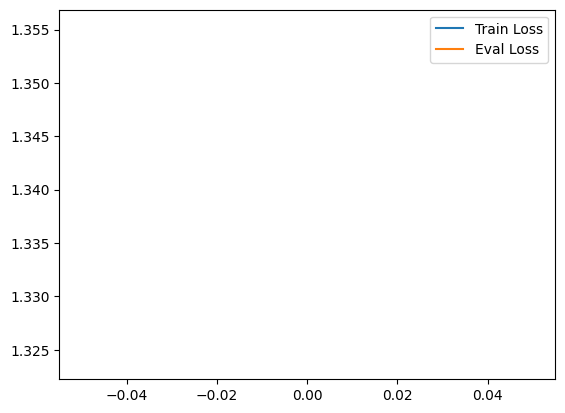

Epoch 2/20 | Training Loss: 1.0779 | Validation Loss: 1.0940


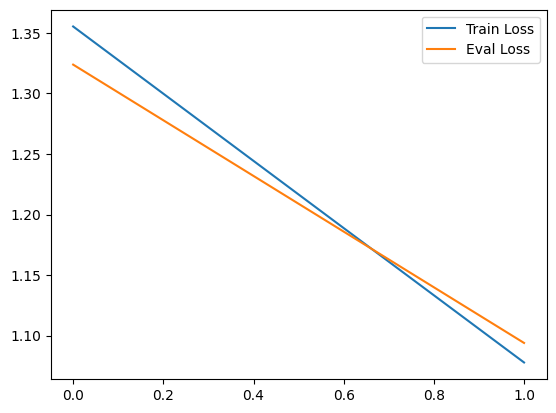

Epoch 3/20 | Training Loss: 0.8202 | Validation Loss: 1.0122


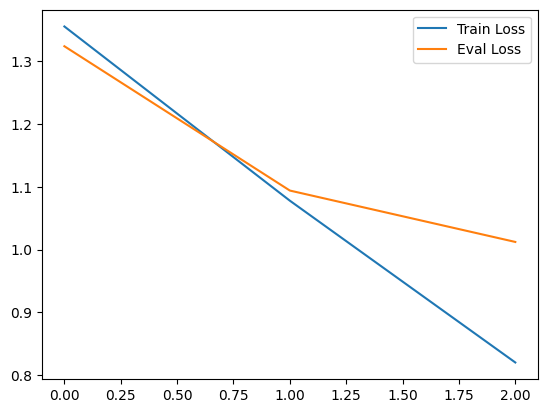

Epoch 4/20 | Training Loss: 0.6784 | Validation Loss: 0.9495


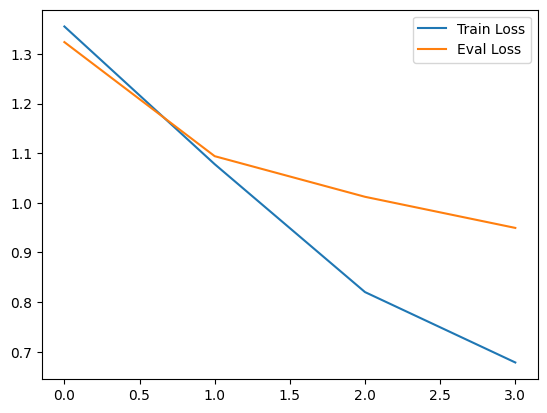

Epoch 5/20 | Training Loss: 0.5416 | Validation Loss: 0.9157


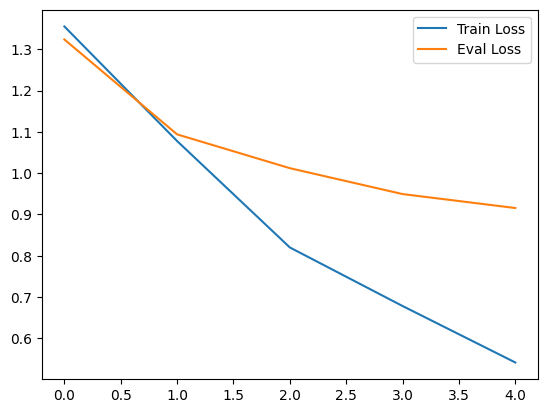

Epoch 6/20 | Training Loss: 0.4419 | Validation Loss: 0.9055


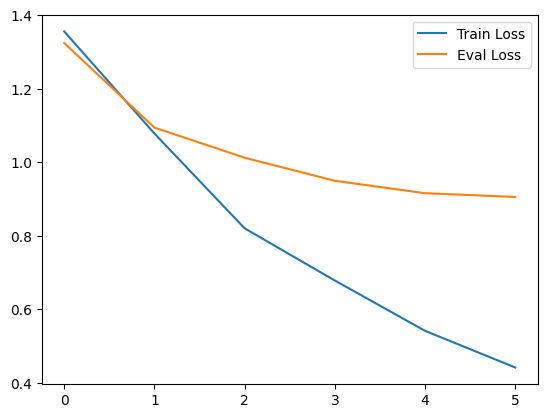

Epoch 7/20 | Training Loss: 0.3719 | Validation Loss: 0.7619


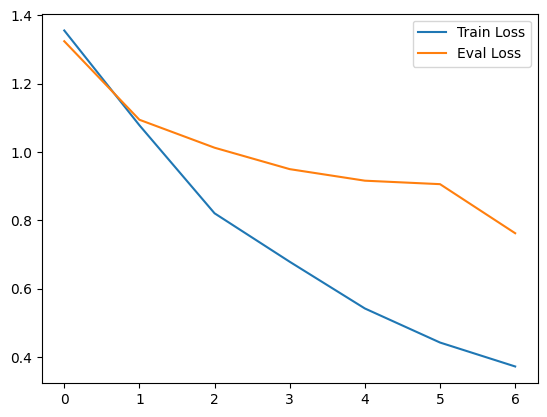

Epoch 8/20 | Training Loss: 0.2958 | Validation Loss: 0.6562


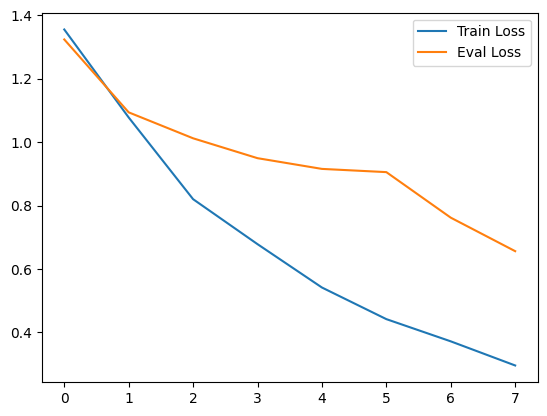

Epoch 9/20 | Training Loss: 0.2685 | Validation Loss: 0.6477


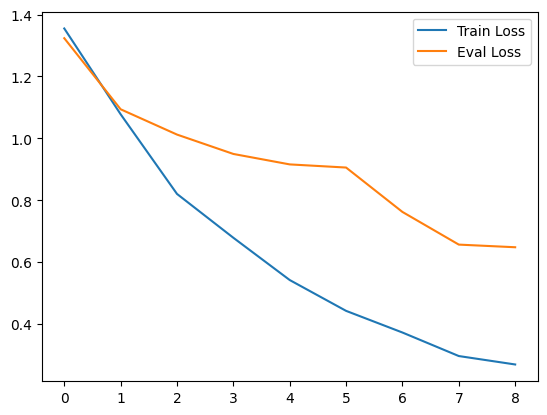

Epoch 10/20 | Training Loss: 0.2272 | Validation Loss: 0.8105


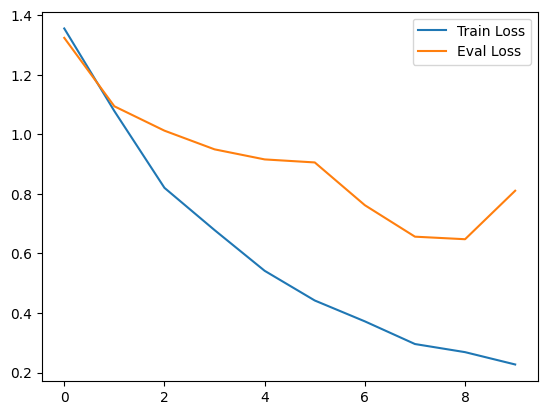

Epoch 11/20 | Training Loss: 0.2118 | Validation Loss: 0.4666


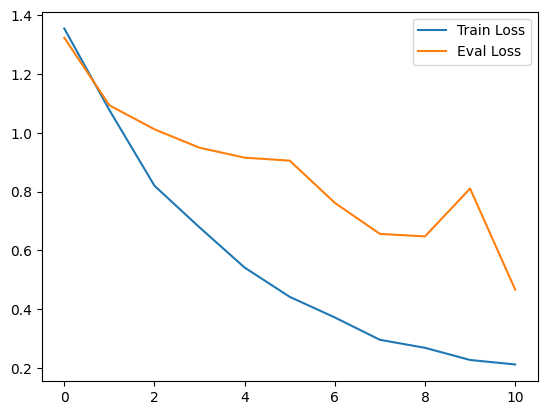

Epoch 12/20 | Training Loss: 0.2800 | Validation Loss: 0.6387


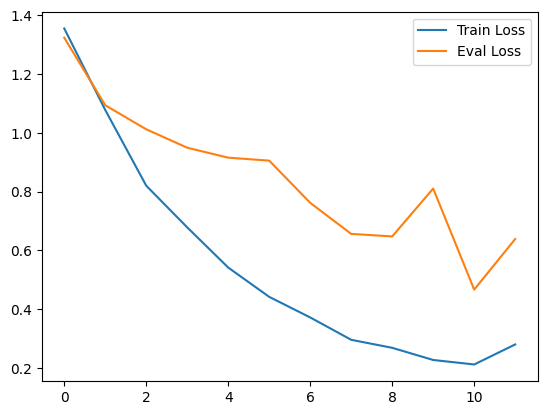

Epoch 13/20 | Training Loss: 0.1898 | Validation Loss: 0.5226


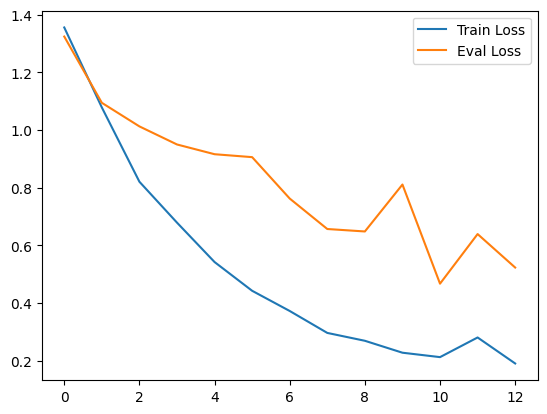

Epoch 14/20 | Training Loss: 0.1970 | Validation Loss: 0.5363


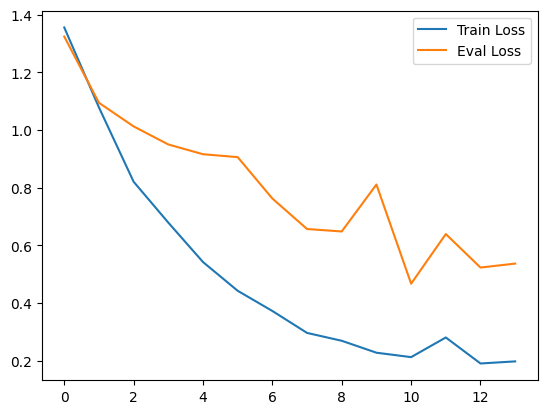

Epoch 15/20 | Training Loss: 0.2234 | Validation Loss: 0.9091


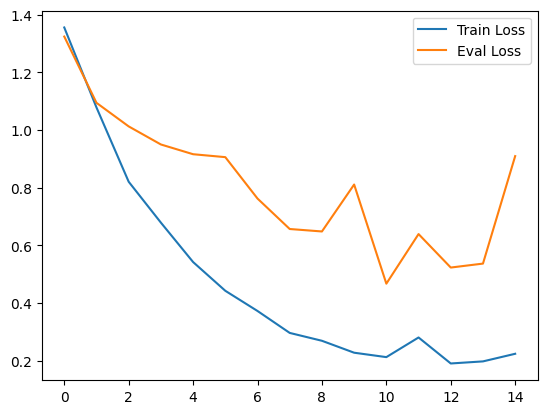

Epoch 16/20 | Training Loss: 0.1953 | Validation Loss: 0.8436


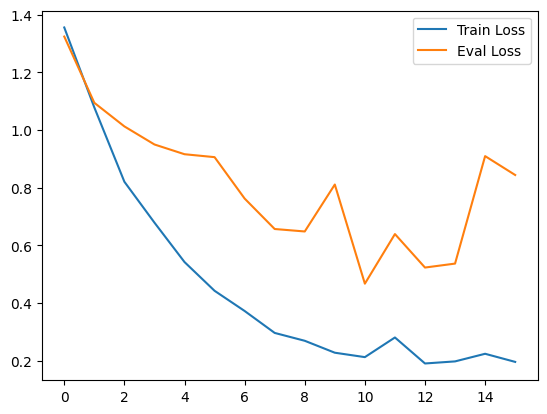

Epoch 17/20 | Training Loss: 0.2039 | Validation Loss: 0.5031


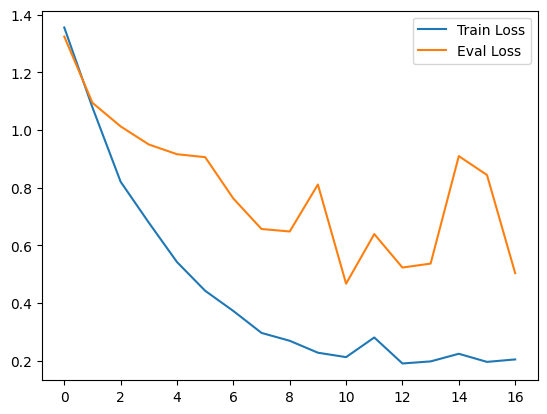

Epoch 18/20 | Training Loss: 0.2056 | Validation Loss: 0.4470


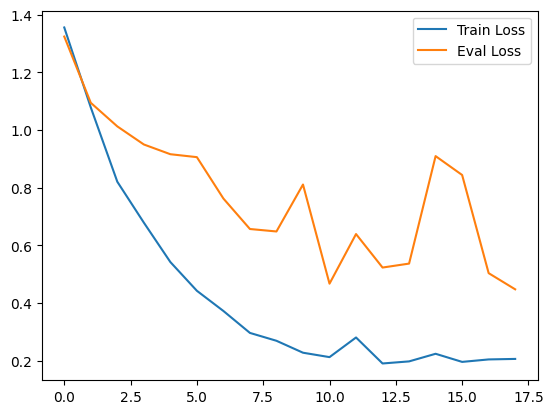

Epoch 19/20 | Training Loss: 0.1929 | Validation Loss: 1.1544


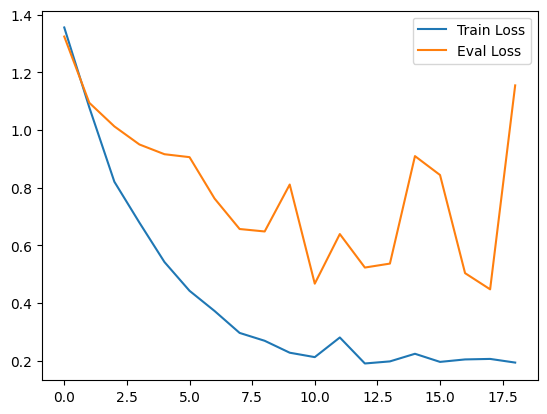

Epoch 20/20 | Training Loss: 0.1744 | Validation Loss: 0.6132


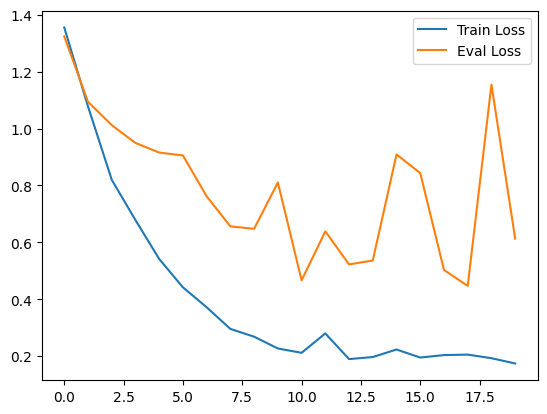

In [ ]:
num_epochs = 20

train_losses = []
valid_losses = []
all_predictions = []
all_labels = []

lr = 0.0001
wd = 0.2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xception_model.parameters(), lr=lr, weight_decay=wd)

for epoch in range(num_epochs):
    xception_model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Train Batch: ", leave=bool(epoch == num_epochs)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = xception_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    xception_model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Batch: ", leave=bool(epoch == num_epochs)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = xception_model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    pd.DataFrame({"Train Loss": train_losses, "Eval Loss": valid_losses}, index=list(range(len(train_losses)))).plot()
    plt.show()

with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_train_losses.pkl"), 'wb') as f:
    pickle.dump(train_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_valid_losses.pkl"), 'wb') as f:
    pickle.dump(valid_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_predictions.pkl"), 'wb') as f:
    pickle.dump(all_predictions, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_labels.pkl"), 'wb') as f:
    pickle.dump(all_labels, f)

transfer_learning_xception_model_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_fc_dr.pt")
torch.save(xception_model.state_dict(), transfer_learning_xception_model_path)

Trying to run the model for a few more epochs to achieve lower validation loss.

In [ ]:
transfer_learning_xception_model_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_fc_dr1.pt")
pretrained_model_state_dict = torch.load(transfer_learning_xception_model_path)
xception_model = xception()
xception_model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 4)
)
xception_model.load_state_dict(pretrained_model_state_dict)
xception_model = xception_model.to(device)

Epoch 21/40 | Training Loss: 0.1514 | Validation Loss: 0.3087


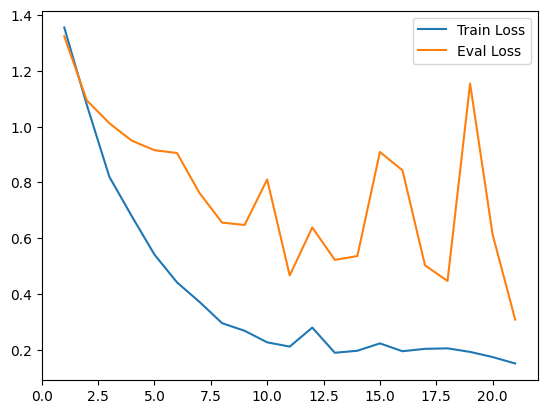

1 to stop1


In [ ]:
for epoch in range(num_epochs):
    xception_model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Train Batch: ", leave=bool(epoch == num_epochs)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = xception_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    xception_model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Batch: ", leave=bool(epoch == num_epochs)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = xception_model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    stop = 0


    print(f"Epoch {epoch + 21}/{num_epochs + 20} | Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    pd.DataFrame({"Train Loss": train_losses, "Eval Loss": valid_losses}, index=list(range(1, len(train_losses) + 1))).plot()
    plt.show()
    if valid_loss < 0.4:
      stop = int(input("1 to stop"))
    if stop == 1:
      break

with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_train_losses.pkl"), 'wb') as f:
    pickle.dump(train_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_valid_losses.pkl"), 'wb') as f:
    pickle.dump(valid_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_predictions.pkl"), 'wb') as f:
    pickle.dump(all_predictions, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_labels.pkl"), 'wb') as f:
    pickle.dump(all_labels, f)

transfer_learning_xception_model_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_wd_{wd}_fc_dr.pt")
torch.save(xception_model.state_dict(), transfer_learning_xception_model_path)

100%|██████████| 27/27 [00:17<00:00,  1.58it/s]


                  precision    recall  f1-score   support

    MildDemented       0.60      0.42      0.50       179
ModerateDemented       1.00      0.08      0.15        12
     NonDemented       0.72      0.78      0.75       640
VeryMildDemented       0.62      0.63      0.62       448

        accuracy                           0.67      1279
       macro avg       0.74      0.48      0.51      1279
    weighted avg       0.67      0.67      0.67      1279



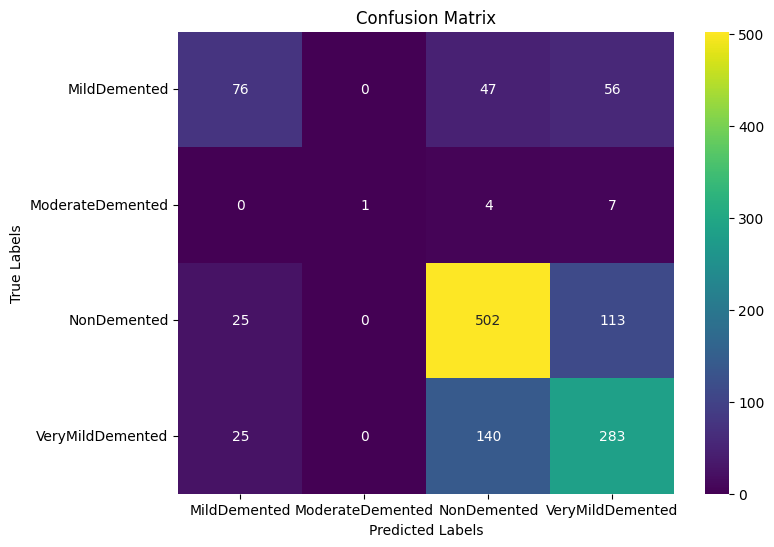

In [ ]:
xception_model.eval()

total_correct = 0
total_samples = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = xception_model(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

plot_results(true_labels, predicted_labels)

The latest classification report showcases the performance of the model on the dementia classification task:
 - Precision - the precision values indicate the accuracy of the predictions, with notable improvements observed across multiple classes. The precision for "MildDemented" increased to 0.60, while for "ModerateDemented", it remained perfect at 1.00. The precision for "NonDemented" improved to 0.72, and for "VeryMildDemented" it increased to 0.62.
 - Recall - regarding recall, improvements were seen for the "MildDemented" and "NonDemented" classes. The recall for "MildDemented" increased to 0.42, and for "NonDemented" it improved to 0.78. The recall for "VeryMildDemented" showed a mild decrease to 0.63. The recall for the "ModerateDemented" class remained low at 0.08.
 - F1-score - the F1-score for "MildDemented" was 0.50, while for "ModerateDemented" it stayed low at 0.15. The F1-score for "NonDemented" was high at 0.75, and for "VeryMildDemented" it increased to 0.62.

 The overall accuracy of the model improved significantly to 0.67, showcasing a notable enhancement in correctly classifying the samples. The macro average precision, recall, and F1-score also displayed improvements, resulting in better overall performance. The weighted average precision, recall, and F1-score all increased to 0.67, indicating enhanced performance considering the class distribution.

In the next experiment we do not use weight decay regularization and we set the optimizer's learning rate to 1e-3 for faster convergence.

In [ ]:
pretrained_model_state_dict = torch.load(pretrained_model_path)
xception_model = xception()
xception_model.load_state_dict(pretrained_model_state_dict)
xception_model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 4)
)
xception_model = xception_model.to(device)

Epoch 21/40 | Training Loss: 0.9797 | Validation Loss: 7.2531


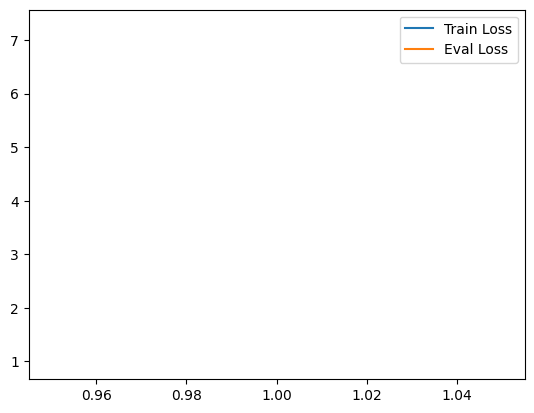

Epoch 22/40 | Training Loss: 0.4578 | Validation Loss: 0.6296


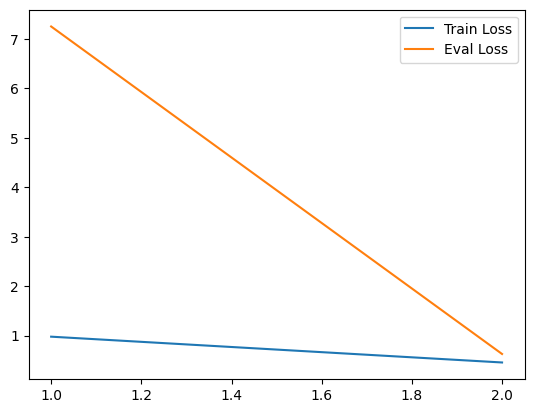

Epoch 23/40 | Training Loss: 0.2220 | Validation Loss: 1.0153


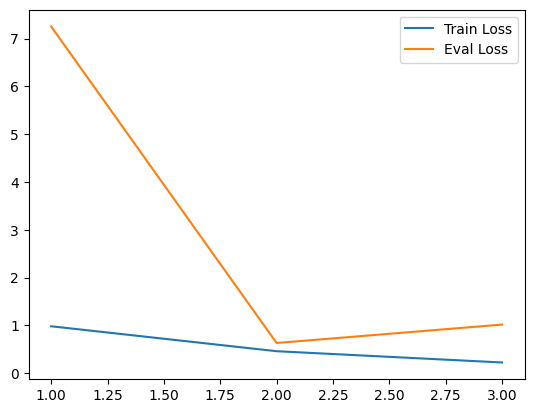

Epoch 24/40 | Training Loss: 0.1736 | Validation Loss: 0.5216


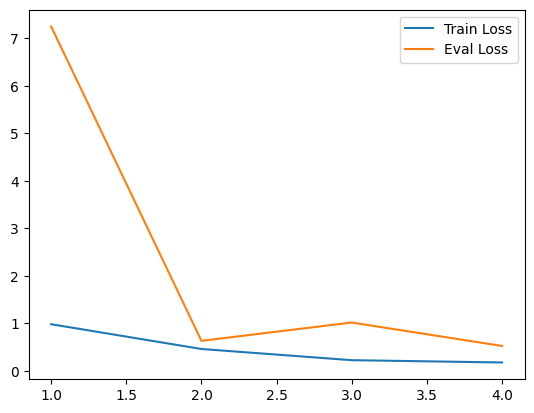

Epoch 25/40 | Training Loss: 0.1000 | Validation Loss: 0.2543


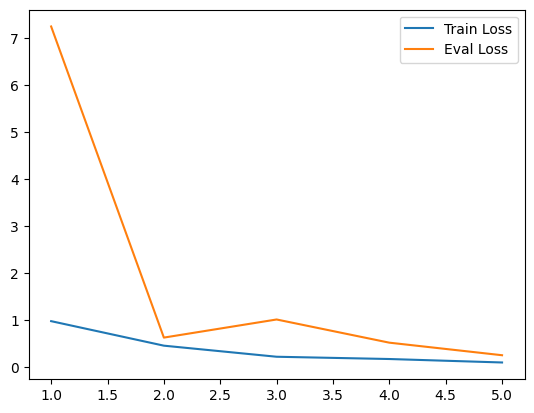

1 to stop1


In [ ]:
num_epochs = 20

train_losses = []
valid_losses = []
all_predictions = []
all_labels = []

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xception_model.parameters(), lr=lr)

for epoch in range(num_epochs):
    xception_model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Train Batch: ", leave=bool(epoch == num_epochs)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = xception_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    xception_model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Batch: ", leave=bool(epoch == num_epochs)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = xception_model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch + 21}/{num_epochs + 20} | Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    pd.DataFrame({"Train Loss": train_losses, "Eval Loss": valid_losses}, index=list(range(1, len(train_losses) + 1))).plot()
    plt.show()

    stop = 0
    if valid_loss < 0.4:
      stop = int(input("1 to stop"))
    if stop == 1:
      break

with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_train_losses.pkl"), 'wb') as f:
    pickle.dump(train_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_valid_losses.pkl"), 'wb') as f:
    pickle.dump(valid_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_predictions.pkl"), 'wb') as f:
    pickle.dump(all_predictions, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_labels.pkl"), 'wb') as f:
    pickle.dump(all_labels, f)

transfer_learning_xception_model_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"tl_all_xception_lr_{lr}_fc_dr.pt")
torch.save(xception_model.state_dict(), transfer_learning_xception_model_path)

100%|██████████| 27/27 [00:17<00:00,  1.58it/s]


                  precision    recall  f1-score   support

    MildDemented       0.69      0.59      0.64       179
ModerateDemented       0.78      0.58      0.67        12
     NonDemented       0.85      0.65      0.74       640
VeryMildDemented       0.59      0.83      0.69       448

        accuracy                           0.70      1279
       macro avg       0.73      0.66      0.68      1279
    weighted avg       0.74      0.70      0.71      1279



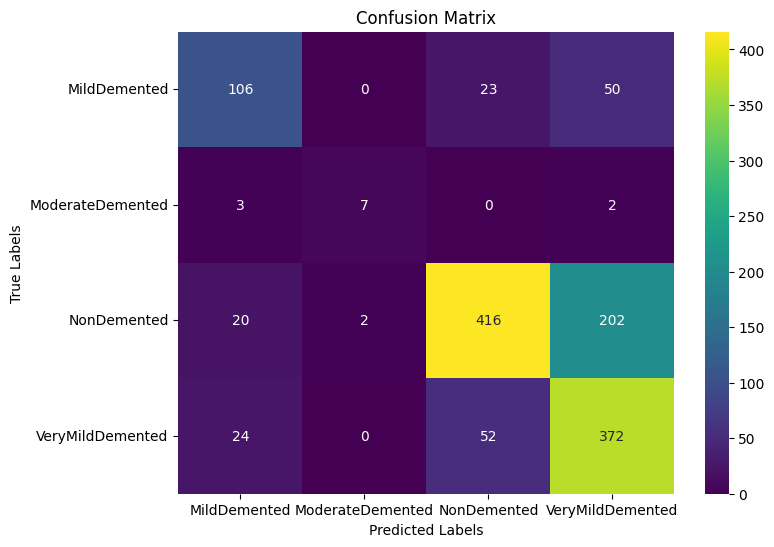

In [ ]:
xception_model.eval()

total_correct = 0
total_samples = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = xception_model(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

plot_results(true_labels, predicted_labels)

 - Precision - the highest precision was achieved for the "NonDemented" class at 0.85, followed by "ModerateDemented" at 0.78, "MildDemented" at 0.69, and "VeryMildDemented" at 0.59.
 - Recall - the highest recall was observed for the "VeryMildDemented" class at 0.83, followed by "NonDemented" at 0.65, "MildDemented" at 0.59, and "ModerateDemented" at 0.58.
 - F1-score - the highest F1-score was obtained for the "NonDemented" class at 0.74, followed by "MildDemented" at 0.64, "VeryMildDemented" at 0.69, and "ModerateDemented" at 0.67.
 - Accuracy - the overall accuracy of the model was 0.70, indicating its slightly improved ability to correctly classify the samples.
 - Macro Avg - the macro average precision, recall, and F1-score were 0.73, 0.66, and 0.68, respectively.
 - Weighted Avg - the weighted average precision, recall, and F1-score were 0.74, 0.70, and 0.71, respectively.

These results suggest that the model performs well in differentiating between dementia classes, with particularly high accuracy in identifying the "NonDemented" and "ModerateDemented" categories.

In comparison to the previous classification results, this updated model demonstrates notable improvements in precision, recall, F1-scores, accuracy, and the macro and weighted averages. These advancements suggest that the model has been refined and fine-tuned, resulting in better classification performance for different dementia classes.

# Xception Training From Scratch

Next, we train an Xception model from scratch. Training an Xception model from scratch involves training the model's weights and parameters on our custom dataset instead of using pre-trained weights. This approach is typically used when the available pre-trained models do not align well with the specific task or when the dataset is significantly different from the ImageNet dataset on which the Xception model was originally trained.

The model is initialized with random weights and trained using our dataset.
The training process involves passing the images through the network, computing the loss, and updating the model's weights through backpropagation and Adam optimization algorithm. This process is typically performed over multiple epochs to allow the model to learn and adjust its weights to better classify the images.

Training the Xception model from scratch can be computationally expensive (almost twice the time for one epoch in our Xception model's case) and requires a substantial amount of labeled data. It may yield better results when the dataset is sufficiently large and representative of the target task. However, when pre-trained models are available and applicable to the specific problem, fine-tuning or transfer learning using pre-trained weights often leads to better results with less computational cost and training time.

In this experiment we used the same learning rate used for the ImageNet pre-training, 1e-5.

In [ ]:
xception_model = xception()

In [ ]:
xception_model.fc = nn.Linear(2048, 4)
xception_model = xception_model.to(device)
xception_model

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

Epoch 1/20 | Training Loss: 0.7978 | Validation Loss: 1.2959


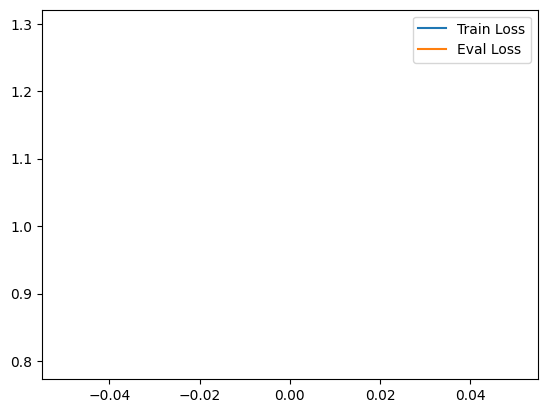

Epoch 2/20 | Training Loss: 0.1895 | Validation Loss: 1.0880


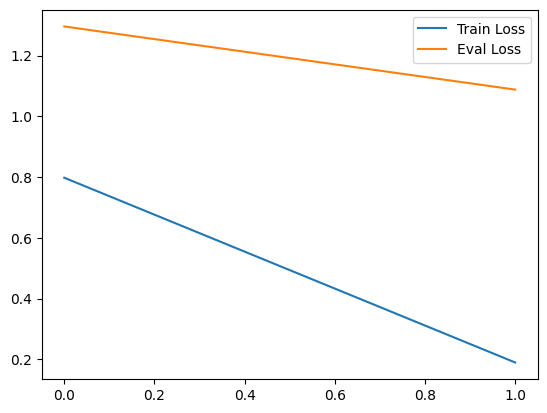

Train Batch: 100%|██████████| 86/86 [05:25<00:00,  3.78s/it]


Epoch 3/20 | Training Loss: 0.1235 | Validation Loss: 1.0471


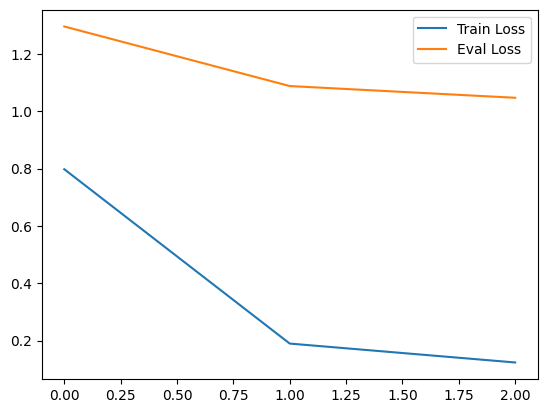

Validation Batch: 100%|██████████| 22/22 [00:14<00:00,  1.53it/s]


Epoch 4/20 | Training Loss: 0.1106 | Validation Loss: 1.0184


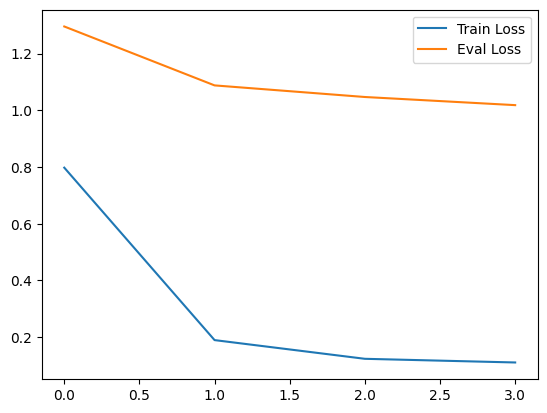

Epoch 5/20 | Training Loss: 0.0865 | Validation Loss: 1.0378


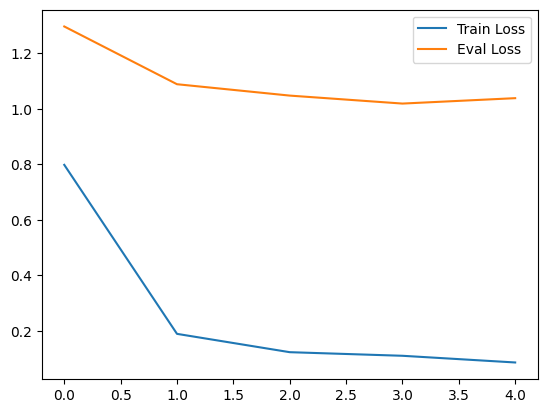

Epoch 6/20 | Training Loss: 0.0872 | Validation Loss: 0.9573


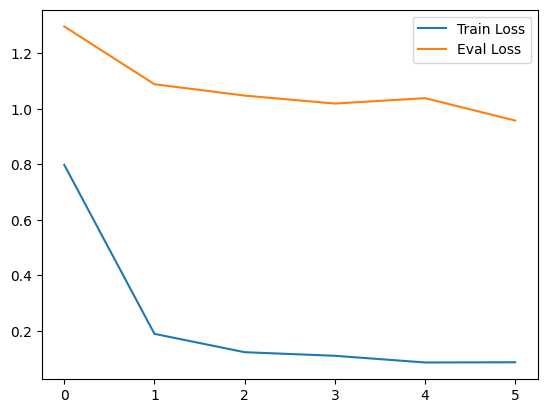

Epoch 7/20 | Training Loss: 0.0858 | Validation Loss: 0.9139


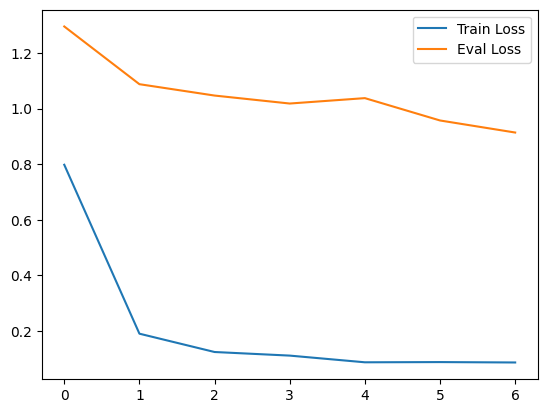

Epoch 8/20 | Training Loss: 0.0757 | Validation Loss: 0.8194


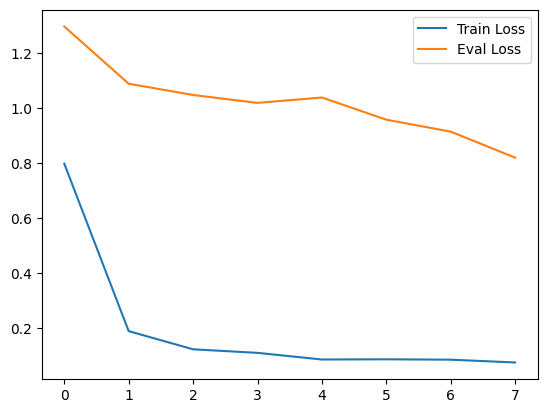

Epoch 9/20 | Training Loss: 0.0634 | Validation Loss: 0.9324


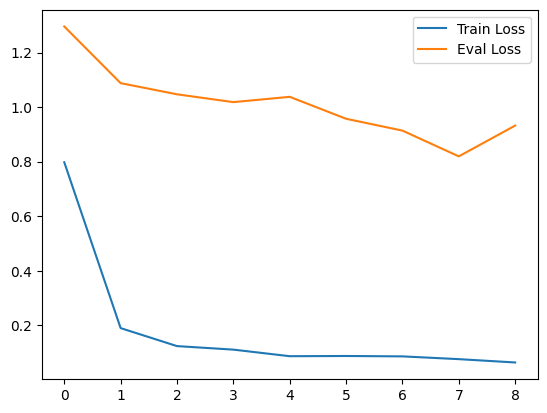

Epoch 10/20 | Training Loss: 0.0580 | Validation Loss: 0.7120


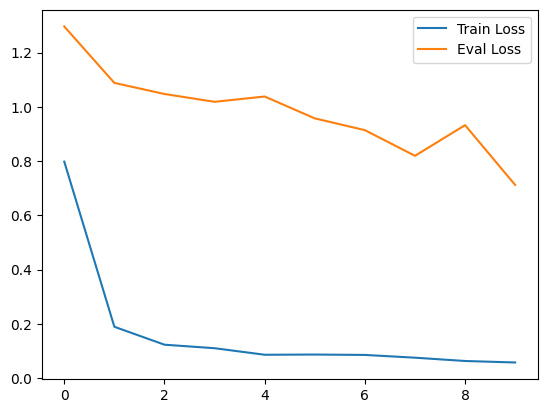

Epoch 11/20 | Training Loss: 0.0443 | Validation Loss: 0.7400


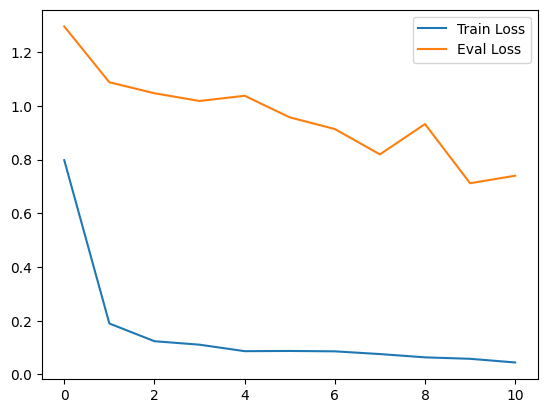

Epoch 12/20 | Training Loss: 0.0352 | Validation Loss: 0.6774


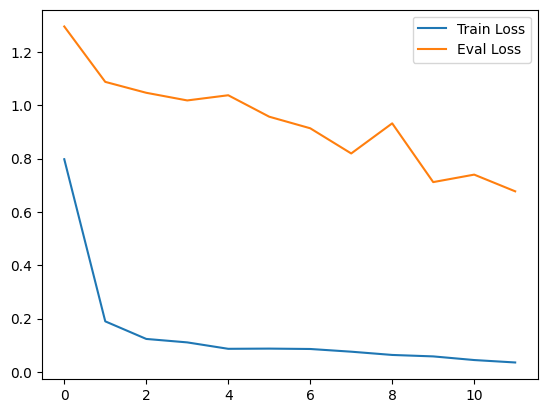

Epoch 13/20 | Training Loss: 0.0314 | Validation Loss: 0.6493


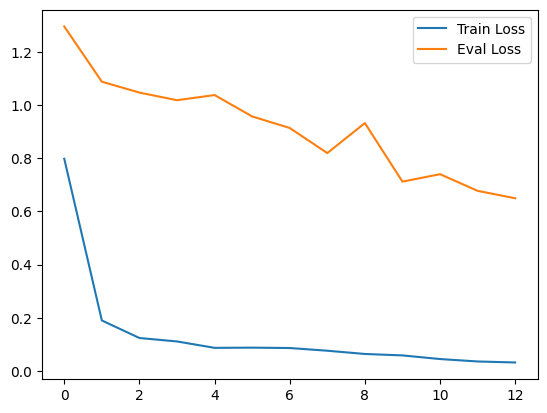

Epoch 14/20 | Training Loss: 0.0285 | Validation Loss: 0.8219


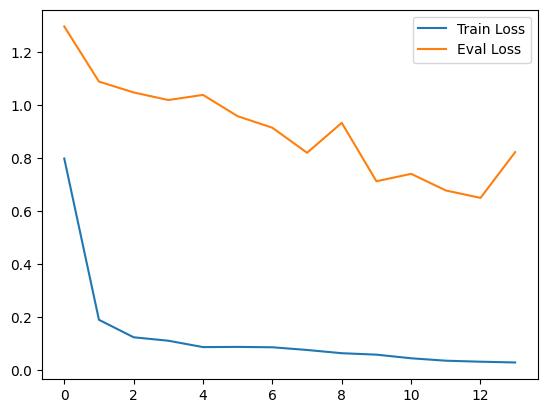

Epoch 15/20 | Training Loss: 0.0235 | Validation Loss: 0.7547


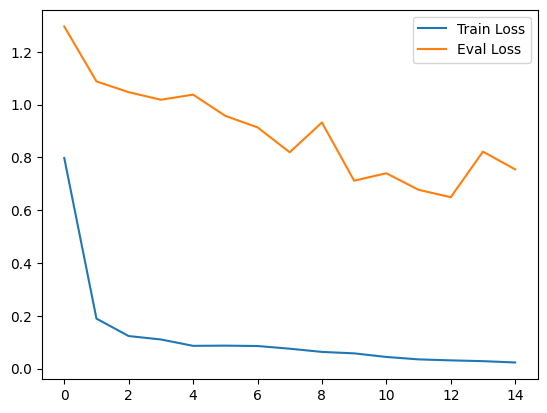

Epoch 16/20 | Training Loss: 0.0184 | Validation Loss: 0.7025


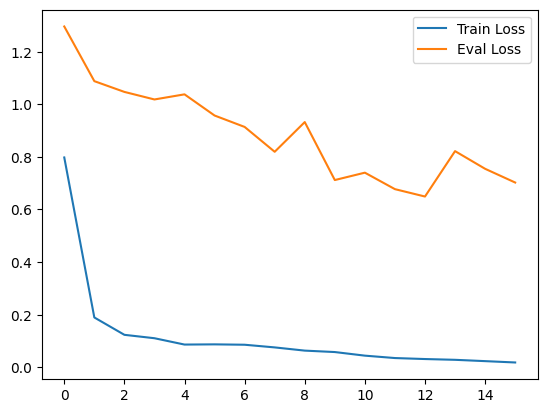

Epoch 17/20 | Training Loss: 0.0148 | Validation Loss: 0.7232


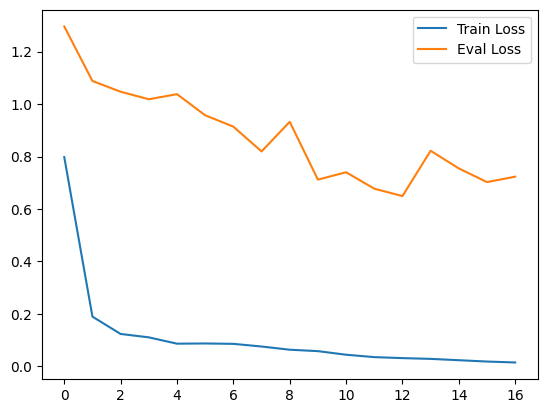

Epoch 18/20 | Training Loss: 0.0105 | Validation Loss: 0.7661


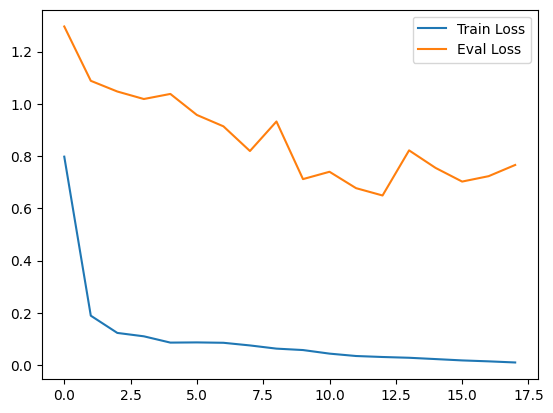

Epoch 19/20 | Training Loss: 0.0090 | Validation Loss: 1.0746


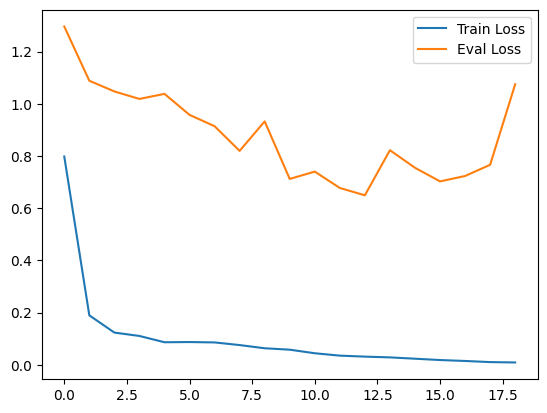

Epoch 20/20 | Training Loss: 0.0067 | Validation Loss: 1.2217


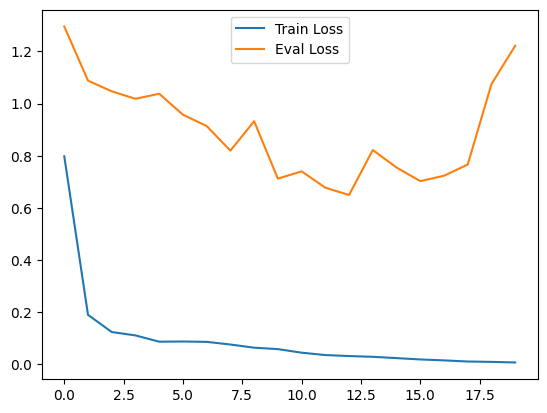

In [ ]:
num_epochs = 20

train_losses = []
valid_losses = []
all_predictions = []
all_labels = []

lr = 0.00001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xception_model.parameters(), lr=lr)

for epoch in range(num_epochs):
    xception_model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Train Batch: ", leave=bool(epoch == 2)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = xception_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    xception_model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Batch: ", leave=bool(epoch == 3)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = xception_model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    # Plot Loss
    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    pd.DataFrame({"Train Loss": train_losses, "Eval Loss": valid_losses}, index=list(range(len(train_losses)))).plot()
    plt.show()

    stop = 0
    if valid_loss < 0.4:
      stop = int(input("1 to stop"))
    if stop == 1:
      break

with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}_train_losses.pkl"), 'wb') as f:
    pickle.dump(train_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}_valid_losses.pkl"), 'wb') as f:
    pickle.dump(valid_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}_val_predictions.pkl"), 'wb') as f:
    pickle.dump(all_predictions, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}_val_labels.pkl"), 'wb') as f:
    pickle.dump(all_labels, f)

scratch_xception_model_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}.pt")
torch.save(xception_model.state_dict(), scratch_xception_model_path)

Learning rate seems too low because there was a high drop in validation loss and in training loss and after one epoch the drop stabilized.

Next we try a higher learning rate of 1e-4.

Epoch 1/20 | Training Loss: 0.1904 | Validation Loss: 0.7810


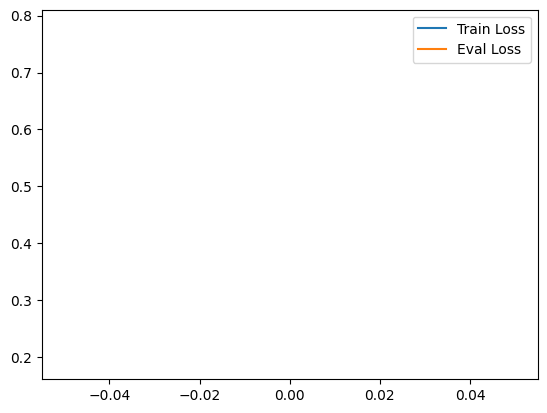

Epoch 2/20 | Training Loss: 0.0506 | Validation Loss: 0.5708


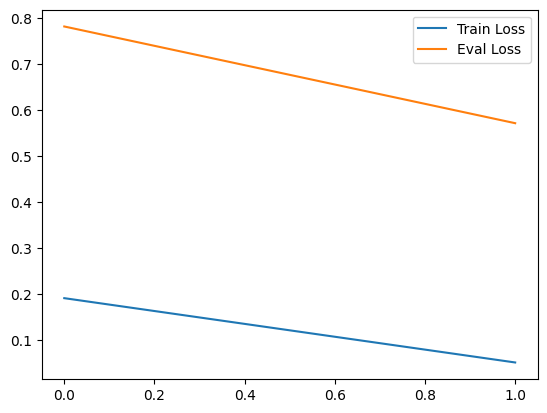

Train Batch: 100%|██████████| 86/86 [02:12<00:00,  1.54s/it]


Epoch 3/20 | Training Loss: 0.0291 | Validation Loss: 1.0365


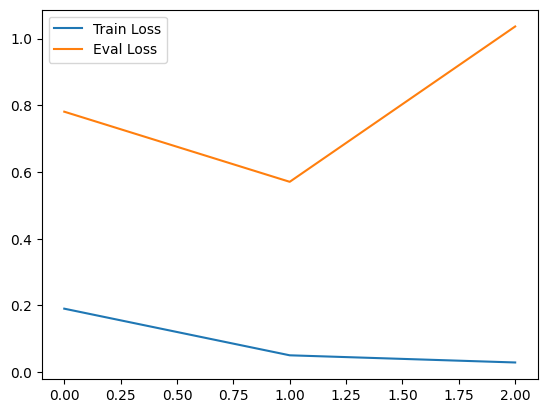

Validation Batch: 100%|██████████| 22/22 [00:13<00:00,  1.57it/s]


Epoch 4/20 | Training Loss: 0.0108 | Validation Loss: 0.3938


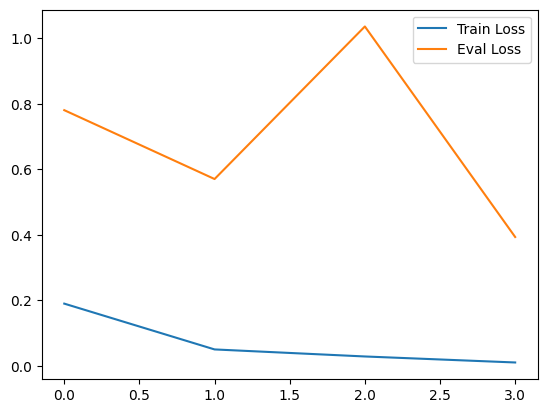

1 to stop0


Epoch 5/20 | Training Loss: 0.0089 | Validation Loss: 0.9168


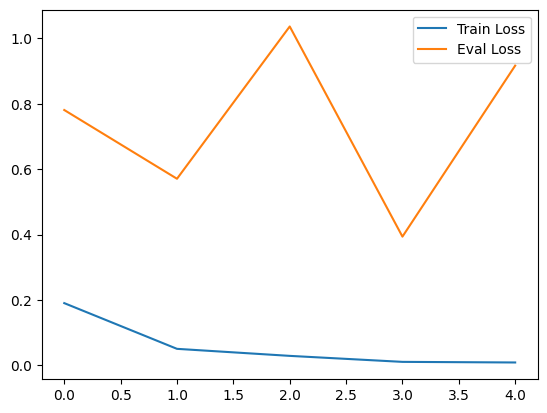

Epoch 6/20 | Training Loss: 0.0096 | Validation Loss: 0.5422


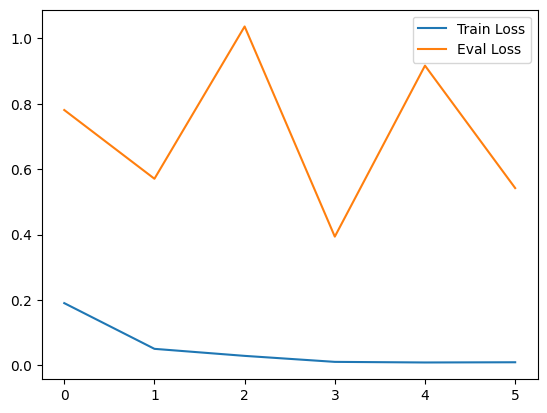

Epoch 7/20 | Training Loss: 0.0091 | Validation Loss: 0.2377


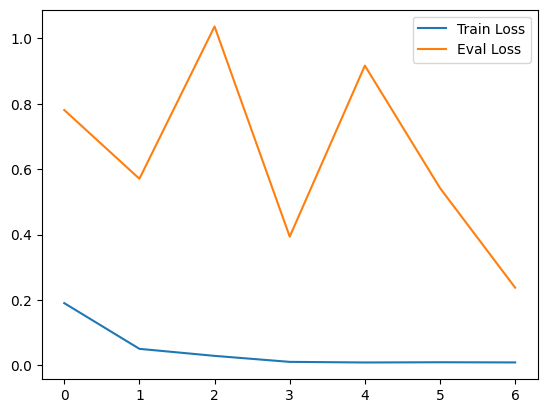

1 to stop1


In [ ]:
num_epochs = 20

train_losses = []
valid_losses = []
all_predictions = []
all_labels = []

lr = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xception_model.parameters(), lr=lr)

for epoch in range(num_epochs):
    xception_model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Train Batch: ", leave=bool(epoch == 2)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = xception_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    xception_model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Batch: ", leave=bool(epoch == 3)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = xception_model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    # Plot Loss
    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    pd.DataFrame({"Train Loss": train_losses, "Eval Loss": valid_losses}, index=list(range(len(train_losses)))).plot()
    plt.show()

    stop = 0
    if valid_loss < 0.4:
      stop = int(input("1 to stop"))
    if stop == 1:
      break

with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}_train_losses.pkl"), 'wb') as f:
    pickle.dump(train_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}_valid_losses.pkl"), 'wb') as f:
    pickle.dump(valid_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}_val_predictions.pkl"), 'wb') as f:
    pickle.dump(all_predictions, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}_val_labels.pkl"), 'wb') as f:
    pickle.dump(all_labels, f)

scratch_xception_model_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}_3.pt")
torch.save(xception_model.state_dict(), scratch_xception_model_path)

Running a few more epochs after saving after 6 epochs (losses history chart had bug noticed post running).

In [ ]:
scratch_xception_model_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_0.0001.pt")
scratch_xception_state_dict = torch.load(scratch_xception_model_path)
xception_model.load_state_dict(scratch_xception_state_dict)

<All keys matched successfully>

Epoch 10/20 | Training Loss: 0.0341 | Validation Loss: 0.3489


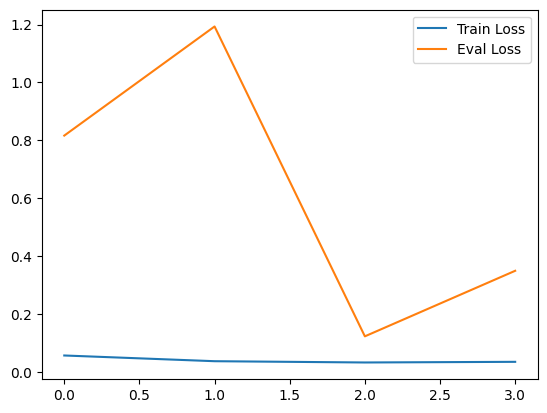

1 to stop0


Epoch 11/20 | Training Loss: 0.0220 | Validation Loss: 0.6043


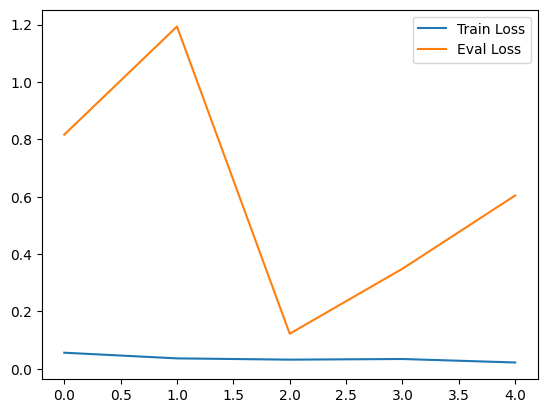

Train Batch: 100%|██████████| 86/86 [02:32<00:00,  1.77s/it]


Epoch 12/20 | Training Loss: 0.0192 | Validation Loss: 0.2431


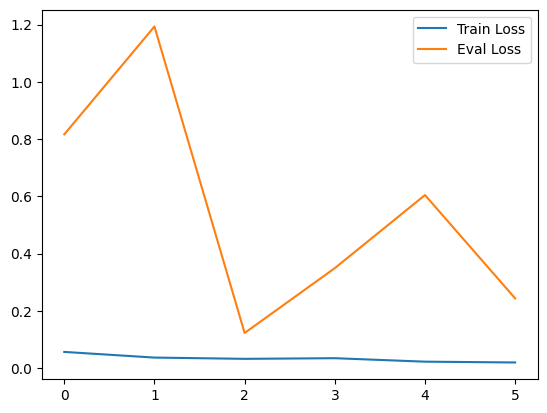

1 to stop0


Validation Batch: 100%|██████████| 22/22 [00:14<00:00,  1.47it/s]


Epoch 13/20 | Training Loss: 0.0212 | Validation Loss: 1.1634


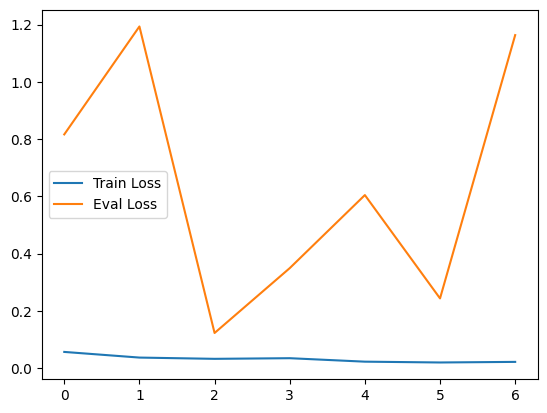

Epoch 14/20 | Training Loss: 0.0193 | Validation Loss: 0.6625


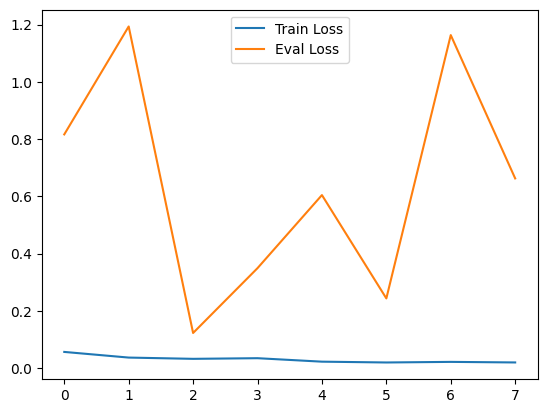

Epoch 15/20 | Training Loss: 0.0167 | Validation Loss: 0.0895


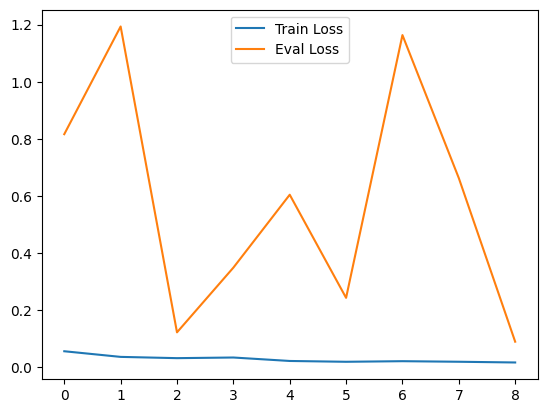

1 to stop1


In [ ]:
for epoch in range(20):
    xception_model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Train Batch: ", leave=bool(epoch == 2)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = xception_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    xception_model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Batch: ", leave=bool(epoch == 3)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = xception_model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    # Plot Loss
    print(f"Epoch {epoch+10}/{20} | Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    pd.DataFrame({"Train Loss": train_losses, "Eval Loss": valid_losses}, index=list(range(len(train_losses)))).plot()
    plt.show()

    stop = 0
    if valid_loss < 0.4:
      stop = int(input("1 to stop"))
    if stop == 1:
      break

with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}_train_losses.pkl"), 'wb') as f:
    pickle.dump(train_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}_valid_losses.pkl"), 'wb') as f:
    pickle.dump(valid_losses, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}_val_predictions.pkl"), 'wb') as f:
    pickle.dump(all_predictions, f)
with open(os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}_val_labels.pkl"), 'wb') as f:
    pickle.dump(all_labels, f)

scratch_xception_model_path = os.path.join(GOOGLE_DRIVE_PATH_XCEPTION, f"scratch_xception_lr_{lr}3.pt")
torch.save(xception_model.state_dict(), scratch_xception_model_path)

100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


                  precision    recall  f1-score   support

    MildDemented       0.70      0.18      0.29       179
ModerateDemented       0.67      0.17      0.27        12
     NonDemented       0.79      0.68      0.73       640
VeryMildDemented       0.52      0.79      0.63       448

        accuracy                           0.65      1279
       macro avg       0.67      0.46      0.48      1279
    weighted avg       0.68      0.65      0.63      1279



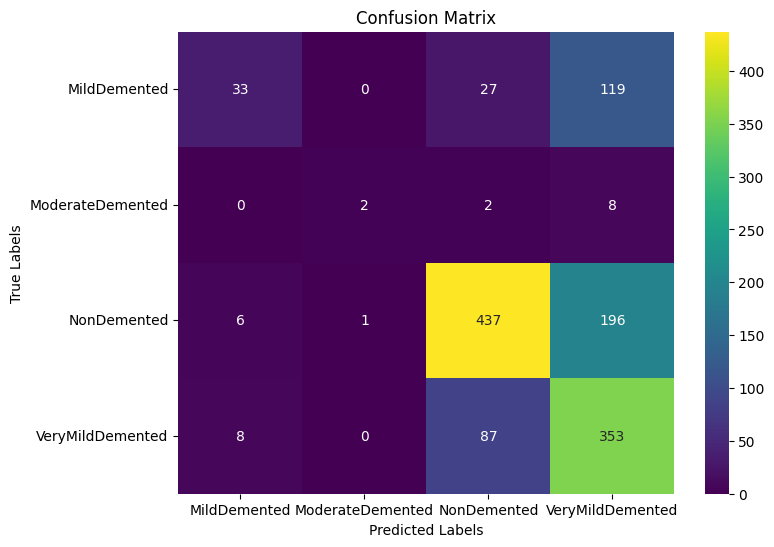

In [ ]:
xception_model.eval()

total_correct = 0
total_samples = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = xception_model(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

plot_results(true_labels, predicted_labels)

The latest classification report showcases the model trained from scratch performance on the dementia classification task. When compared to the previous results of fine tuned best model, some changes in precision, recall, and F1-score can be observed.
 - Precision - the precision for the "MildDemented" class was 0.70, for the "ModerateDemented" class it was 0.67 from 0.78, for the "NonDemented" class it was 0.79, and for the "VeryMildDemented" class it was 0.52.
 - Recall - the recall for the "MildDemented" class was 0.18 , for the "ModerateDemented" class it was 0.17. The recall for the "NonDemented" class was 0.68, and for the "VeryMildDemented" class it was to 0.79.
 - F1-score - the F1-score for the "MildDemented" class was 0.29, for the "ModerateDemented" class it was 0.27. The F1-score for the "NonDemented" class was 0.73, and for the "VeryMildDemented" class it was 0.63.
 - Accuracy - the accuracy of the model was 0.65.
 - Macro Avg - the macro average precision, recall, and F1-score were 0.67, 0.46, and 0.48, respectively.
 - Weighted Avg - the weighted average precision, recall, and F1-score were 0.68, 0.65, and 0.63, respectively.

 In comparison to the previous classification results, the new results demonstrate some changes in the model's performance, but overall lower performance achieved than the best fine tuned model.

Overall, these changes indicate variations in the model's ability to accurately classify the different dementia classes, which may be explored with more hyperparameter tuning the trained from scratch model.